In [3]:
!pip install --upgrade libpysal esda

import pandas as pd
import numpy as np 
import re
from datetime import datetime 
import ast
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Install external packages separately through the command line or using !pip in Jupyter
# Example:
!pip install urbanaccess
!pip install pandana


#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Paris Airbnb_Spatiotemporal_Analysis/Models/FINAL_BIG_DATASET_PARIS.csv'
dataframe1= pd.read_csv(file_path)

In [4]:
dataframe1['date'] = pd.to_datetime(dataframe1['date'])

In [5]:
dataframe1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703263 entries, 0 to 703262
Columns: 171 entries, id to date
dtypes: bool(132), datetime64[ns](1), float64(18), int64(20)
memory usage: 297.8 MB


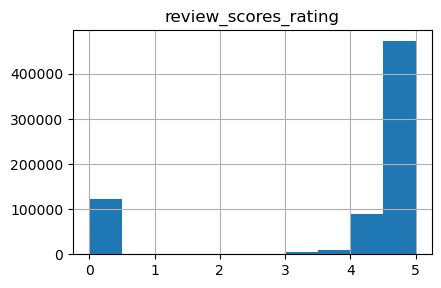

In [6]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(dataframe1.columns[dataframe1.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    dataframe1[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

#out of these we see that most of them are rated quite positive, with the biggest amount around 4-5/5 stars

In [10]:
import geopandas as gpd
# Importing the Paris neighbourhood  GeoJSON file as a dataframe in geopandas
map_dataframe1 = gpd.read_file('C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Data/2. airbnb_data/Paris/Q1 airbnb_data Paris/neighbourhoods.geojson')
map_dataframe1.drop('neighbourhood_group', axis = 1, inplace = True)
map_dataframe1.head(20)

neighbourhood                                           geometry
0   Batignolles-Monceau  MULTIPOLYGON (((2.29517 48.87396, 2.29504 48.8...
1        Palais-Bourbon  MULTIPOLYGON (((2.32090 48.86306, 2.32094 48.8...
2       Buttes-Chaumont  MULTIPOLYGON (((2.38943 48.90122, 2.39014 48.9...
3                 Opéra  MULTIPOLYGON (((2.33978 48.88203, 2.33982 48.8...
4              Entrepôt  MULTIPOLYGON (((2.36469 48.88437, 2.36485 48.8...
5              Gobelins  MULTIPOLYGON (((2.37491 48.83801, 2.37698 48.8...
6             Vaugirard  MULTIPOLYGON (((2.29932 48.85217, 2.30088 48.8...
7               Reuilly  MULTIPOLYGON (((2.41388 48.83357, 2.41401 48.8...
8                Louvre  MULTIPOLYGON (((2.32801 48.86992, 2.32997 48.8...
9            Luxembourg  MULTIPOLYGON (((2.34459 48.85405, 2.34428 48.8...
10               Élysée  MULTIPOLYGON (((2.32584 48.86956, 2.32569 48.8...
11               Temple  MULTIPOLYGON (((2.36383 48.86750, 2.36389 48.8...
12         Ménilmontant  MULTIPOLYGON (((2.41276 48.87547, 2.41284 48.8...
13             Panthéon  MULTIPOLYGON (((2.36443 48.84614, 2.36484 48.8...
14                Passy  MULTIPOLYGON (((2.27427 48.87837, 2.27749 48.8...
15         Observatoire  MULTIPOLYGON (((2.33381 48.84061, 2.33673 48.8...
16           Popincourt  MULTIPOLYGON (((2.39624 48.85415, 2.39708 48.8...
17               Bourse  MULTIPOLYGON (((2.35152 48.86443, 2.35095 48.8...
18    Buttes-Montmartre  MULTIPOLYGON (((2.36580 48.88554, 2.36469 48.8...
19       Hôtel-de-Ville  MULTIPOLYGON (((2.36851 48.85573, 2.36900 48.8...

In [11]:
# List of all neighbourhood columns
neighbourhood_cols = [
    'neighbourhood_Batignolles-Monceau', 'neighbourhood_Bourse', 'neighbourhood_Buttes-Chaumont',
    'neighbourhood_Buttes-Montmartre', 'neighbourhood_Entrepôt', 'neighbourhood_Gobelins',
    'neighbourhood_Hôtel-de-Ville', 'neighbourhood_Louvre', 'neighbourhood_Luxembourg',
    'neighbourhood_Ménilmontant', 'neighbourhood_Observatoire', 'neighbourhood_Opéra',
    'neighbourhood_Palais-Bourbon', 'neighbourhood_Panthéon', 'neighbourhood_Passy',
    'neighbourhood_Popincourt', 'neighbourhood_Reuilly', 'neighbourhood_Temple',
    'neighbourhood_Vaugirard', 'neighbourhood_Élysée'
]

def get_neighbourhood(row):
    for col in neighbourhood_cols:
        if row[col]:
            return col.split('_')[1]  # Assuming the format 'neighbourhood_NAME'
    return None  # In case no neighbourhood column is True

# Apply this function to create the new 'neighbourhood' column
dataframe1['neighbourhood'] = dataframe1.apply(get_neighbourhood, axis=1)

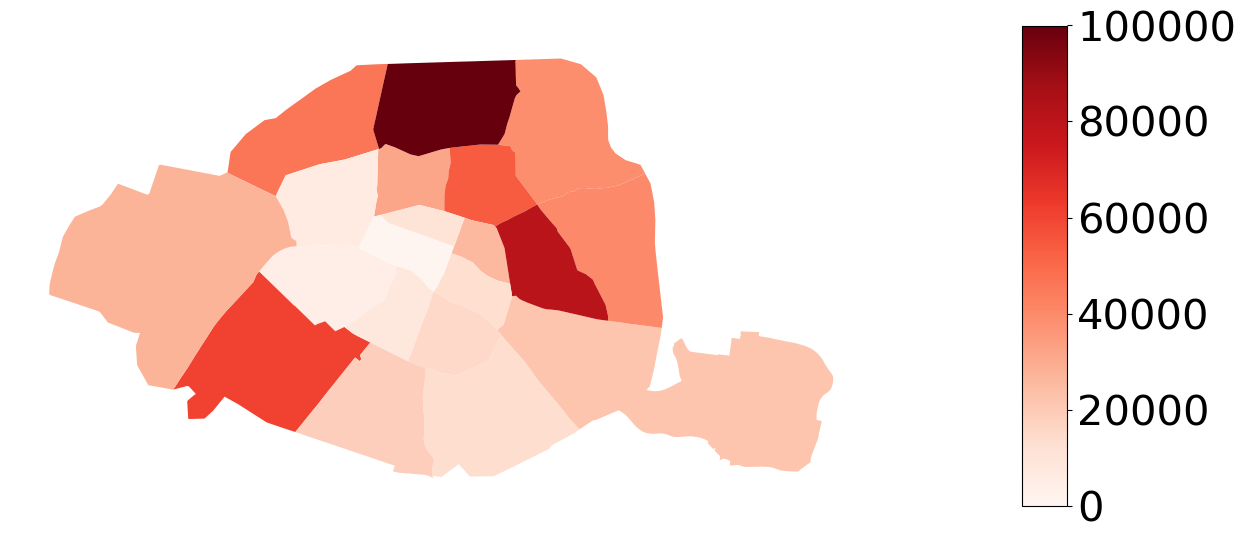

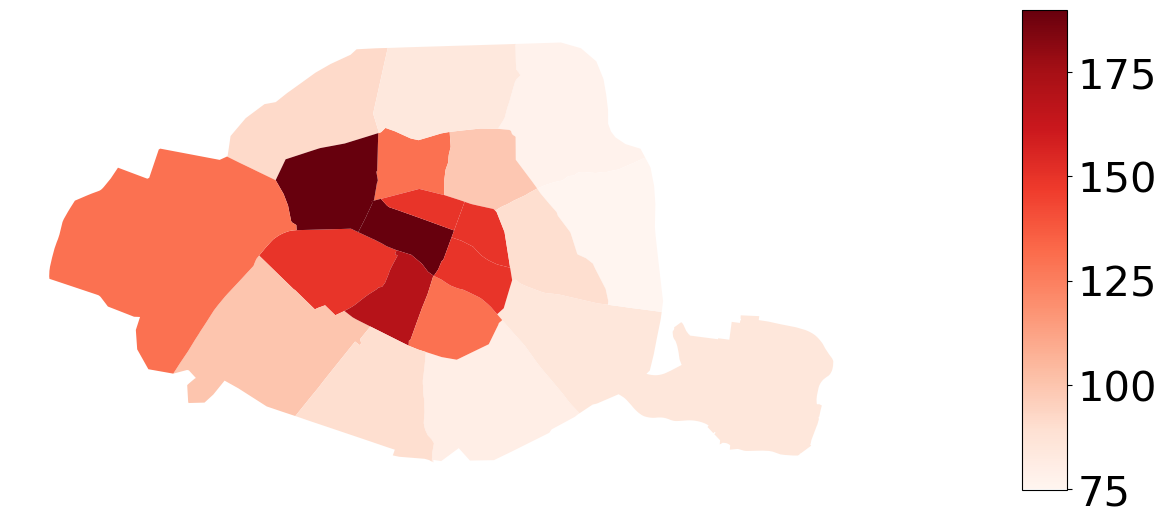

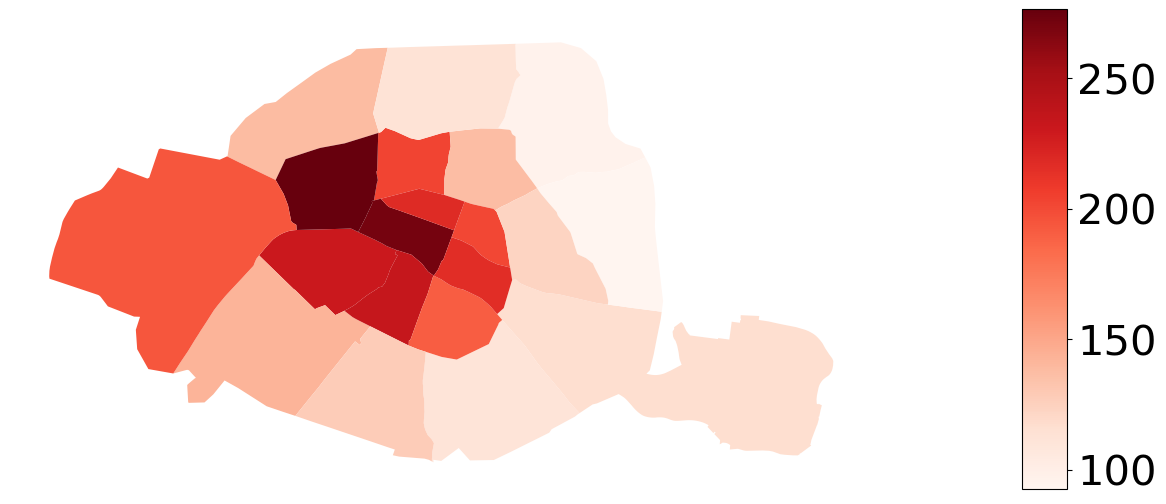

                     number_of_listings  median_price  mean_price
neighbourhood                                                    
Batignolles-Monceau               44884          92.0  137.690625
Bourse                            22762         150.0  217.874703
Buttes-Chaumont                   40185          77.0   95.893094
Buttes-Montmartre                 78243          84.0  113.153010
Entrepôt                          49490          99.0  136.958153
Gobelins                          24396          80.0  111.612764
Hôtel-de-Ville                    24201         150.0  216.610057
Louvre                            15953         190.0  270.609917
Luxembourg                        21017         169.0  233.526241
Ménilmontant                      41123          75.0   92.396153
Observatoire                      27406          90.0  127.815186
Opéra                             35440         130.0  203.022630
Palais-Bourbon                    18560         150.0  230.511638
Panthéon  

In [13]:
#setting the characteristics for the following plot
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = 280, 280


# Creating a dataframe of listing counts and median price by neighbourhood
neighbourhood_dataframe1 = pd.DataFrame(dataframe1.groupby('neighbourhood').size())
neighbourhood_dataframe1.rename(columns={0: 'number_of_listings'}, inplace=True)
neighbourhood_dataframe1['median_price'] = dataframe1.groupby('neighbourhood').price.median().values
neighbourhood_dataframe1['mean_price'] = dataframe1.groupby('neighbourhood').price.mean().values

# Putting the dataframes together
neighbourhood_map_dataframe1 = map_dataframe1.set_index('neighbourhood').join(neighbourhood_dataframe1)
                  
# Plotting the number of listings in each neighbourhood
fig1, ax1 = plt.subplots(1, figsize=(15, 6)) #deciding on plot size
neighbourhood_map_dataframe1.plot(column='number_of_listings', cmap='Reds', ax=ax1, rasterized=True) 
#rasterized to makes it easier for big data sets + ax1 earlier defined

ax1.axis('off') #disabling the axis components, including axis labels, ticks, and the frame surrounding the plot
cax1 = fig1.add_axes([0.9, 0.1, 0.03, 0.8]) # Adjusted the position and size as needed for the side axis [left, bottom, width, height]
#ScalarMappable to make a color map + norm, to normalize the coloring within the graph 
sm1 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=100000))
sm1._A = [] # The primary reason for doing this is to provide an empty array that will later be populated with the data range when the plot is created. The colorbar uses this array to decide the color scaling for the colormap.
cbar1 = fig1.colorbar(sm1, cax=cax1) 
plt.show()

# Plotting the median price of listings in each neighbourhood
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_dataframe1.plot(column='median_price', cmap='Reds', ax=ax2)
ax2.axis('off')
cax2 = fig2.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjusted the position and size as needed for the side axis [left, bottom, width, height]
#ScalarMappable to make a color map + norm, to normalize the coloring within the graph 
sm2 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(neighbourhood_map_dataframe1.median_price), vmax=max(neighbourhood_map_dataframe1.median_price))) 
sm2._A = [] # The primary reason for doing this is to provide an empty array that will later be populated with the data range when the plot is created. The colorbar uses this array to decide the color scaling for the colormap.
cbar2 = fig2.colorbar(sm2, cax=cax2)
plt.show()

# Plotting the mean price of listings in each neighbourhood
fig3, ax3 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_dataframe1.plot(column='mean_price', cmap='Reds', ax=ax3)
ax3.axis('off')
cax3 = fig3.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjusted the position and size as needed for the side axis [left, bottom, width, height]
#ScalarMappable to make a color map + norm, to normalize the coloring within the graph 
sm3 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(neighbourhood_map_dataframe1.mean_price), vmax=max(neighbourhood_map_dataframe1.mean_price))) 
sm3._A = [] # The primary reason for doing this is to provide an empty array that will later be populated with the data range when the plot is created. The colorbar uses this array to decide the color scaling for the colormap.
cbar3 = fig3.colorbar(sm3, cax=cax3)
plt.show()

print(neighbourhood_dataframe1)

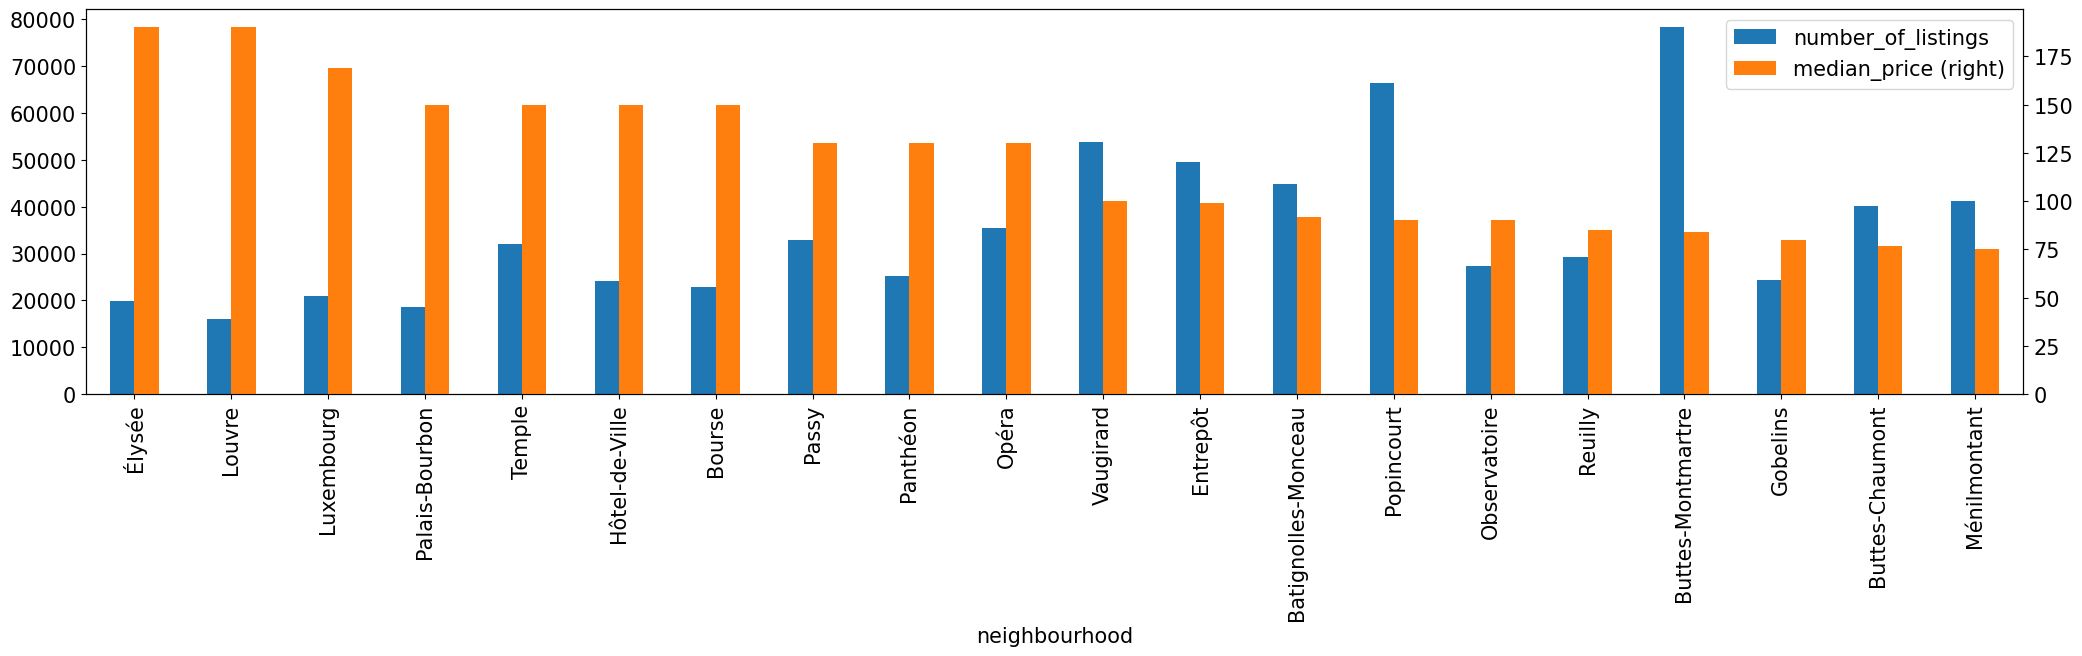

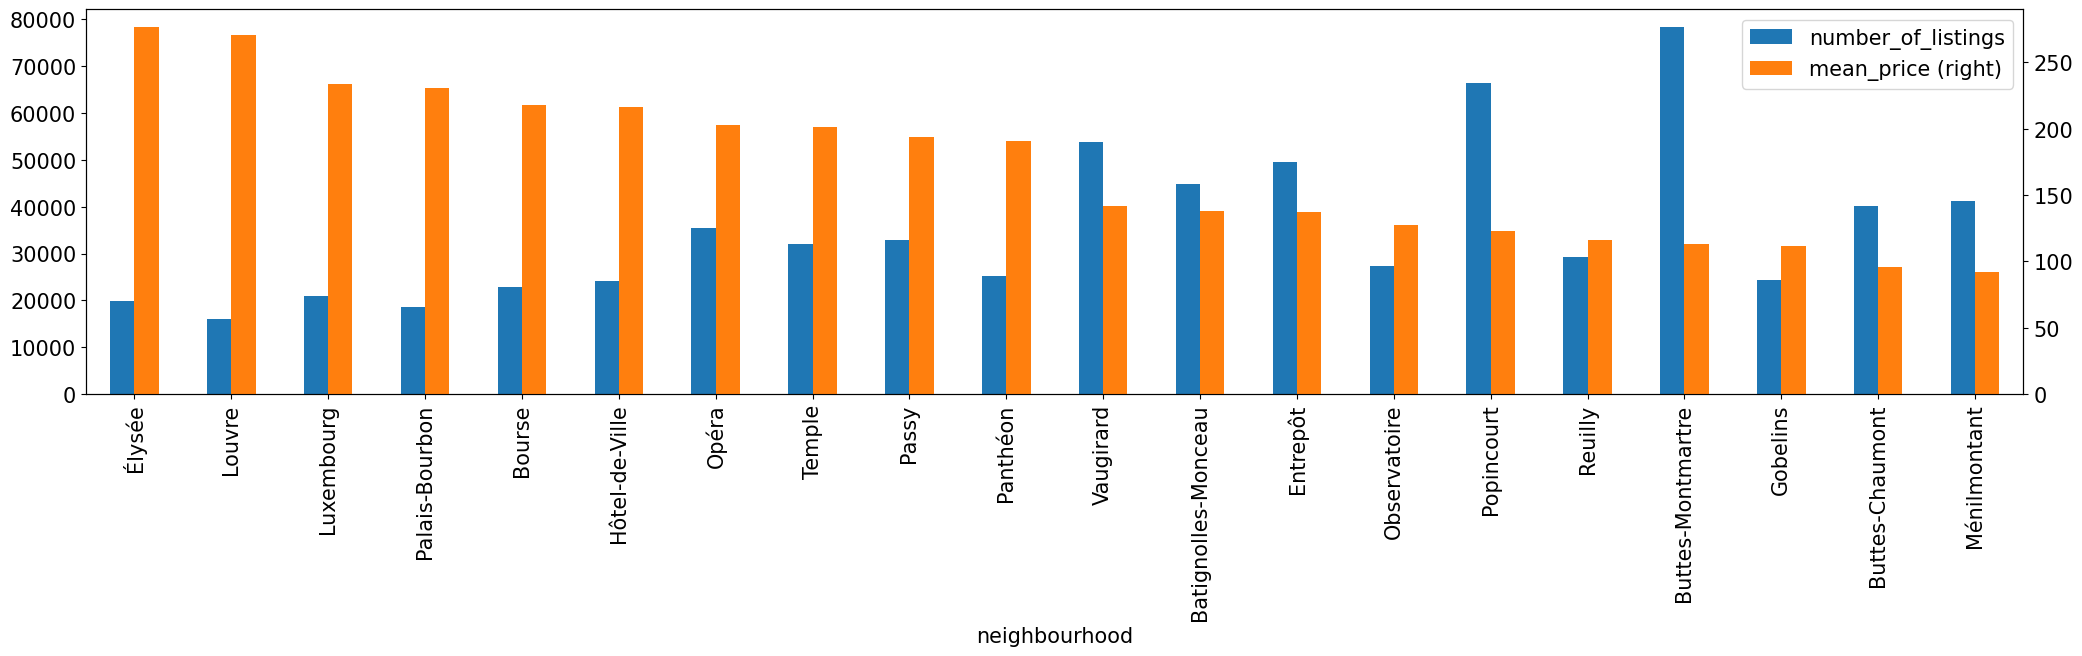

In [14]:
# Plot number of listings and median price in one bar plot
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = 25, 5
selected_columns = ['number_of_listings', 'median_price']
neighbourhood_dataframe1_selected = neighbourhood_dataframe1[selected_columns]
neighbourhood_dataframe1_sorted = neighbourhood_dataframe1_selected.sort_values('median_price', ascending=False)
neighbourhood_dataframe1_sorted.plot( kind= 'bar' , secondary_y= 'median_price' , rot= 90 )
plt.xticks(rotation='vertical')
plt.show()

# Plot number of listings and mean price in one bar plot
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = 25, 5
selected_columns = ['number_of_listings', 'mean_price']
neighbourhood_dataframe1_selected = neighbourhood_dataframe1[selected_columns]
neighbourhood_dataframe1_sorted = neighbourhood_dataframe1_selected.sort_values('mean_price', ascending=False)
neighbourhood_dataframe1_sorted.plot( kind= 'bar' , secondary_y= 'mean_price' , rot= 90 )
plt.xticks(rotation='vertical')
plt.show()

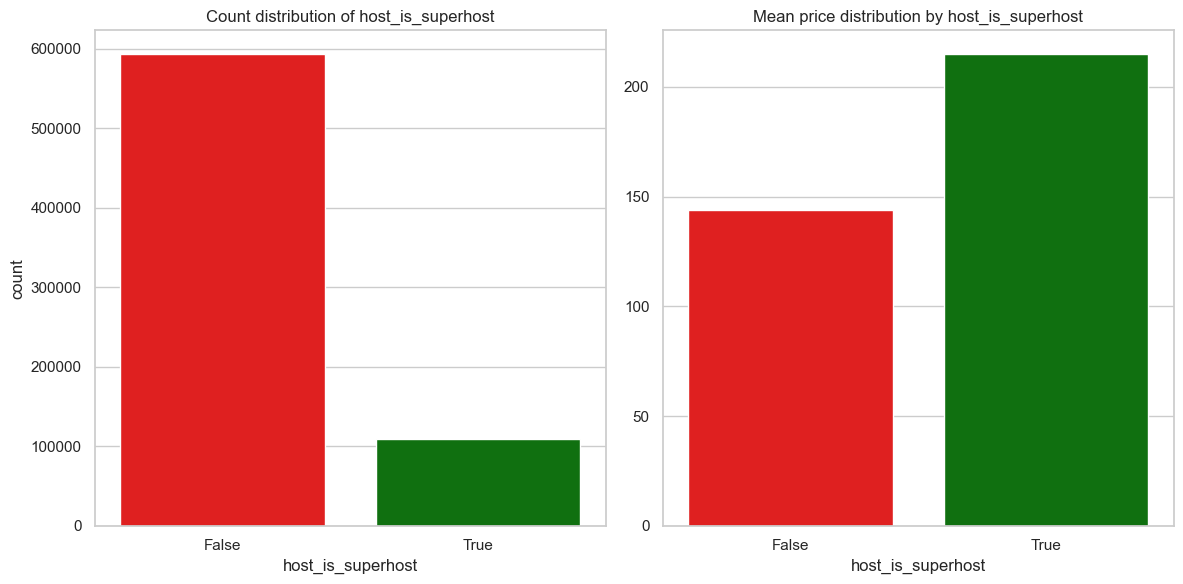

% Wise Split of host_is_superhost:
host_is_superhost
False    84.396876
True     15.603124
Name: proportion, dtype: float64

P-value for host_is_superhost: 0.0
host_is_superhost is statistically significant (p-value < 0.05)
host_is_superhost
False    0.843969
True     0.156031
Name: proportion, dtype: float64


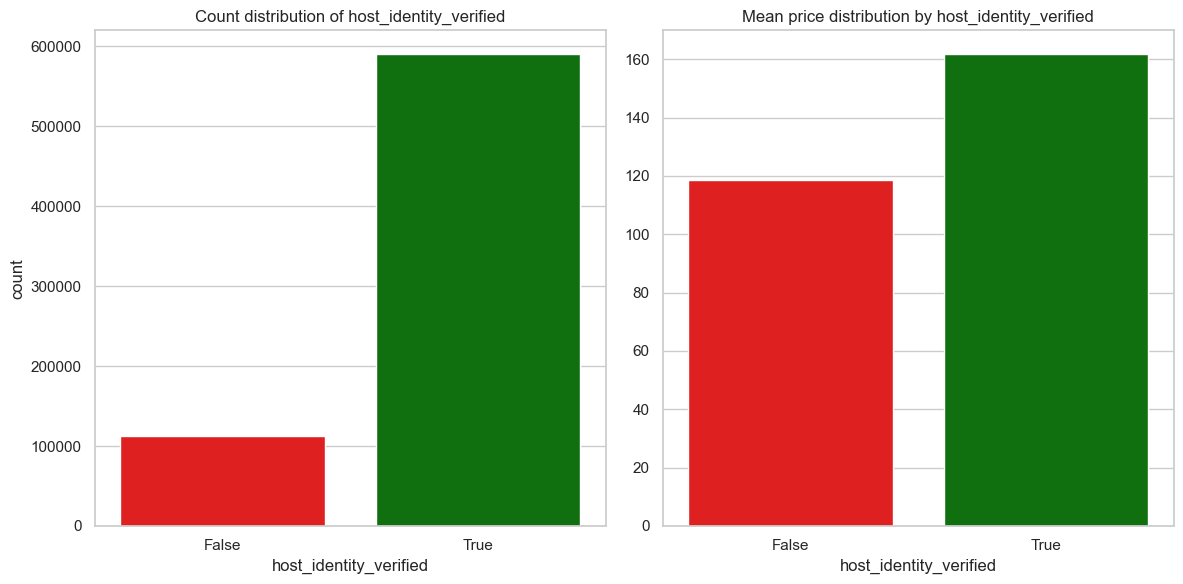

% Wise Split of host_identity_verified:
host_identity_verified
True     83.968018
False    16.031982
Name: proportion, dtype: float64

P-value for host_identity_verified: 0.0
host_identity_verified is statistically significant (p-value < 0.05)
host_identity_verified
True     0.83968
False    0.16032
Name: proportion, dtype: float64


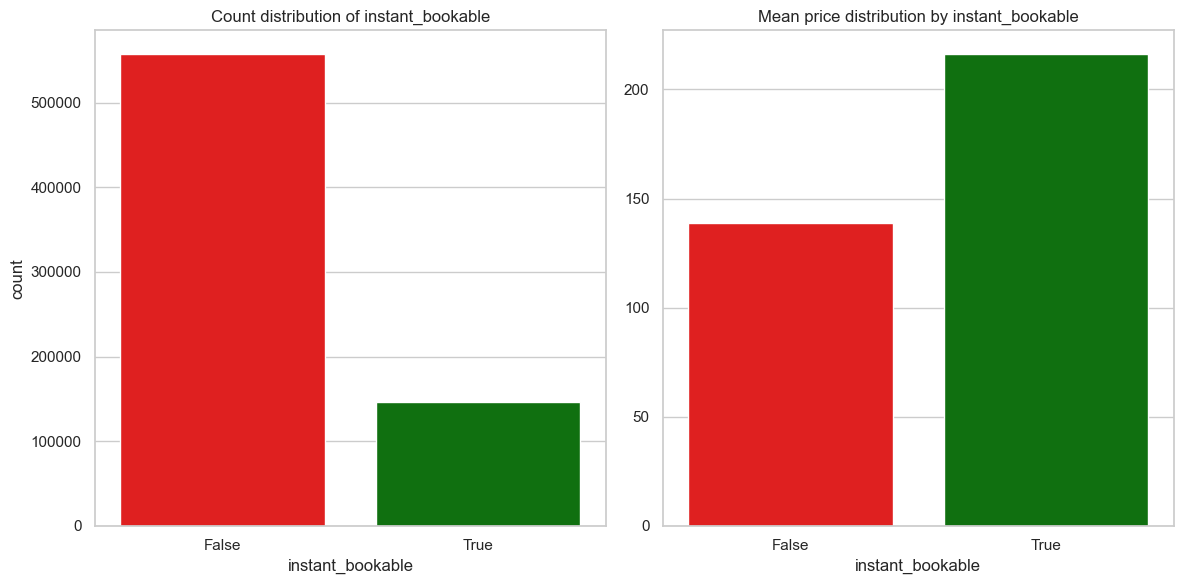

% Wise Split of instant_bookable:
instant_bookable
False    79.250863
True     20.749137
Name: proportion, dtype: float64

P-value for instant_bookable: 0.0
instant_bookable is statistically significant (p-value < 0.05)
instant_bookable
False    0.792509
True     0.207491
Name: proportion, dtype: float64


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

def binary_count_and_price_plot(column_name, alpha=0.05):
    # Assuming dataframe1 is your DataFrame
    
    # Define colors for True and False values
    colors = {True: 'green', False: 'red'}

    # Plot count distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=column_name, data=dataframe1, palette=colors)
    plt.title(f'Count distribution of {column_name}')

    # Plot median price distribution
    plt.subplot(1, 2, 2)
    mean_prices = dataframe1.groupby(column_name)['price'].mean()
    sns.barplot(x=mean_prices.index, y=mean_prices.values, palette=colors)
    plt.title(f'Mean price distribution by {column_name}')
    plt.tight_layout()
    plt.show()

    # Calculate t-test for median prices
    true_prices = dataframe1[dataframe1[column_name] == True]['price']
    false_prices = dataframe1[dataframe1[column_name] == False]['price']
    t_stat, p_value = ttest_ind(true_prices, false_prices)
   
    # Display additional information
    percent_split = dataframe1[column_name].value_counts(normalize=True) * 100
    print(f'% Wise Split of {column_name}:\n{percent_split}')
    
    t_statistic, p_value = ttest_ind(true_prices, false_prices, equal_var=False)  # assuming unequal variances
    print(f'\nP-value for {column_name}: {p_value}')
    
    # Check if p-value is greater than or equal to alpha
    if p_value >= alpha:
        print(f"{column_name} is not statistically significant (p-value >= {alpha})")
        return column_name
    else:
        print(f"{column_name} is statistically significant (p-value < {alpha})")
        return None  # or any other value if needed

superhost = binary_count_and_price_plot('host_is_superhost')
print(dataframe1.host_is_superhost.value_counts(normalize=True))

test2 = binary_count_and_price_plot('host_identity_verified')
print(dataframe1.host_identity_verified.value_counts(normalize=True))

test3 = binary_count_and_price_plot('instant_bookable')
print(dataframe1.instant_bookable.value_counts(normalize=True))

In [16]:
# Get column names and their indices
column_info = list(enumerate(dataframe1.columns))
# Print column names and their indices
for index, column_name in column_info:
    print(f"Column {index}: {column_name}")
    
#now we know that the amenity columns start from index 51

Column 0: id
Column 1: host_response_time
Column 2: host_response_rate
Column 3: host_is_superhost
Column 4: host_total_listings_count
Column 5: host_identity_verified
Column 6: latitude
Column 7: longitude
Column 8: accommodates
Column 9: bathrooms
Column 10: beds
Column 11: minimum_nights
Column 12: maximum_nights
Column 13: has_availability
Column 14: availability_90
Column 15: availability_365
Column 16: number_of_reviews
Column 17: number_of_reviews_l30d
Column 18: review_scores_rating
Column 19: instant_bookable
Column 20: calculated_host_listings_count
Column 21: calculated_host_listings_count_private_rooms
Column 22: calculated_host_listings_count_shared_rooms
Column 23: reviews_per_month
Column 24: days_since_host
Column 25: Cleaning products
Column 26: Essentials
Column 27: Books and reading material
Column 28: Dryer
Column 29: Baking sheet
Column 30: pool
Column 31: backyard
Column 32: Free washer – In unit
Column 33: Piano
Column 34: Washer
Column 35: view
Column 36: bbq
Co

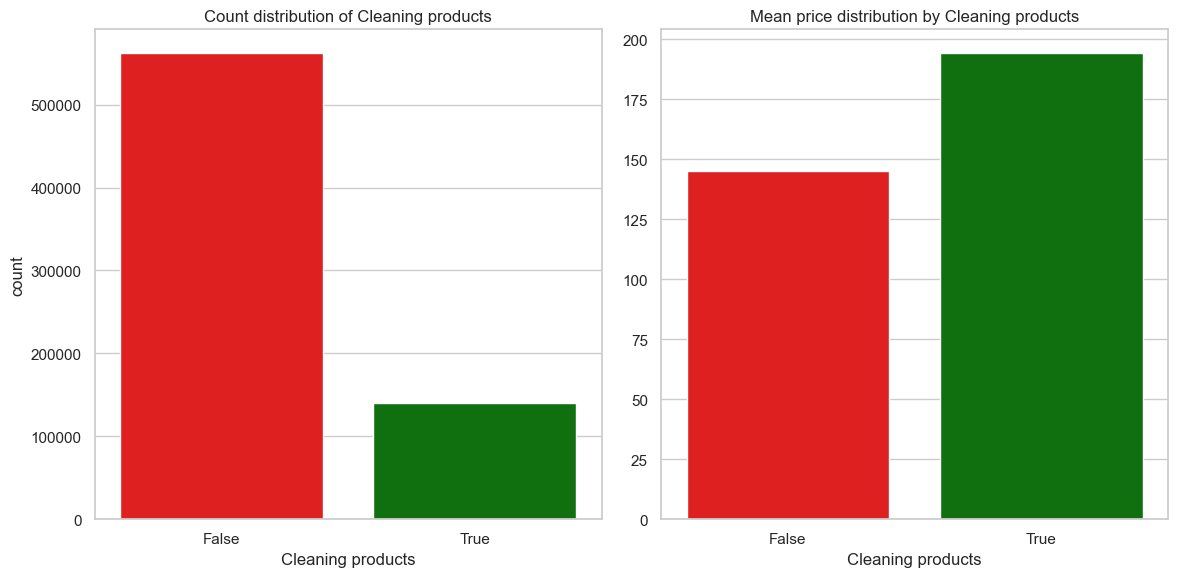

% Wise Split of Cleaning products:
Cleaning products
False    80.004067
True     19.995933
Name: proportion, dtype: float64

P-value for Cleaning products: 0.0
Cleaning products is statistically significant (p-value < 0.05)


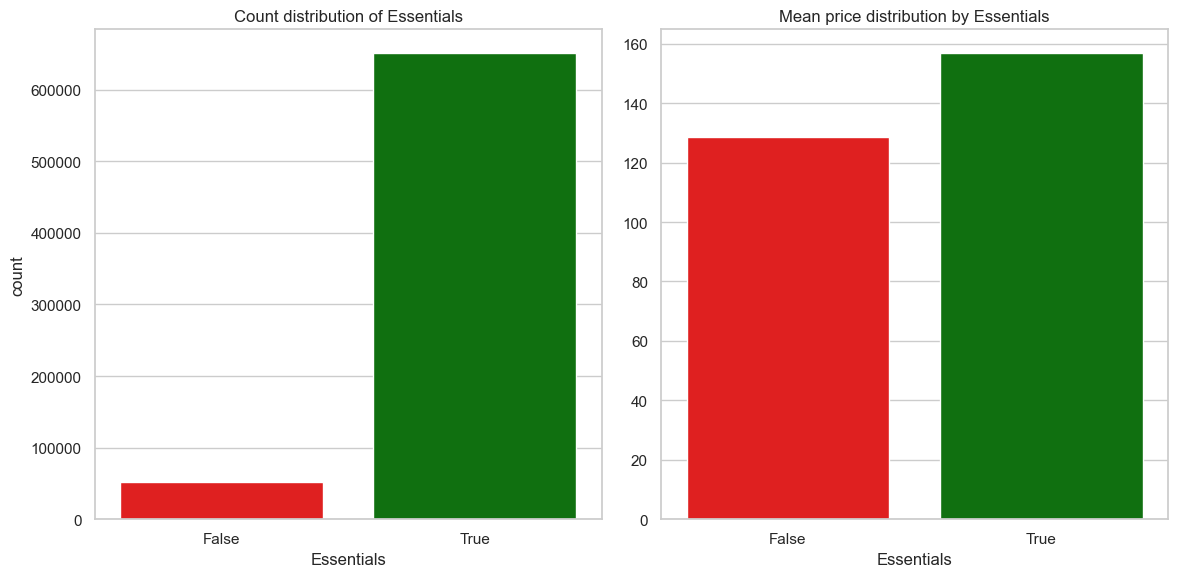

% Wise Split of Essentials:
Essentials
True     92.653957
False     7.346043
Name: proportion, dtype: float64

P-value for Essentials: 0.0
Essentials is statistically significant (p-value < 0.05)


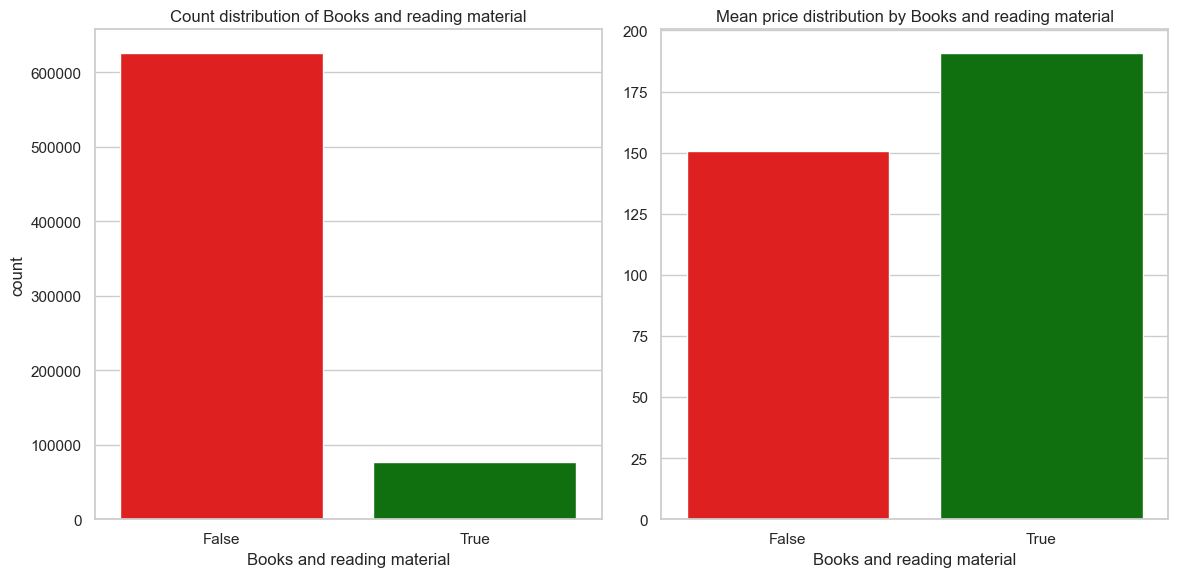

% Wise Split of Books and reading material:
Books and reading material
False    89.049758
True     10.950242
Name: proportion, dtype: float64

P-value for Books and reading material: 0.0
Books and reading material is statistically significant (p-value < 0.05)


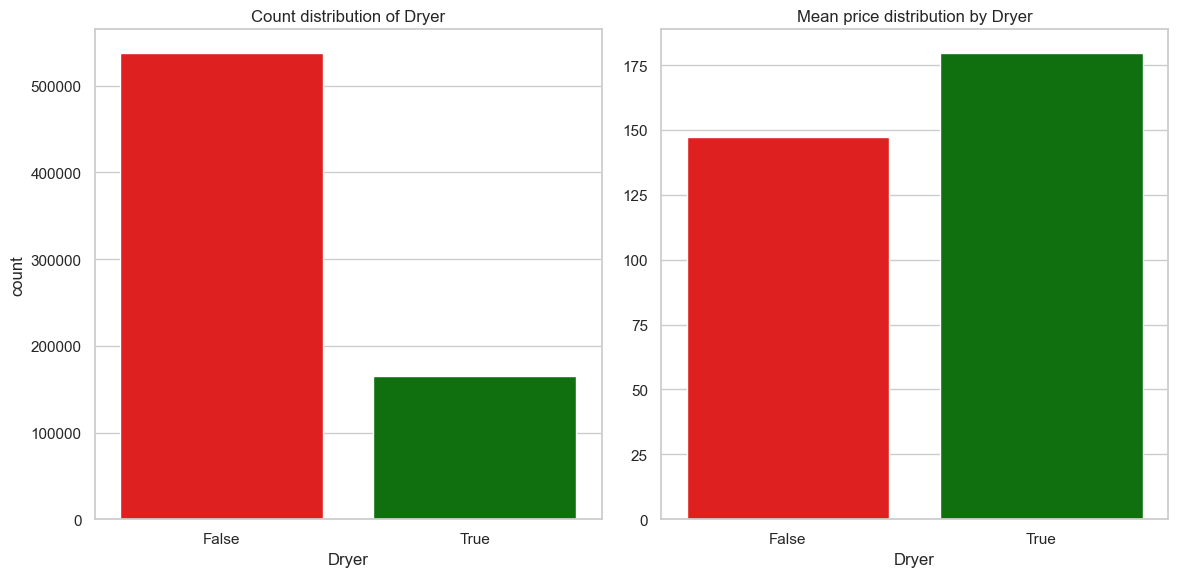

% Wise Split of Dryer:
Dryer
False    76.483193
True     23.516807
Name: proportion, dtype: float64

P-value for Dryer: 0.0
Dryer is statistically significant (p-value < 0.05)


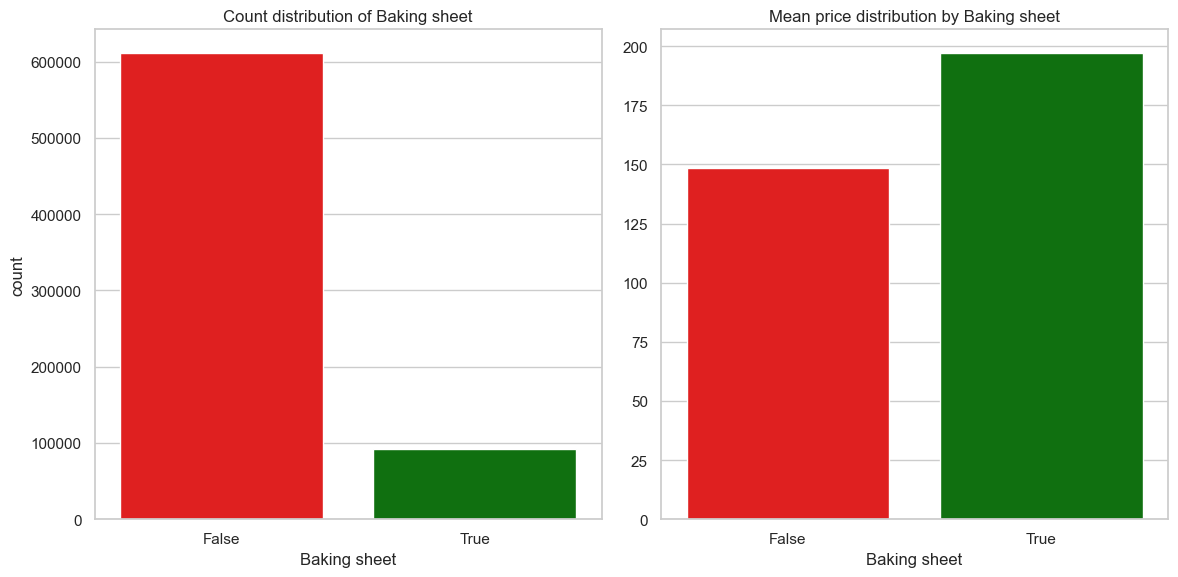

% Wise Split of Baking sheet:
Baking sheet
False    86.996188
True     13.003812
Name: proportion, dtype: float64

P-value for Baking sheet: 0.0
Baking sheet is statistically significant (p-value < 0.05)


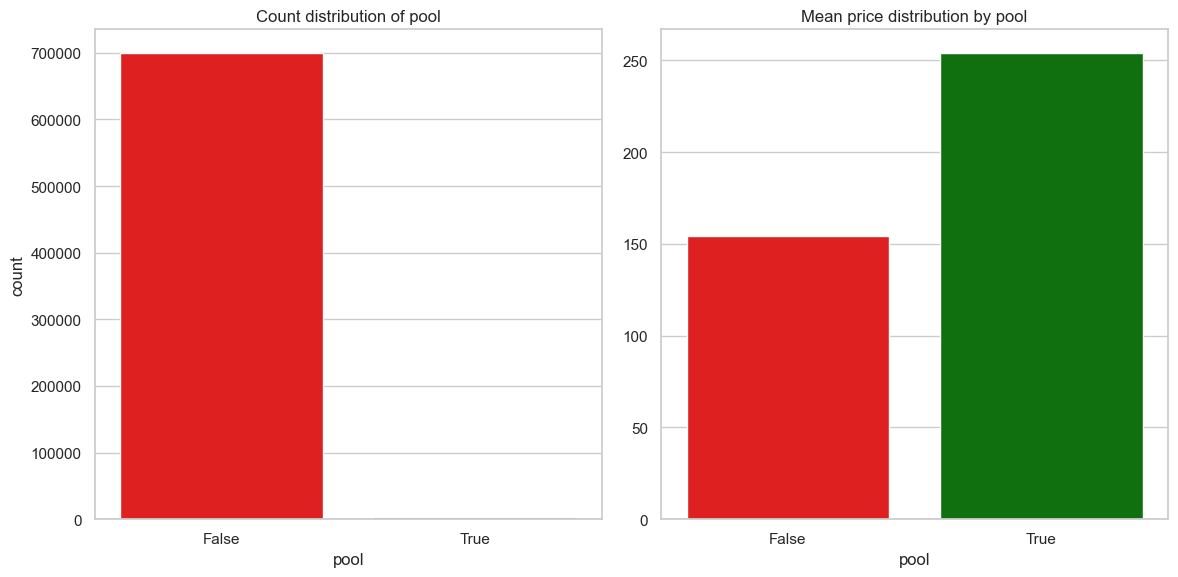

% Wise Split of pool:
pool
False    99.562184
True      0.437816
Name: proportion, dtype: float64

P-value for pool: 3.050612734216566e-139
pool is statistically significant (p-value < 0.05)


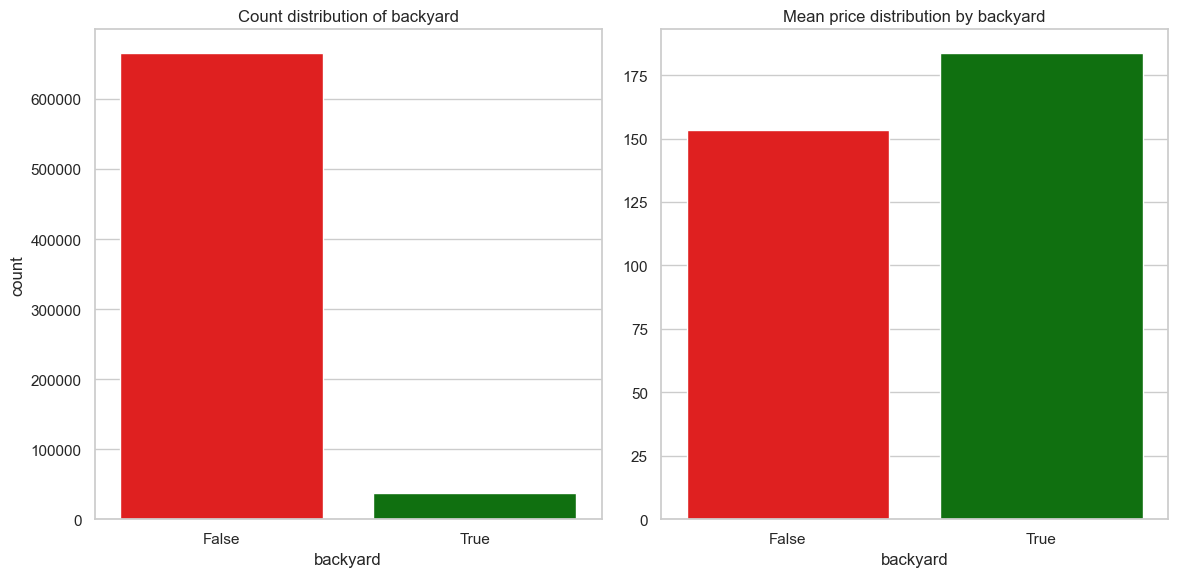

% Wise Split of backyard:
backyard
False    94.686483
True      5.313517
Name: proportion, dtype: float64

P-value for backyard: 7.513678257953389e-241
backyard is statistically significant (p-value < 0.05)


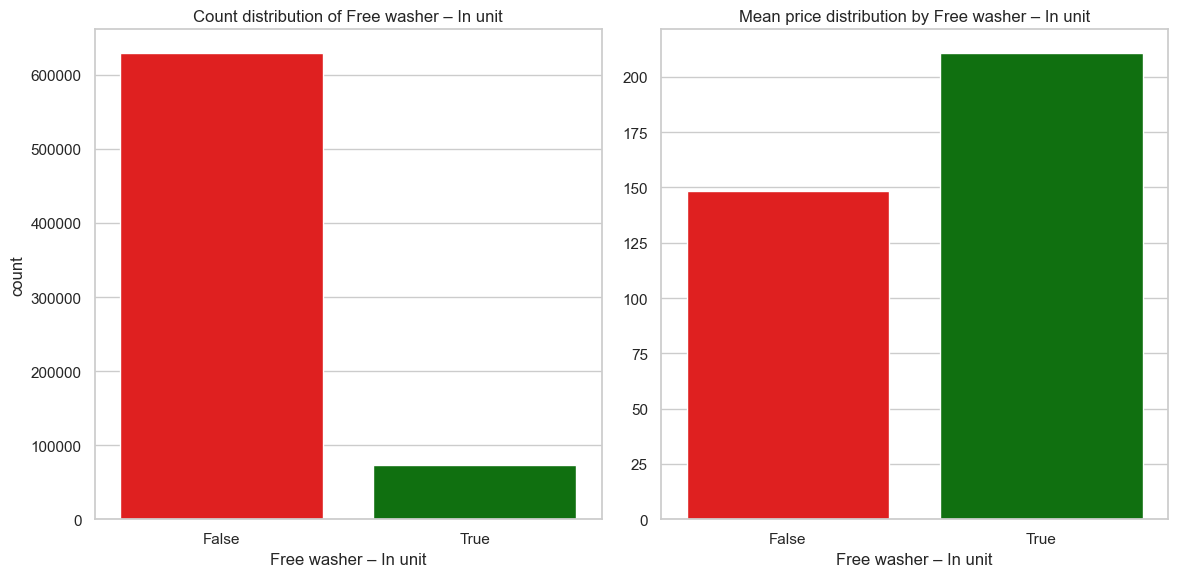

% Wise Split of Free washer – In unit:
Free washer – In unit
False    89.555685
True     10.444315
Name: proportion, dtype: float64

P-value for Free washer – In unit: 0.0
Free washer – In unit is statistically significant (p-value < 0.05)


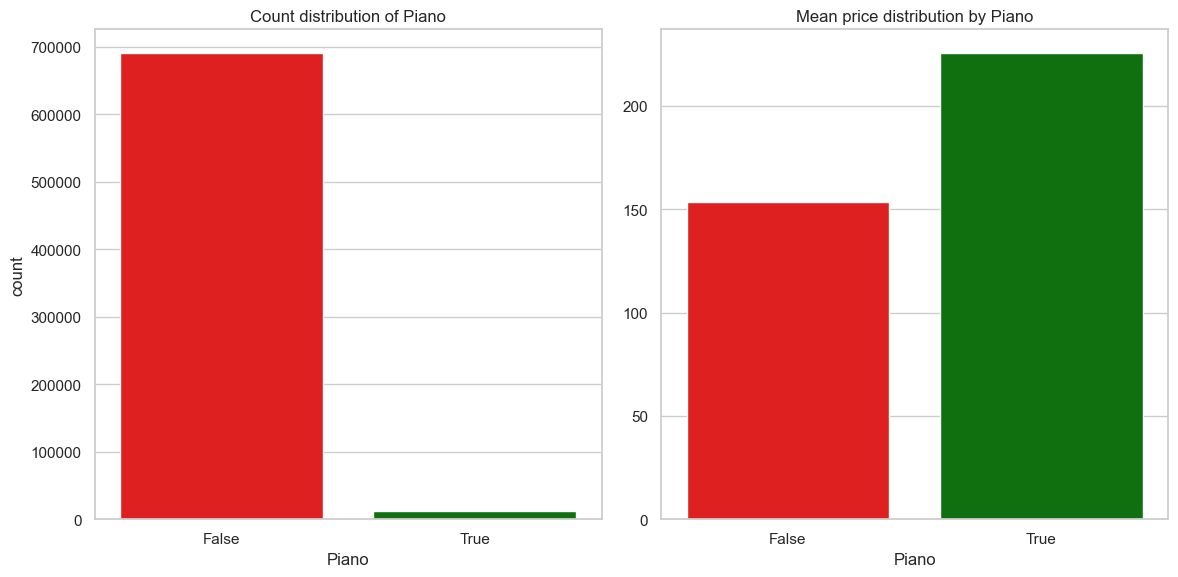

% Wise Split of Piano:
Piano
False    98.277174
True      1.722826
Name: proportion, dtype: float64

P-value for Piano: 0.0
Piano is statistically significant (p-value < 0.05)


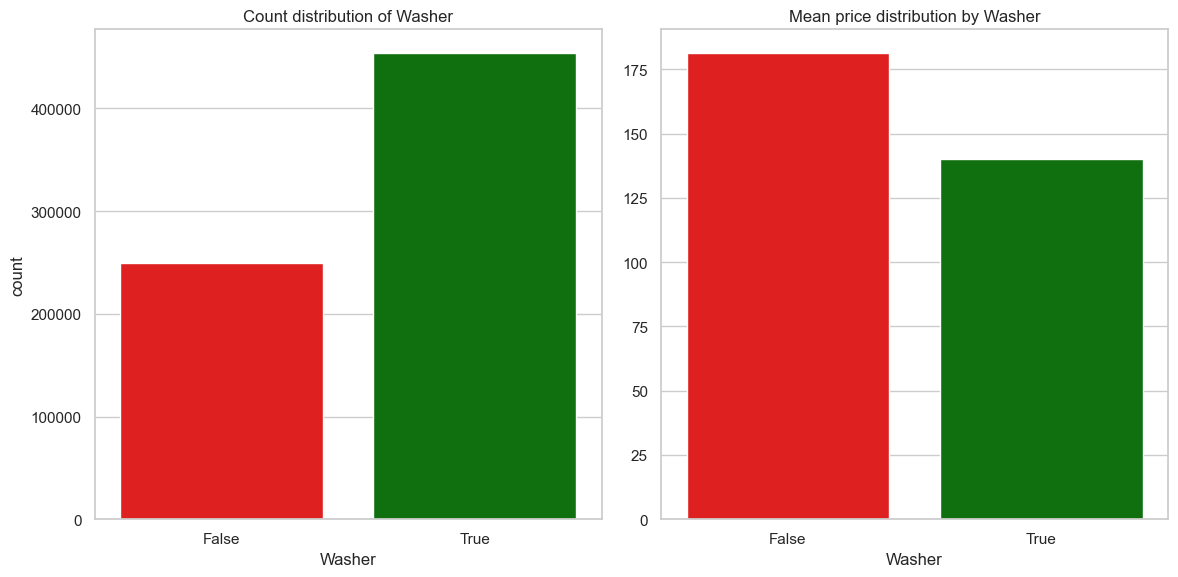

% Wise Split of Washer:
Washer
True     64.56859
False    35.43141
Name: proportion, dtype: float64

P-value for Washer: 0.0
Washer is statistically significant (p-value < 0.05)


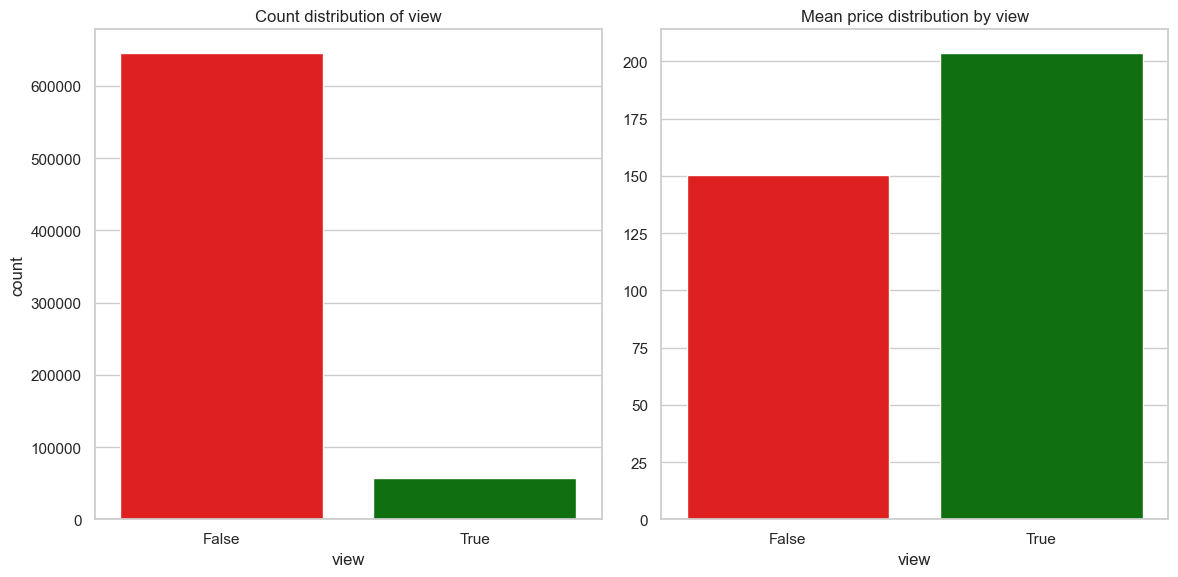

% Wise Split of view:
view
False    91.834349
True      8.165651
Name: proportion, dtype: float64

P-value for view: 0.0
view is statistically significant (p-value < 0.05)


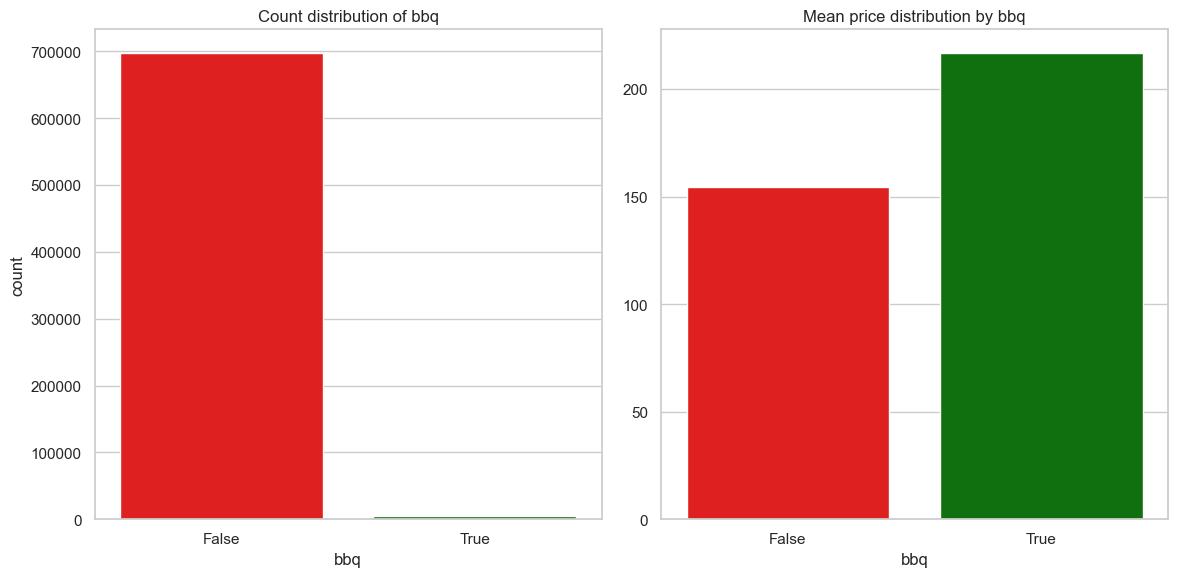

% Wise Split of bbq:
bbq
False    99.224046
True      0.775954
Name: proportion, dtype: float64

P-value for bbq: 3.5948152240709615e-111
bbq is statistically significant (p-value < 0.05)


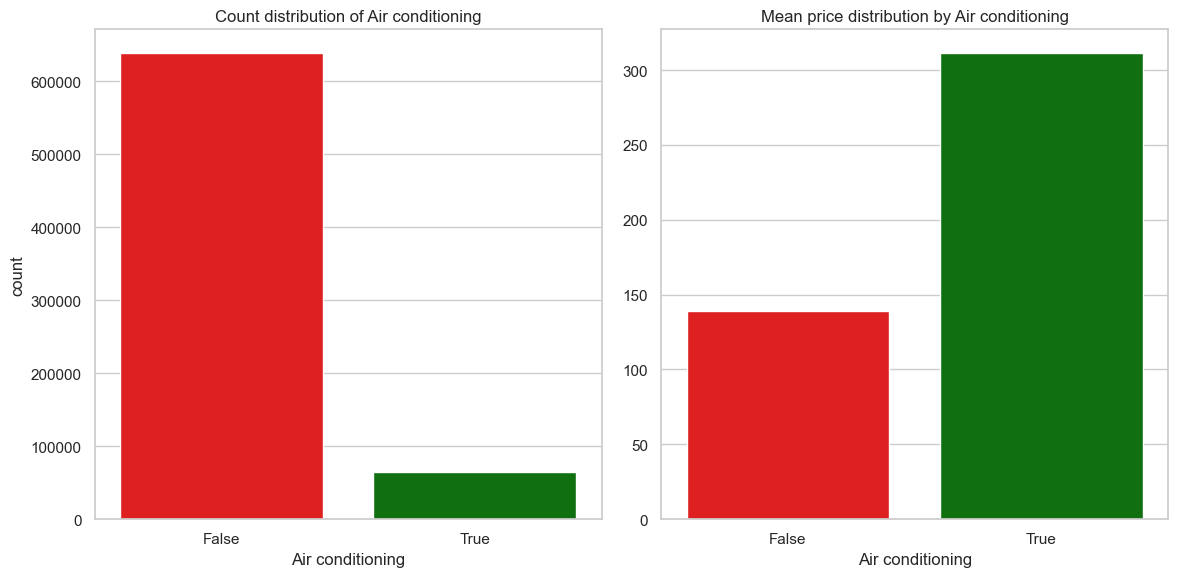

% Wise Split of Air conditioning:
Air conditioning
False    90.851787
True      9.148213
Name: proportion, dtype: float64

P-value for Air conditioning: 0.0
Air conditioning is statistically significant (p-value < 0.05)


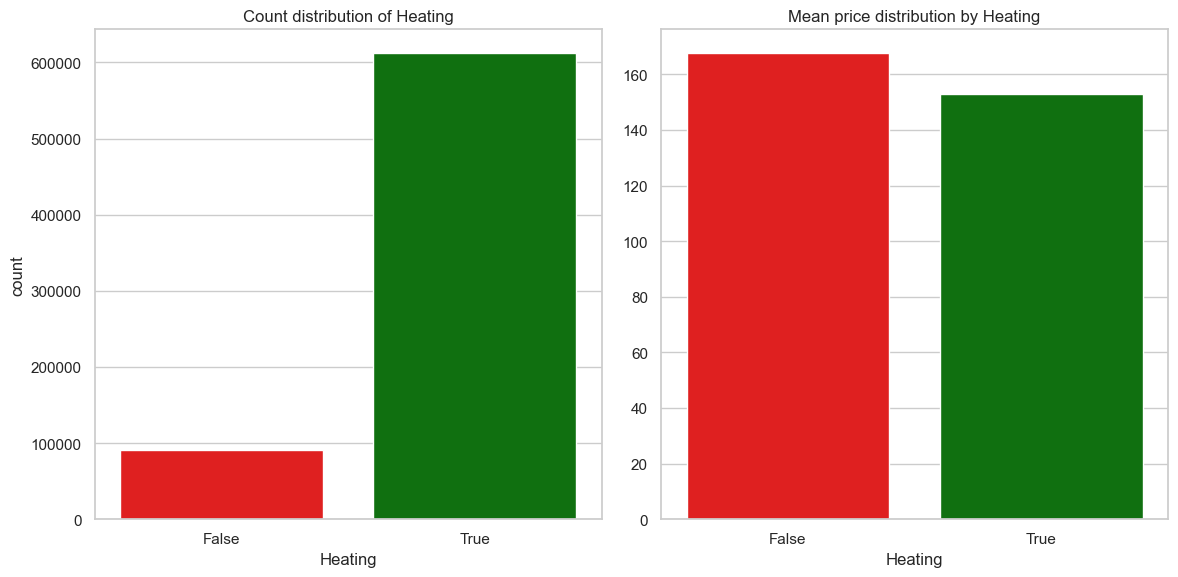

% Wise Split of Heating:
Heating
True     87.118333
False    12.881667
Name: proportion, dtype: float64

P-value for Heating: 8.911779711350484e-135
Heating is statistically significant (p-value < 0.05)


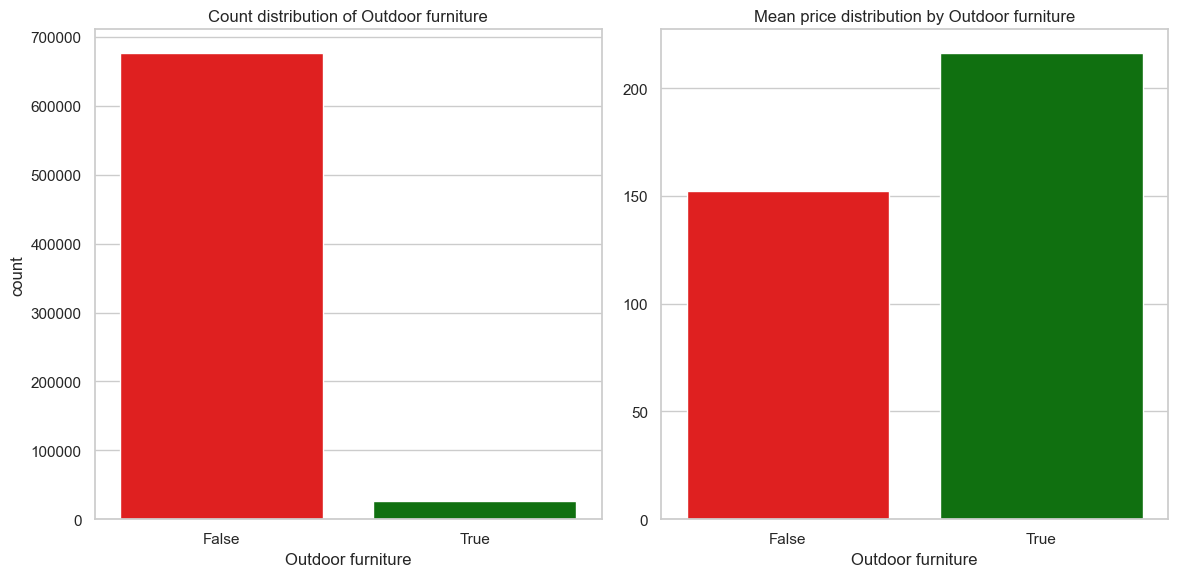

% Wise Split of Outdoor furniture:
Outdoor furniture
False    96.273371
True      3.726629
Name: proportion, dtype: float64

P-value for Outdoor furniture: 0.0
Outdoor furniture is statistically significant (p-value < 0.05)


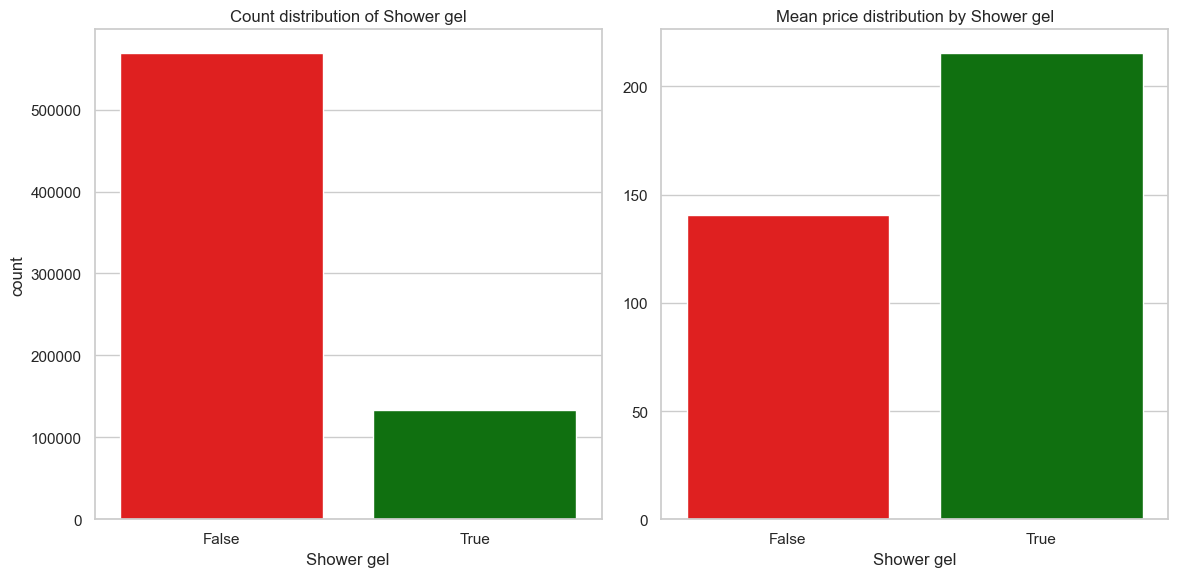

% Wise Split of Shower gel:
Shower gel
False    80.967149
True     19.032851
Name: proportion, dtype: float64

P-value for Shower gel: 0.0
Shower gel is statistically significant (p-value < 0.05)


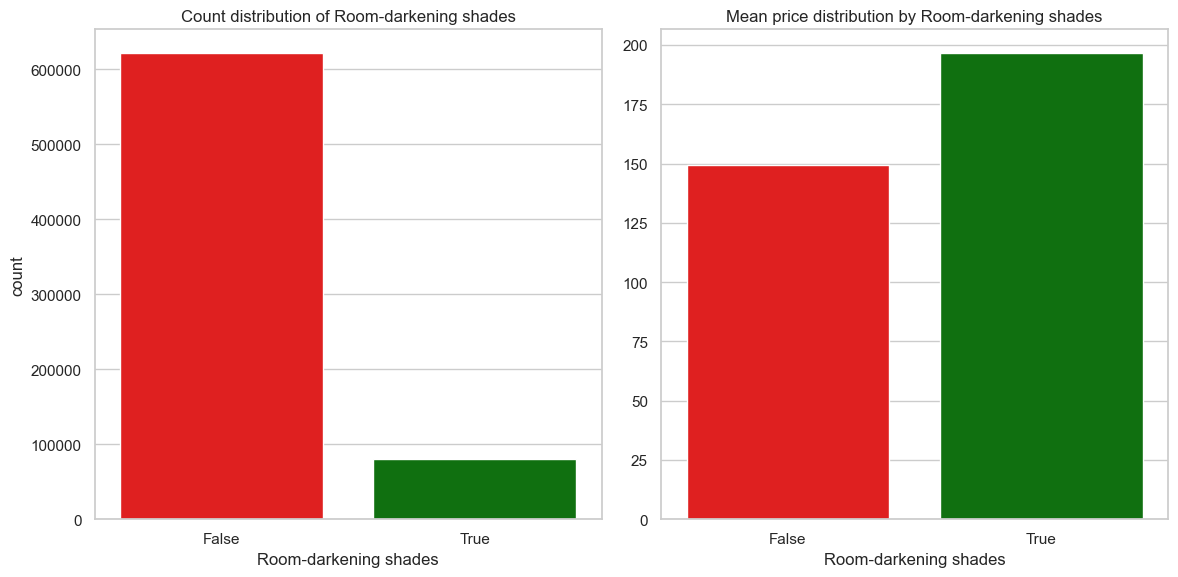

% Wise Split of Room-darkening shades:
Room-darkening shades
False    88.482972
True     11.517028
Name: proportion, dtype: float64

P-value for Room-darkening shades: 0.0
Room-darkening shades is statistically significant (p-value < 0.05)


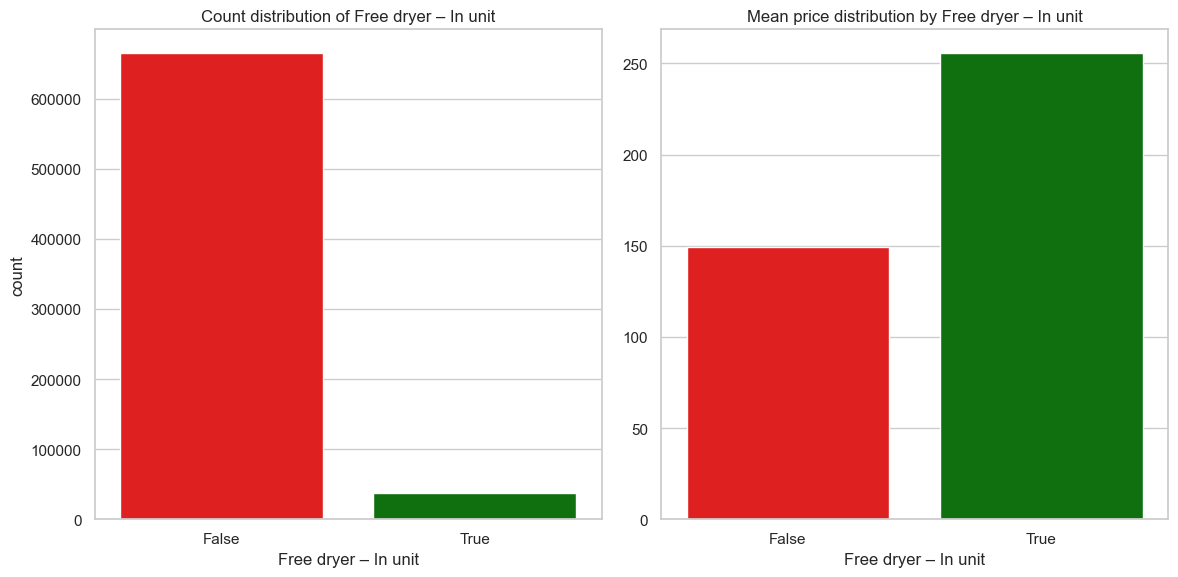

% Wise Split of Free dryer – In unit:
Free dryer – In unit
False    94.645957
True      5.354043
Name: proportion, dtype: float64

P-value for Free dryer – In unit: 0.0
Free dryer – In unit is statistically significant (p-value < 0.05)


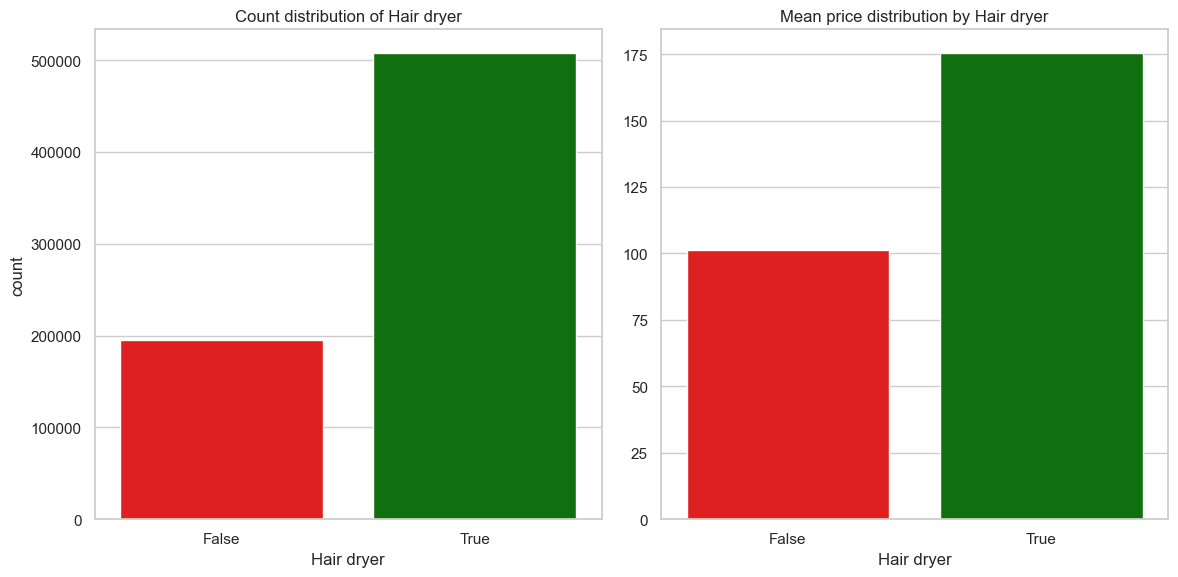

% Wise Split of Hair dryer:
Hair dryer
True     72.236987
False    27.763013
Name: proportion, dtype: float64

P-value for Hair dryer: 0.0
Hair dryer is statistically significant (p-value < 0.05)


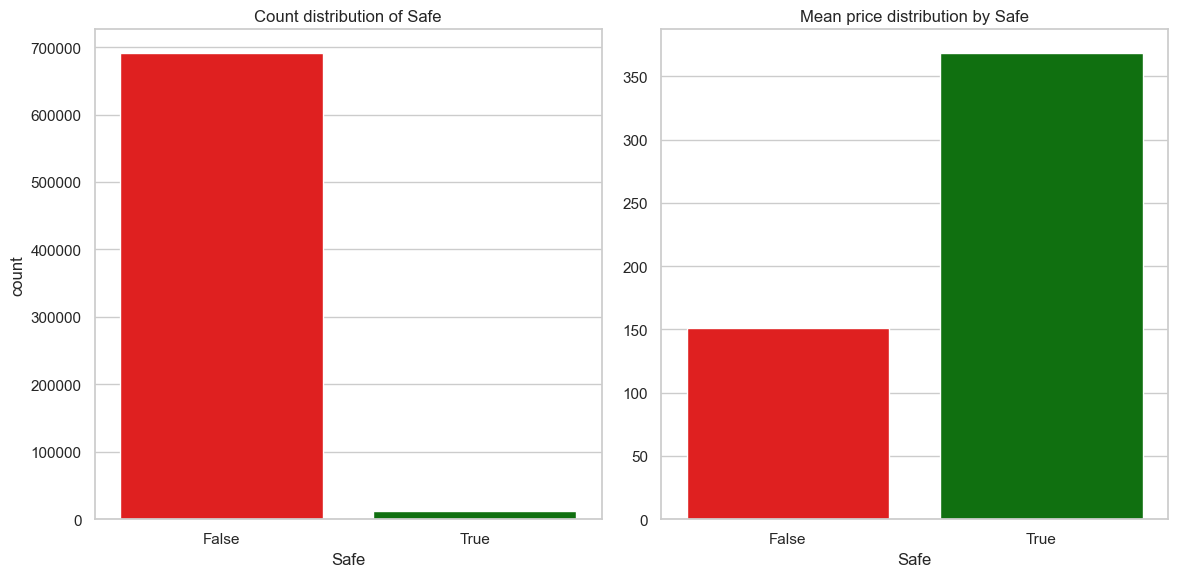

% Wise Split of Safe:
Safe
False    98.340166
True      1.659834
Name: proportion, dtype: float64

P-value for Safe: 0.0
Safe is statistically significant (p-value < 0.05)


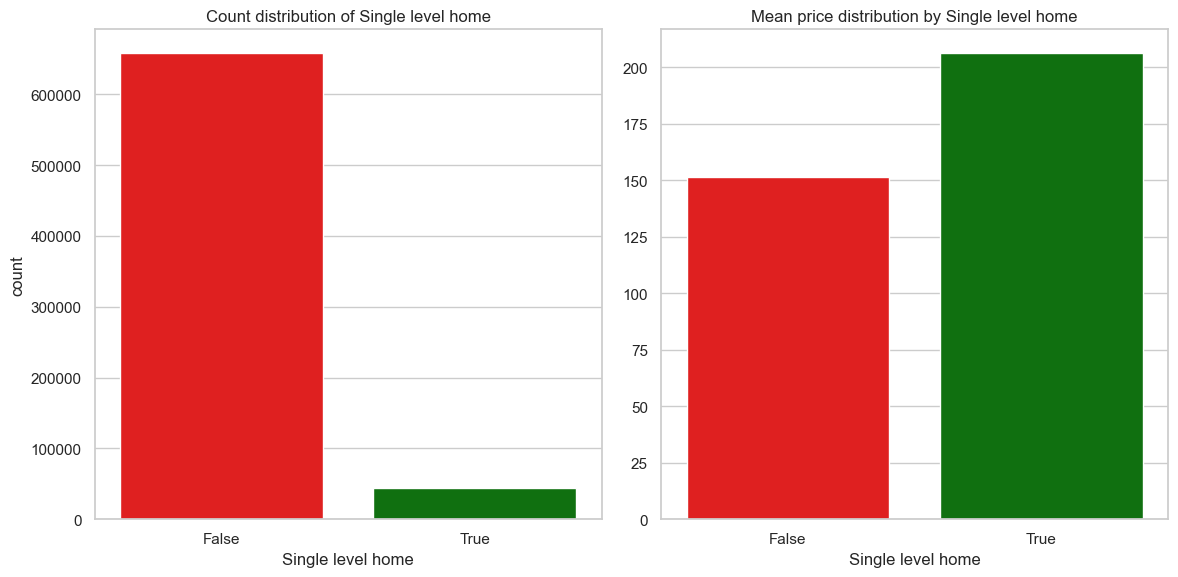

% Wise Split of Single level home:
Single level home
False    93.669225
True      6.330775
Name: proportion, dtype: float64

P-value for Single level home: 0.0
Single level home is statistically significant (p-value < 0.05)


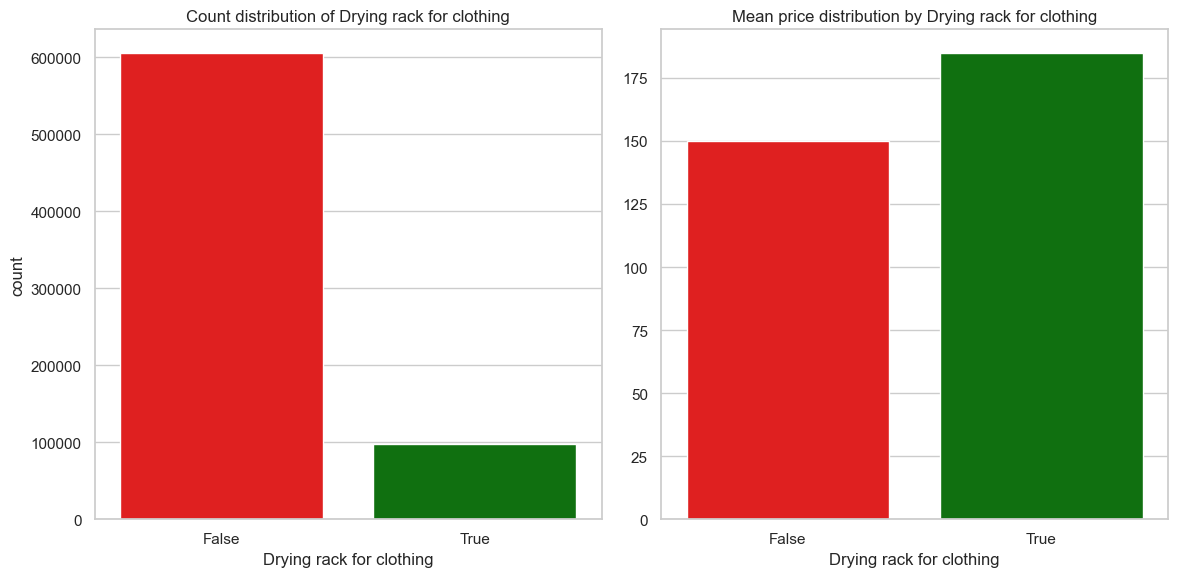

% Wise Split of Drying rack for clothing:
Drying rack for clothing
False    86.178428
True     13.821572
Name: proportion, dtype: float64

P-value for Drying rack for clothing: 0.0
Drying rack for clothing is statistically significant (p-value < 0.05)


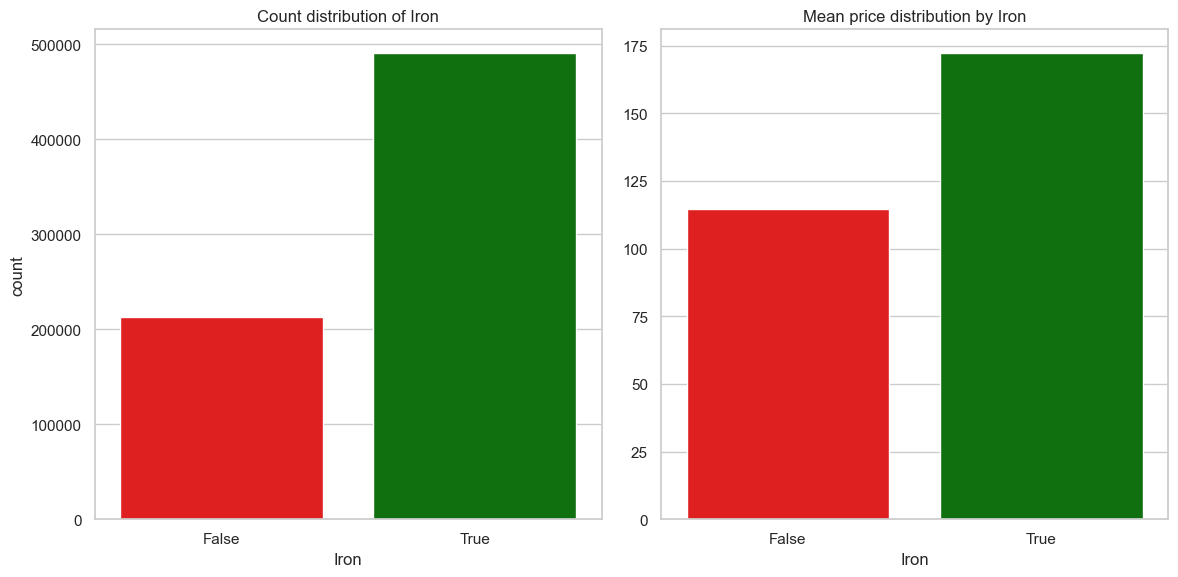

% Wise Split of Iron:
Iron
True     69.796221
False    30.203779
Name: proportion, dtype: float64

P-value for Iron: 0.0
Iron is statistically significant (p-value < 0.05)


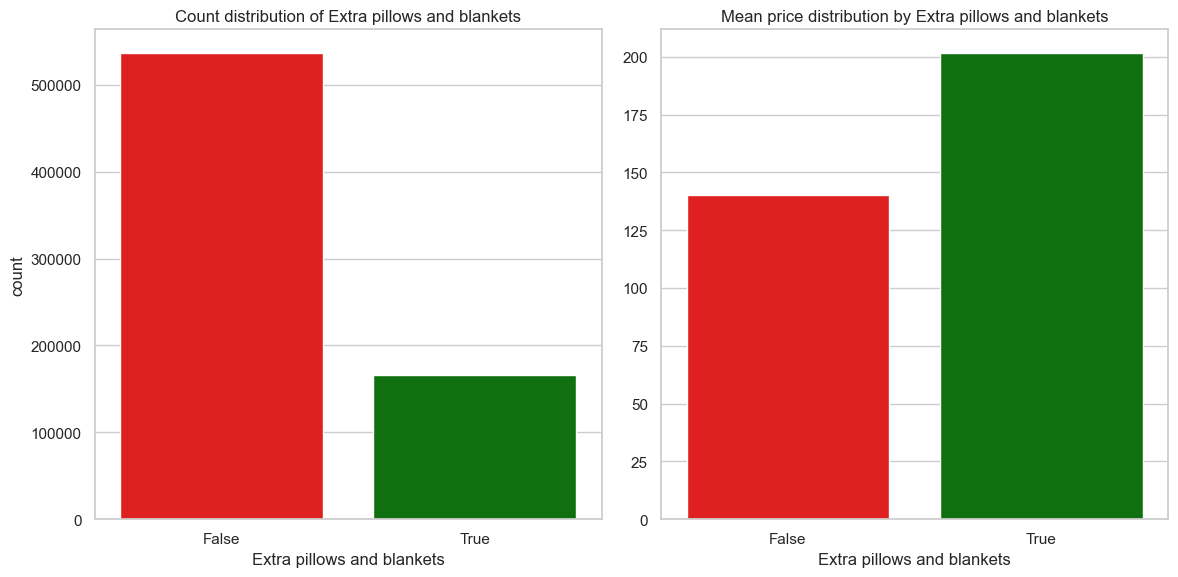

% Wise Split of Extra pillows and blankets:
Extra pillows and blankets
False    76.349815
True     23.650185
Name: proportion, dtype: float64

P-value for Extra pillows and blankets: 0.0
Extra pillows and blankets is statistically significant (p-value < 0.05)


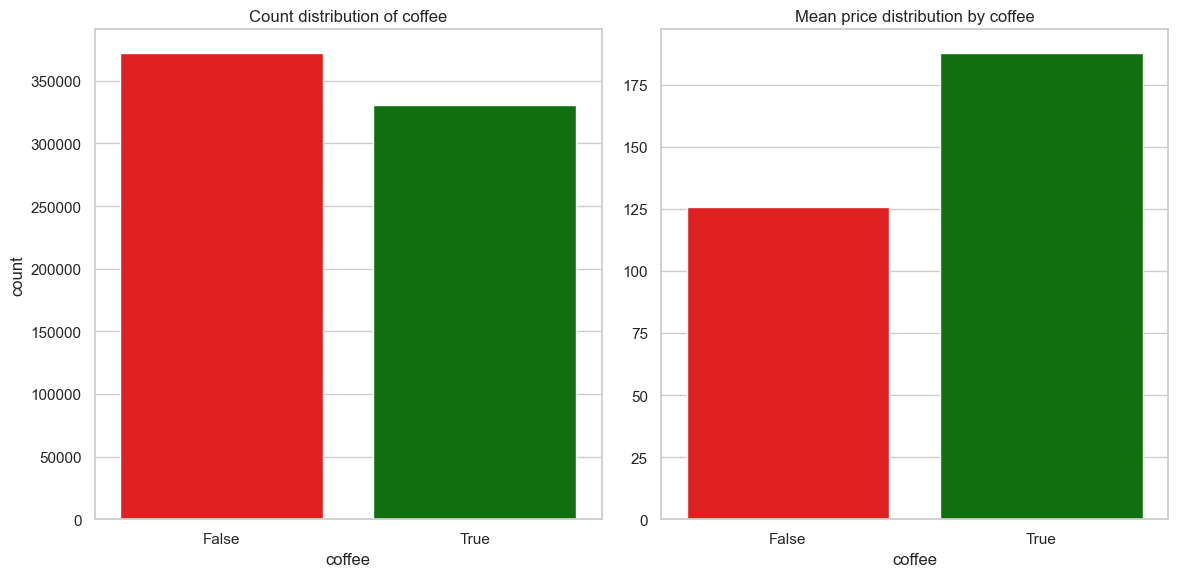

% Wise Split of coffee:
coffee
False    52.95302
True     47.04698
Name: proportion, dtype: float64

P-value for coffee: 0.0
coffee is statistically significant (p-value < 0.05)


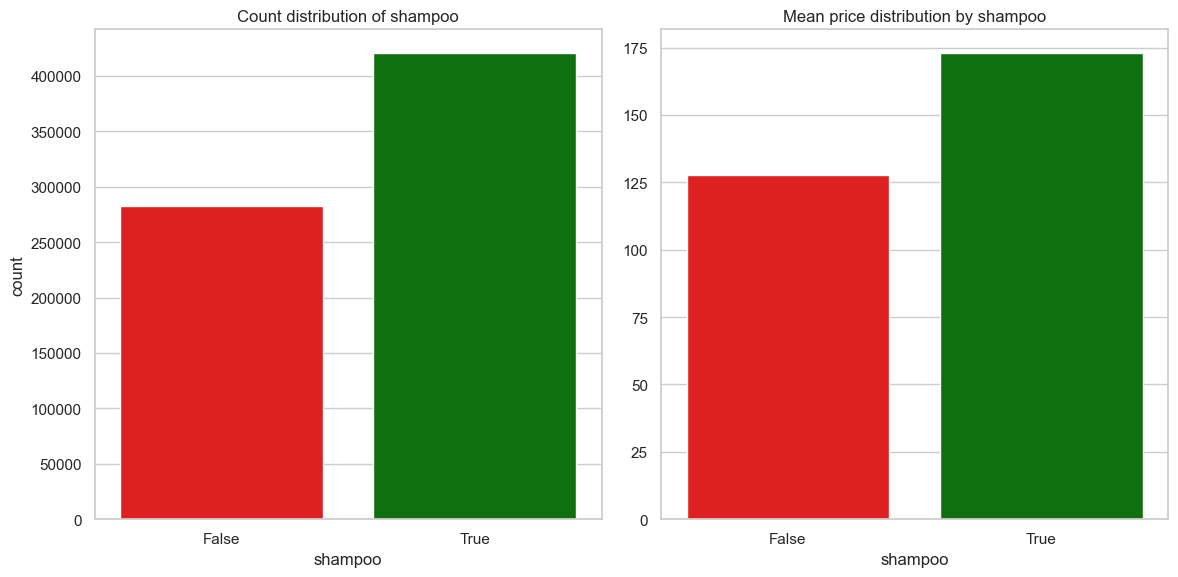

% Wise Split of shampoo:
shampoo
True     59.830248
False    40.169752
Name: proportion, dtype: float64

P-value for shampoo: 0.0
shampoo is statistically significant (p-value < 0.05)


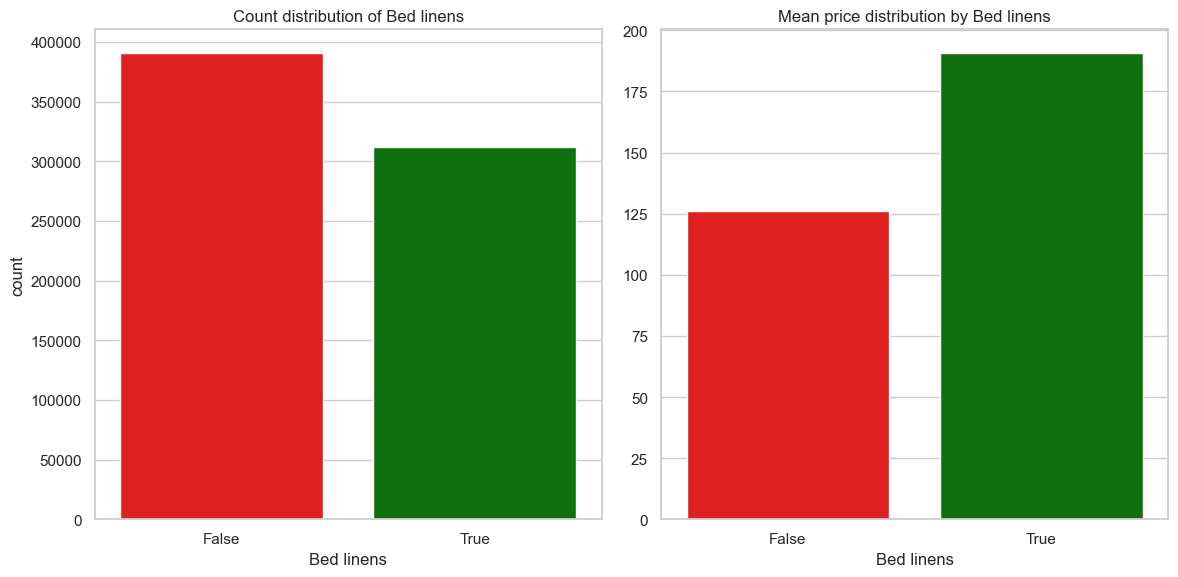

% Wise Split of Bed linens:
Bed linens
False    55.588876
True     44.411124
Name: proportion, dtype: float64

P-value for Bed linens: 0.0
Bed linens is statistically significant (p-value < 0.05)


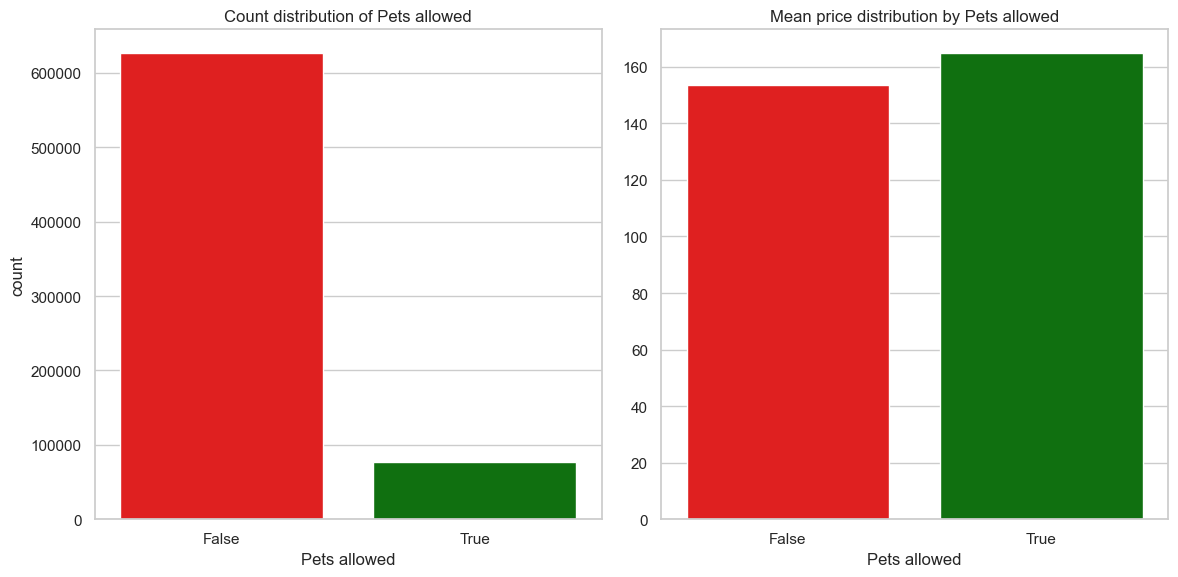

% Wise Split of Pets allowed:
Pets allowed
False    89.149436
True     10.850564
Name: proportion, dtype: float64

P-value for Pets allowed: 1.584933178829133e-69
Pets allowed is statistically significant (p-value < 0.05)


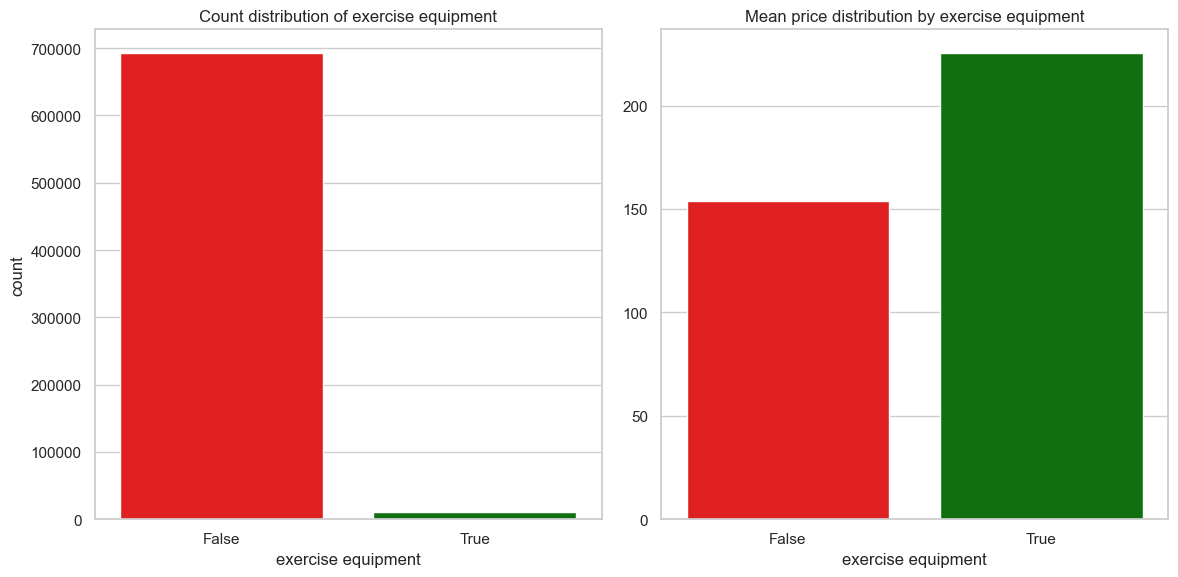

% Wise Split of exercise equipment:
exercise equipment
False    98.567819
True      1.432181
Name: proportion, dtype: float64

P-value for exercise equipment: 7.732600662123378e-255
exercise equipment is statistically significant (p-value < 0.05)


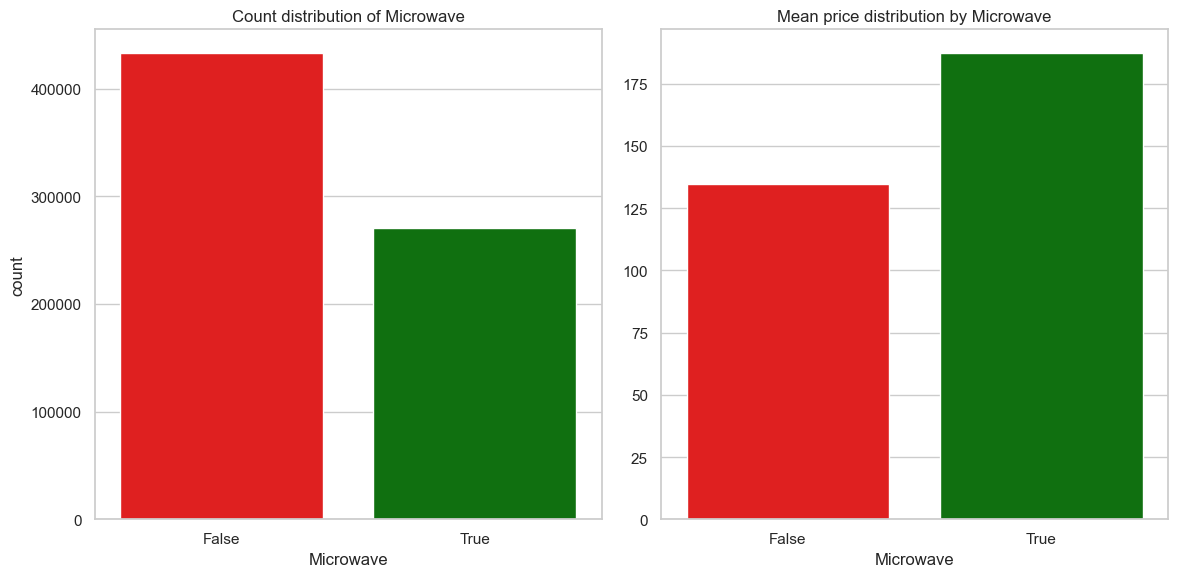

% Wise Split of Microwave:
Microwave
False    61.601847
True     38.398153
Name: proportion, dtype: float64

P-value for Microwave: 0.0
Microwave is statistically significant (p-value < 0.05)


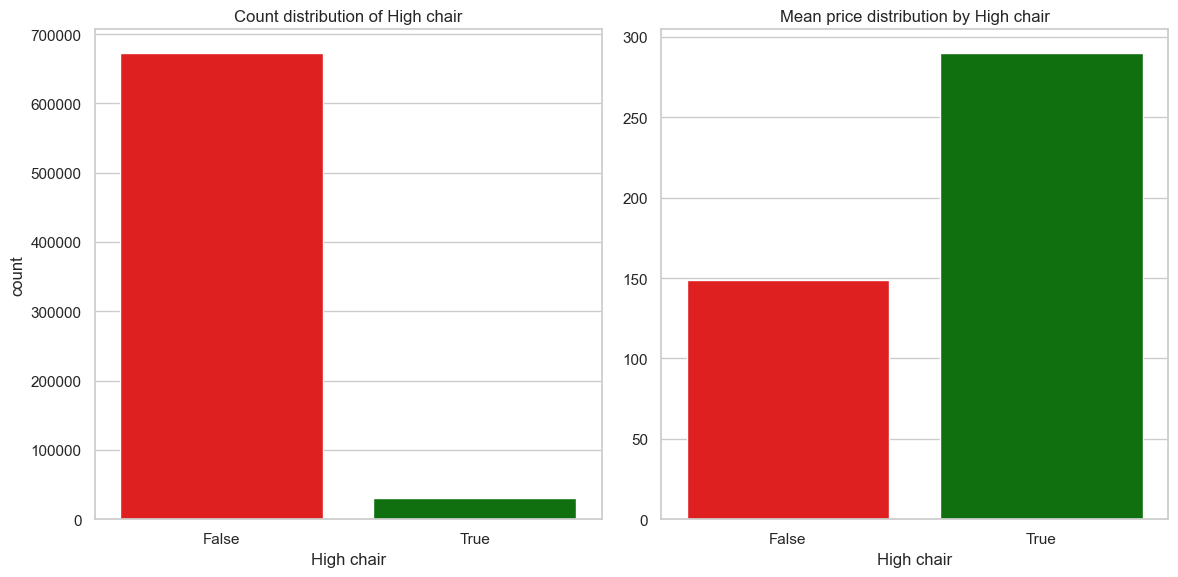

% Wise Split of High chair:
High chair
False    95.703172
True      4.296828
Name: proportion, dtype: float64

P-value for High chair: 0.0
High chair is statistically significant (p-value < 0.05)


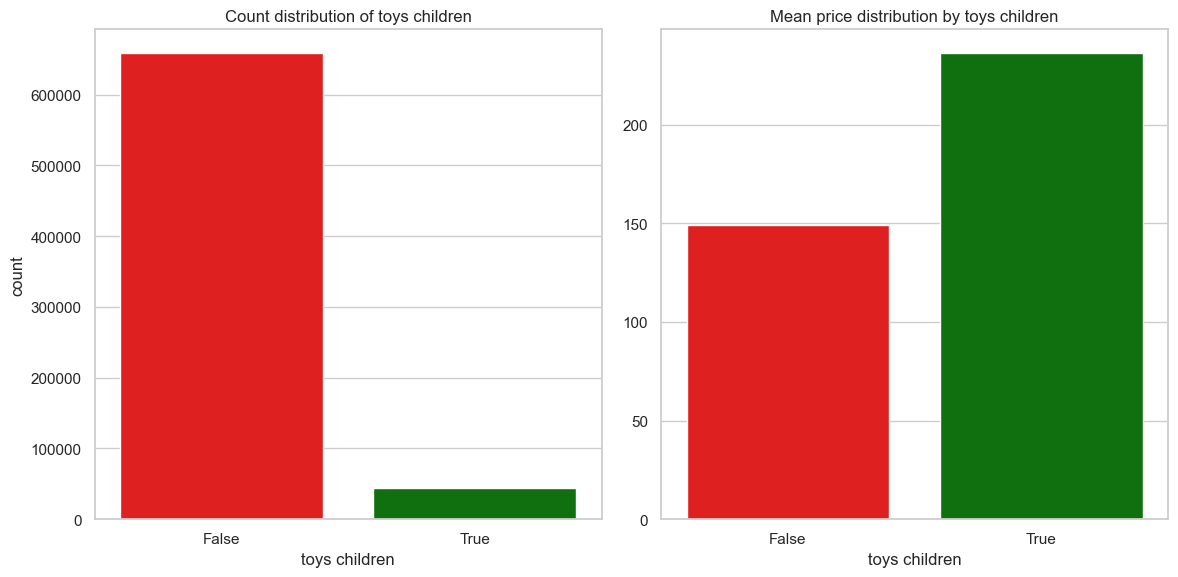

% Wise Split of toys children:
toys children
False    93.721126
True      6.278874
Name: proportion, dtype: float64

P-value for toys children: 0.0
toys children is statistically significant (p-value < 0.05)


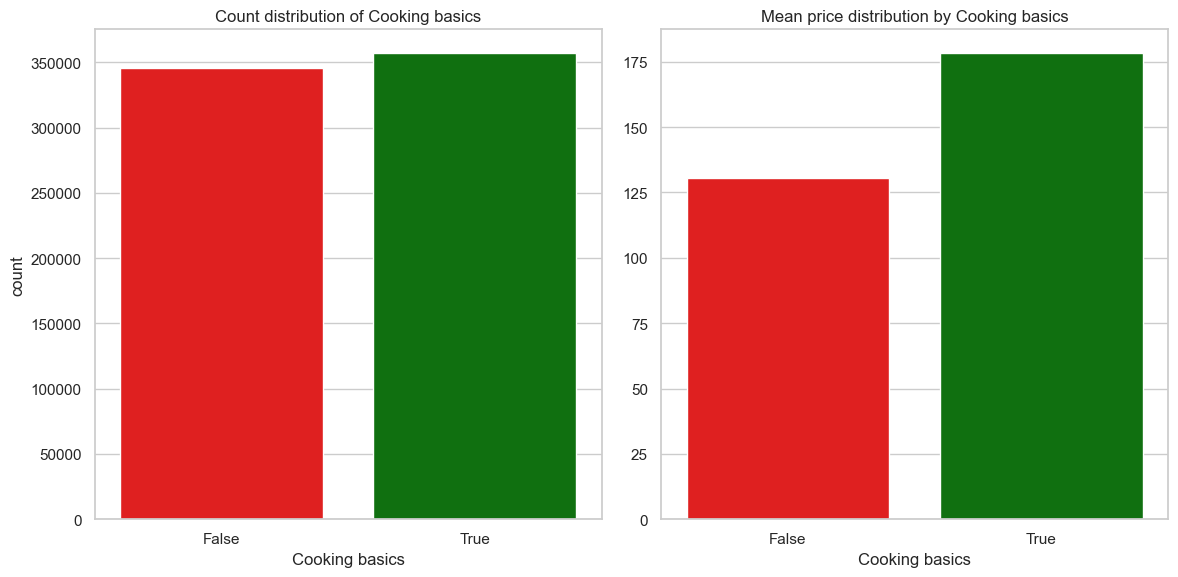

% Wise Split of Cooking basics:
Cooking basics
True     50.807877
False    49.192123
Name: proportion, dtype: float64

P-value for Cooking basics: 0.0
Cooking basics is statistically significant (p-value < 0.05)


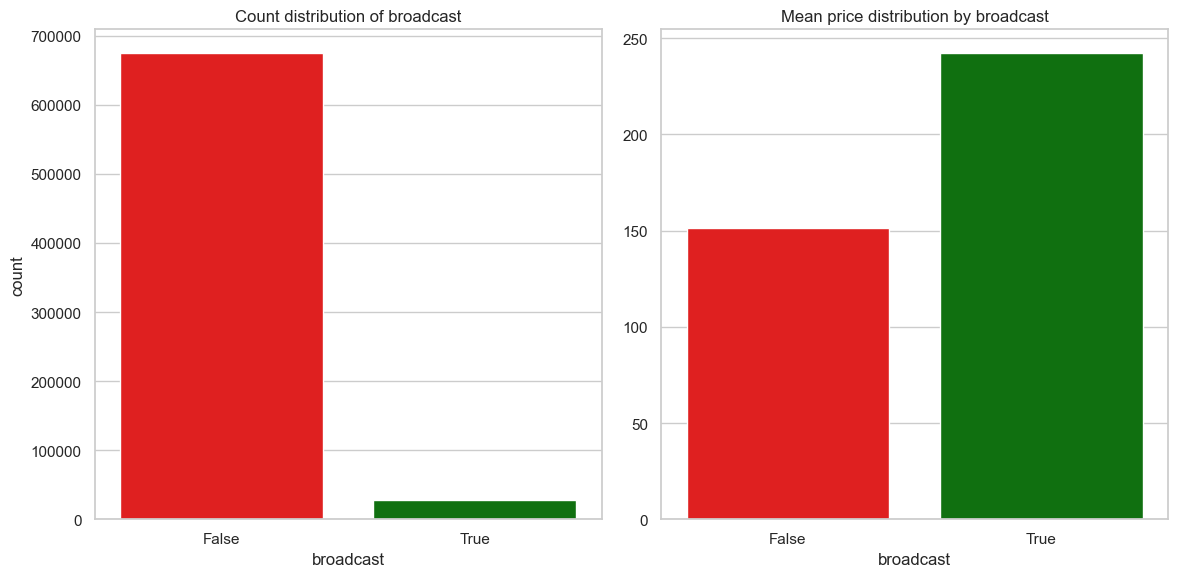

% Wise Split of broadcast:
broadcast
False    96.026096
True      3.973904
Name: proportion, dtype: float64

P-value for broadcast: 0.0
broadcast is statistically significant (p-value < 0.05)


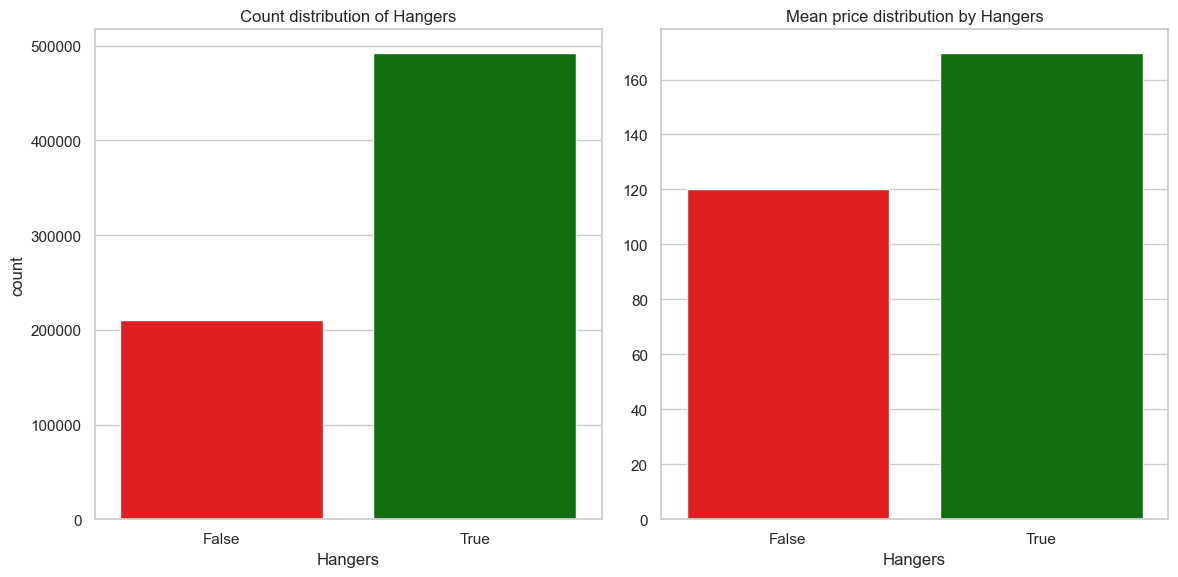

% Wise Split of Hangers:
Hangers
True     70.023021
False    29.976979
Name: proportion, dtype: float64

P-value for Hangers: 0.0
Hangers is statistically significant (p-value < 0.05)


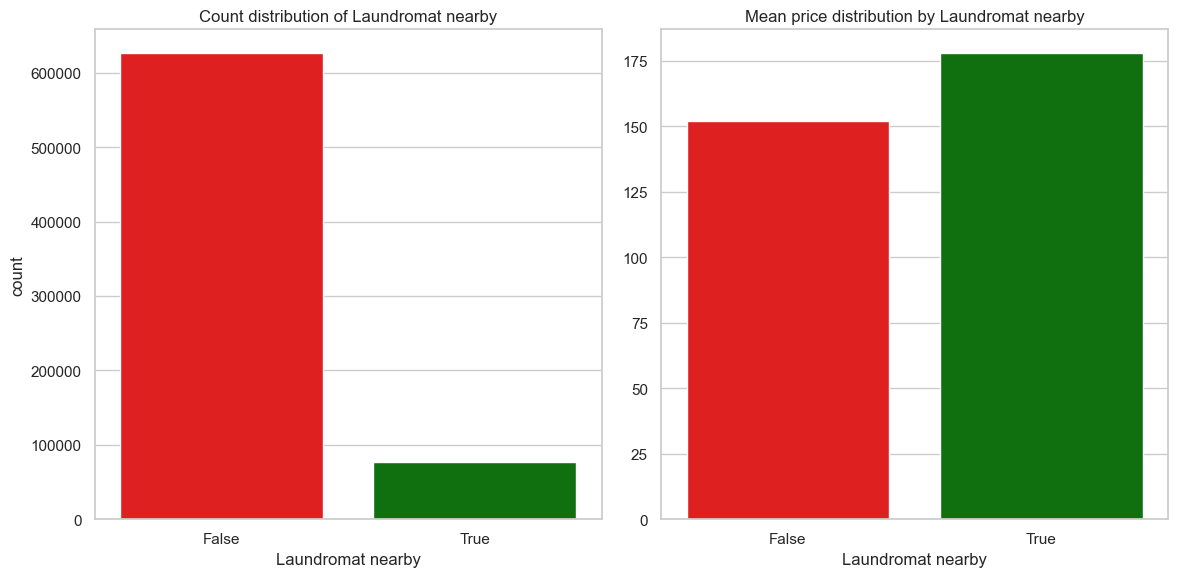

% Wise Split of Laundromat nearby:
Laundromat nearby
False    89.155977
True     10.844023
Name: proportion, dtype: float64

P-value for Laundromat nearby: 0.0
Laundromat nearby is statistically significant (p-value < 0.05)


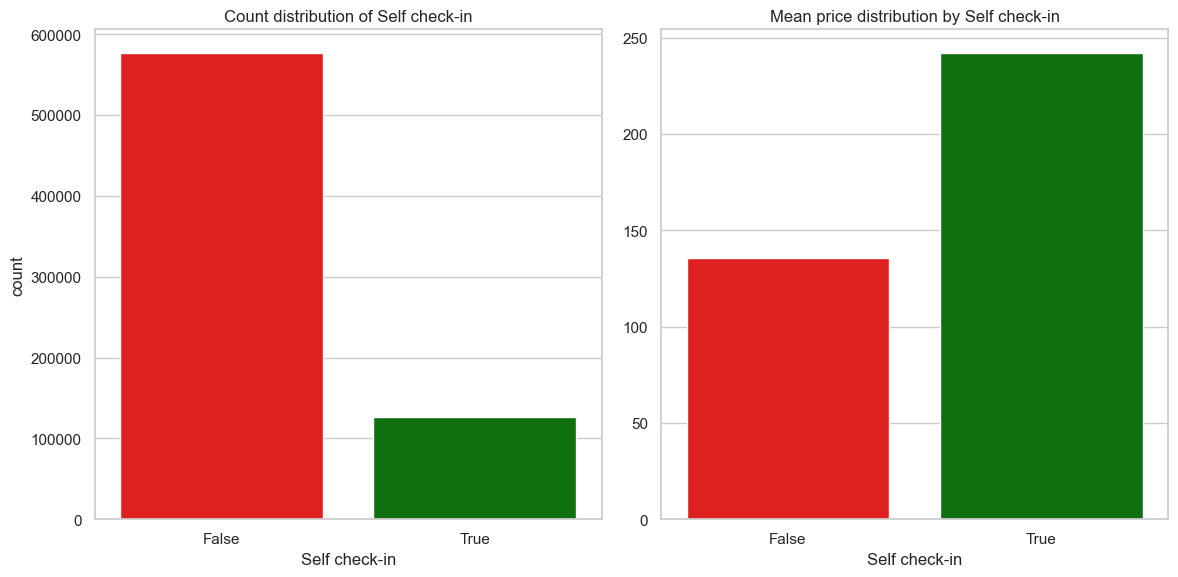

% Wise Split of Self check-in:
Self check-in
False    82.031473
True     17.968527
Name: proportion, dtype: float64

P-value for Self check-in: 0.0
Self check-in is statistically significant (p-value < 0.05)


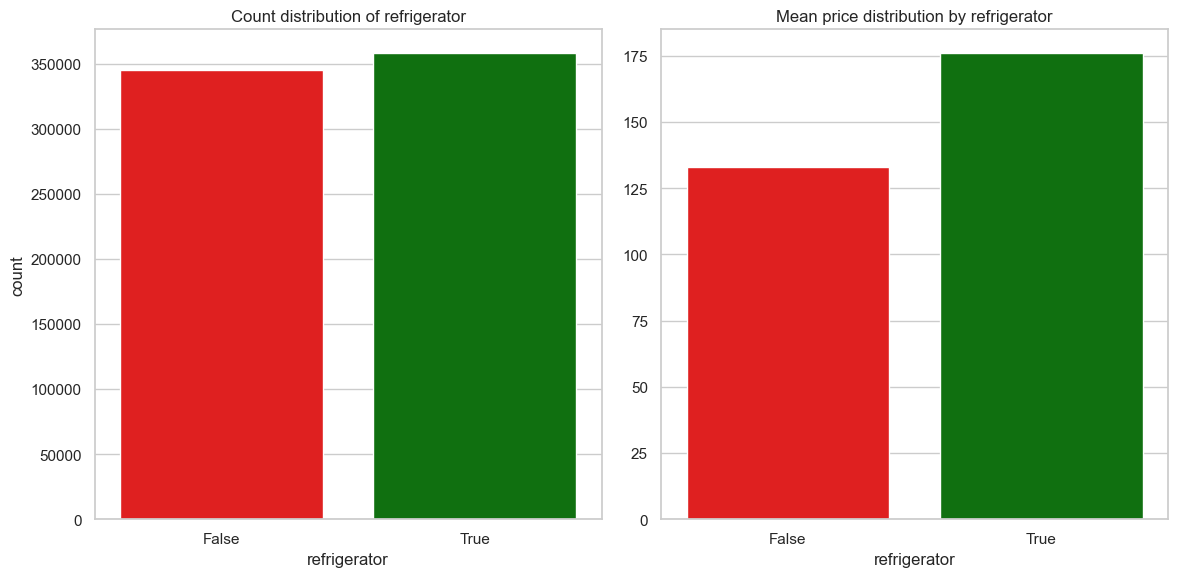

% Wise Split of refrigerator:
refrigerator
True     50.951635
False    49.048365
Name: proportion, dtype: float64

P-value for refrigerator: 0.0
refrigerator is statistically significant (p-value < 0.05)


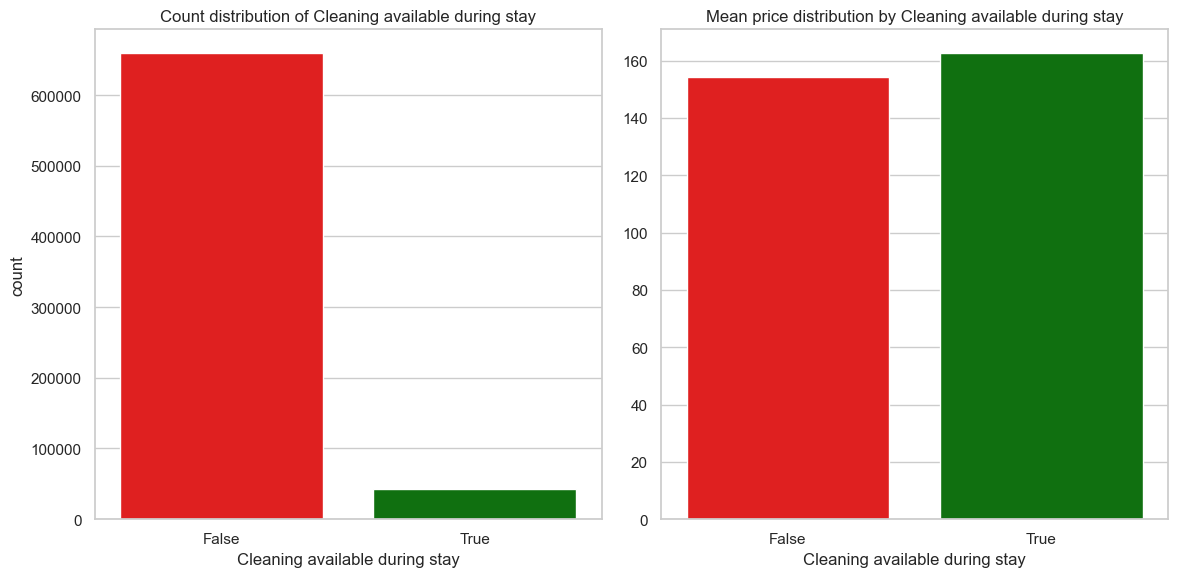

% Wise Split of Cleaning available during stay:
Cleaning available during stay
False    93.848816
True      6.151184
Name: proportion, dtype: float64

P-value for Cleaning available during stay: 7.251039933230068e-22
Cleaning available during stay is statistically significant (p-value < 0.05)


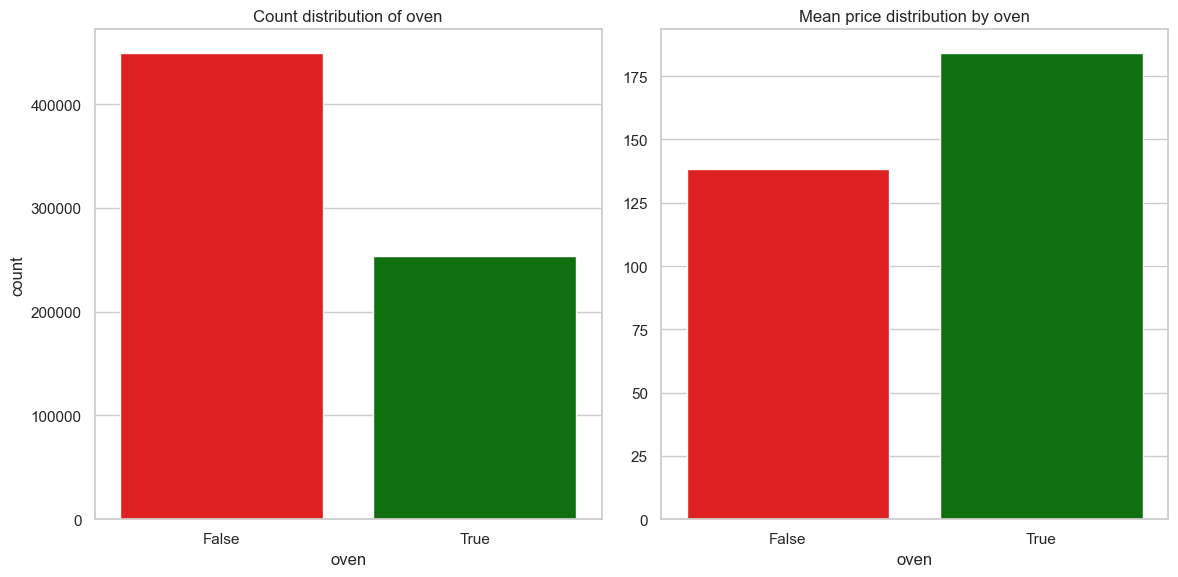

% Wise Split of oven:
oven
False    63.920183
True     36.079817
Name: proportion, dtype: float64

P-value for oven: 0.0
oven is statistically significant (p-value < 0.05)


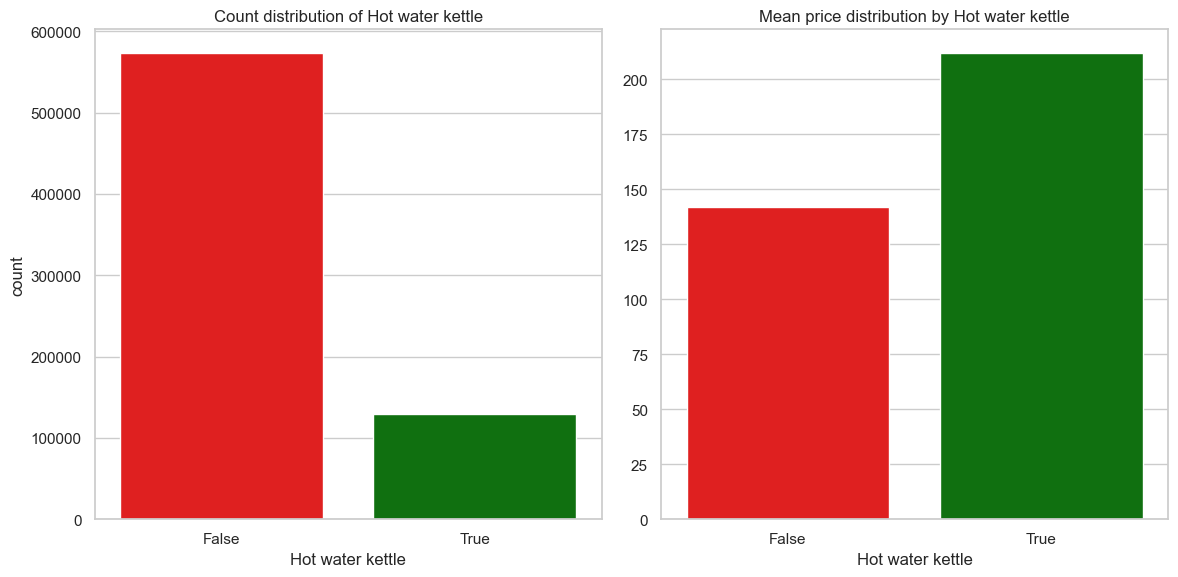

% Wise Split of Hot water kettle:
Hot water kettle
False    81.546306
True     18.453694
Name: proportion, dtype: float64

P-value for Hot water kettle: 0.0
Hot water kettle is statistically significant (p-value < 0.05)


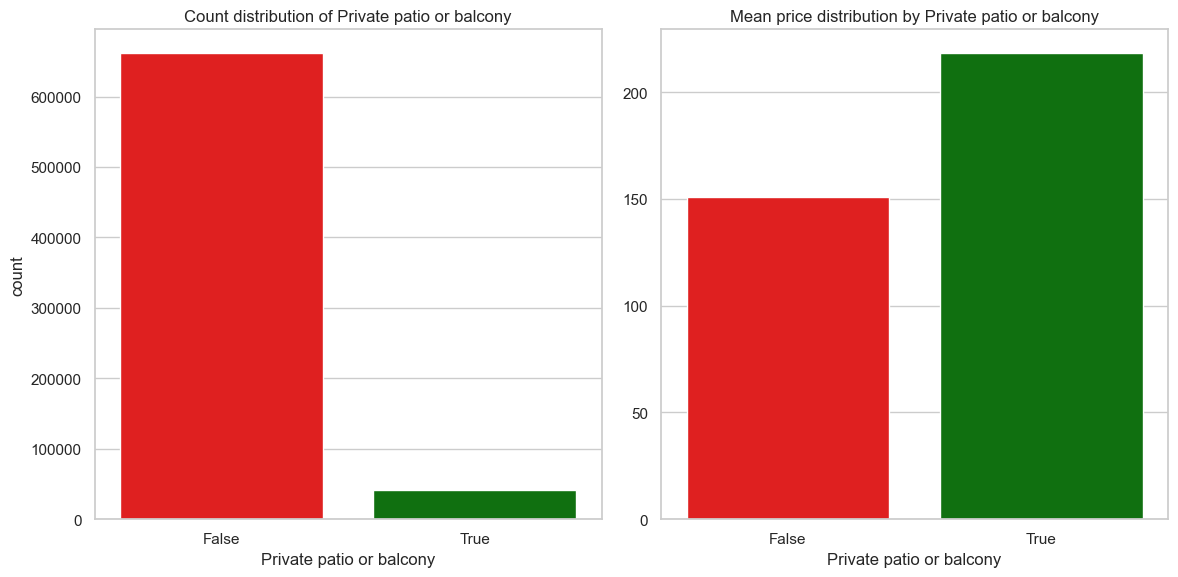

% Wise Split of Private patio or balcony:
Private patio or balcony
False    94.160364
True      5.839636
Name: proportion, dtype: float64

P-value for Private patio or balcony: 0.0
Private patio or balcony is statistically significant (p-value < 0.05)


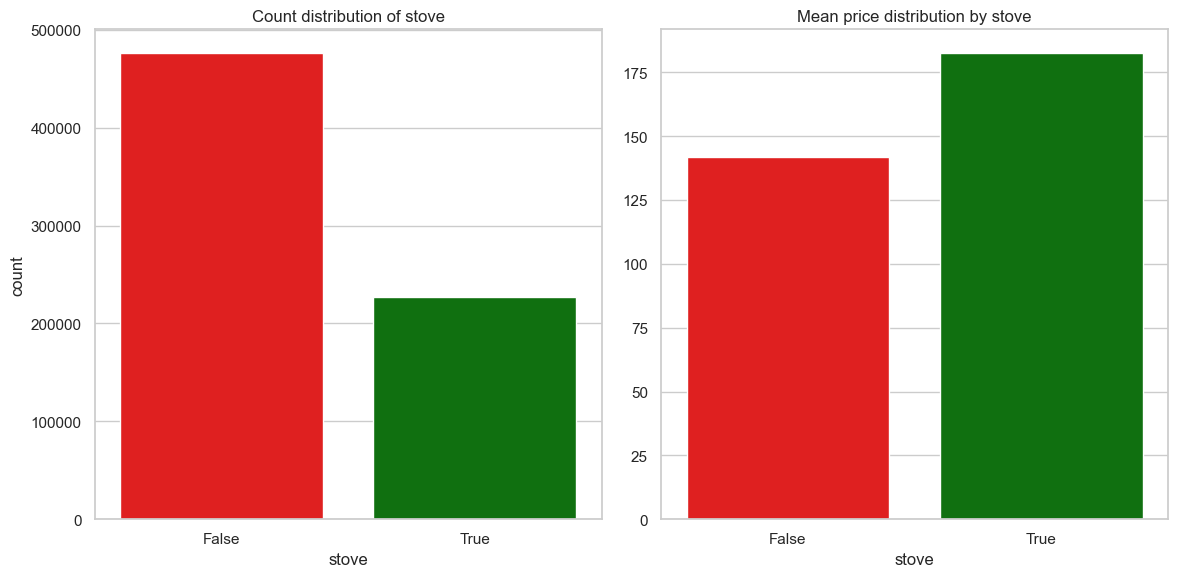

% Wise Split of stove:
stove
False    67.75488
True     32.24512
Name: proportion, dtype: float64

P-value for stove: 0.0
stove is statistically significant (p-value < 0.05)


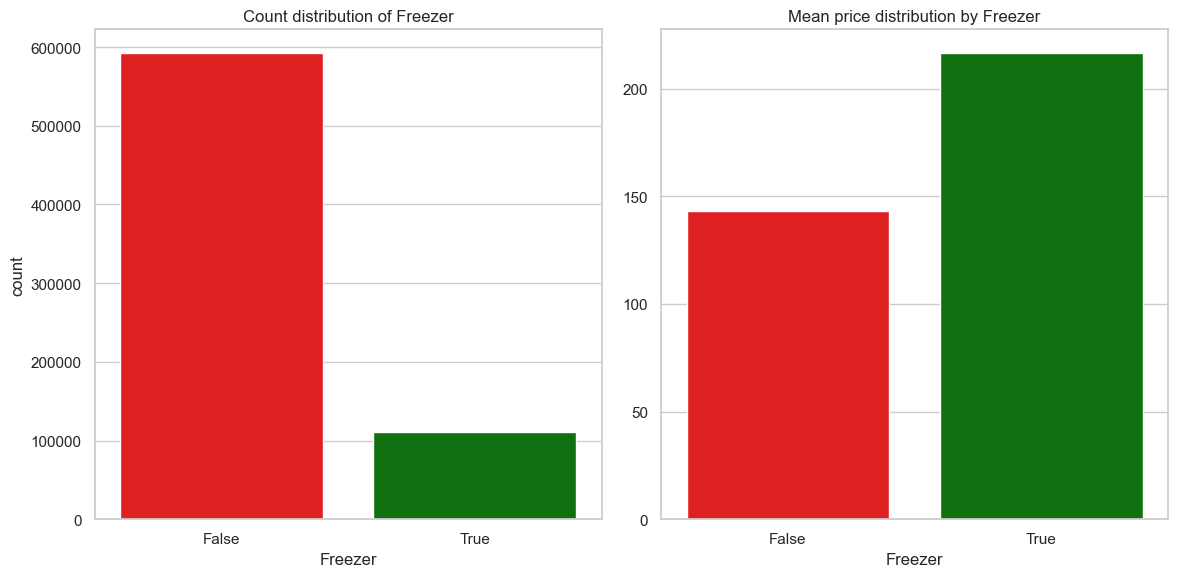

% Wise Split of Freezer:
Freezer
False    84.297624
True     15.702376
Name: proportion, dtype: float64

P-value for Freezer: 0.0
Freezer is statistically significant (p-value < 0.05)


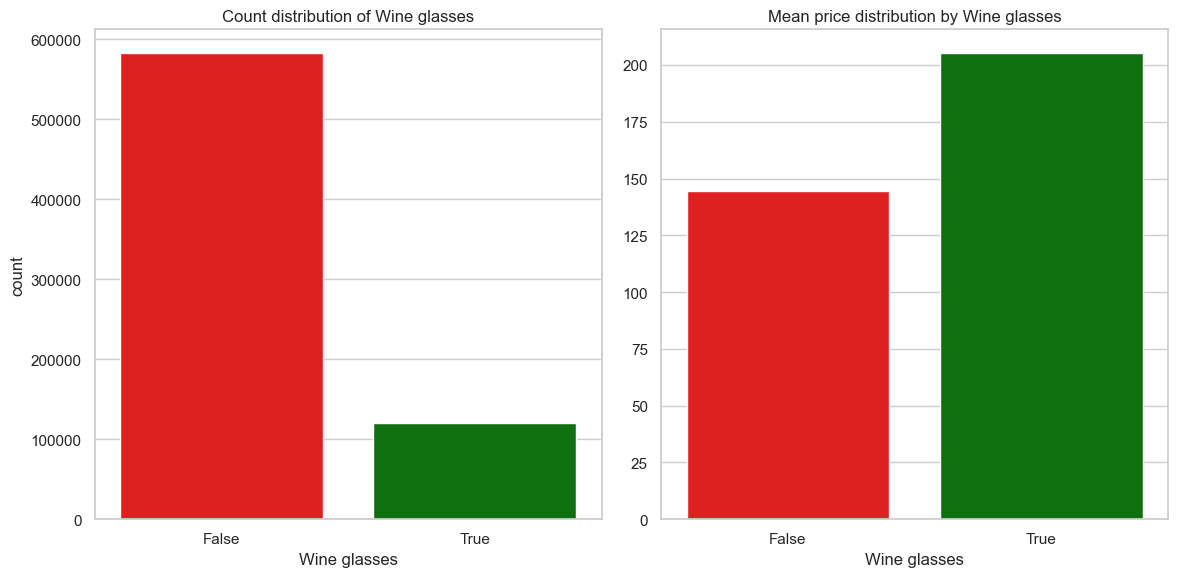

% Wise Split of Wine glasses:
Wine glasses
False    82.936114
True     17.063886
Name: proportion, dtype: float64

P-value for Wine glasses: 0.0
Wine glasses is statistically significant (p-value < 0.05)


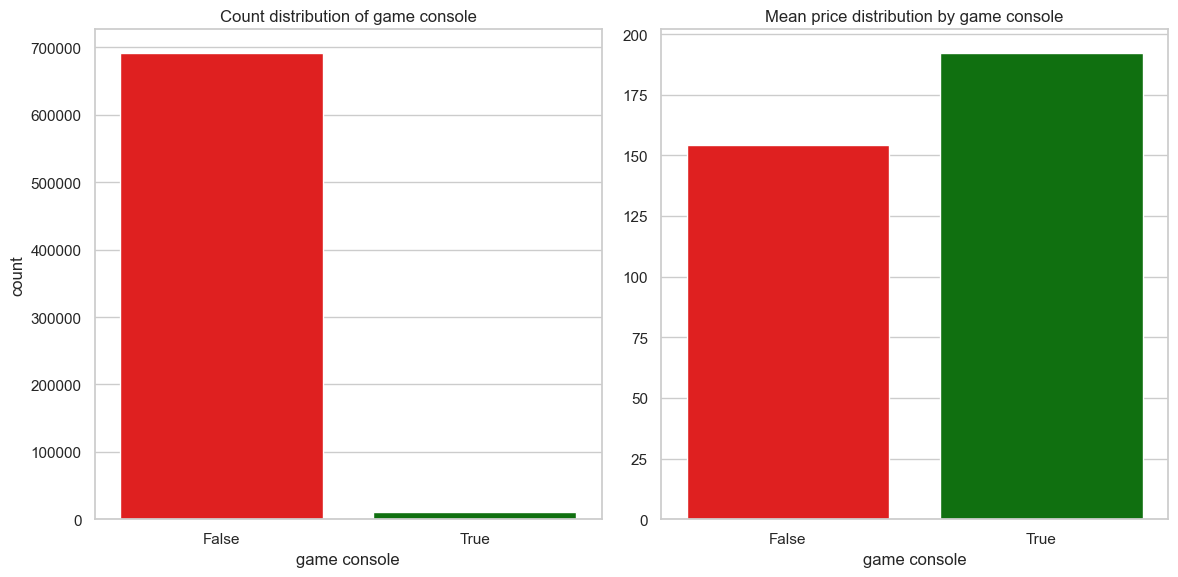

% Wise Split of game console:
game console
False    98.413396
True      1.586604
Name: proportion, dtype: float64

P-value for game console: 1.3769962232020757e-120
game console is statistically significant (p-value < 0.05)


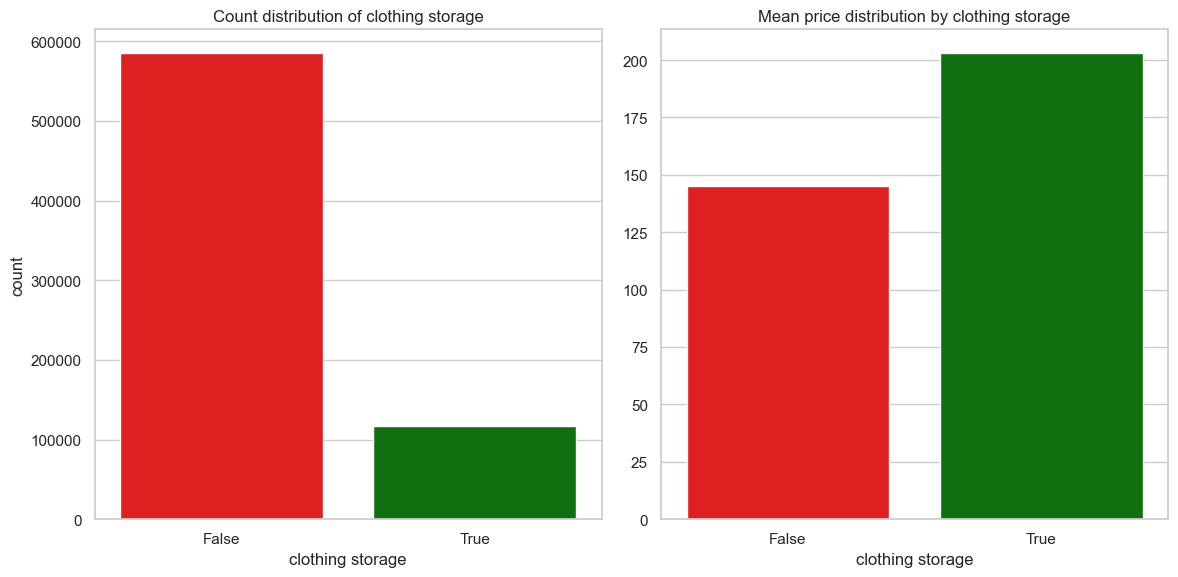

% Wise Split of clothing storage:
clothing storage
False    83.277664
True     16.722336
Name: proportion, dtype: float64

P-value for clothing storage: 0.0
clothing storage is statistically significant (p-value < 0.05)


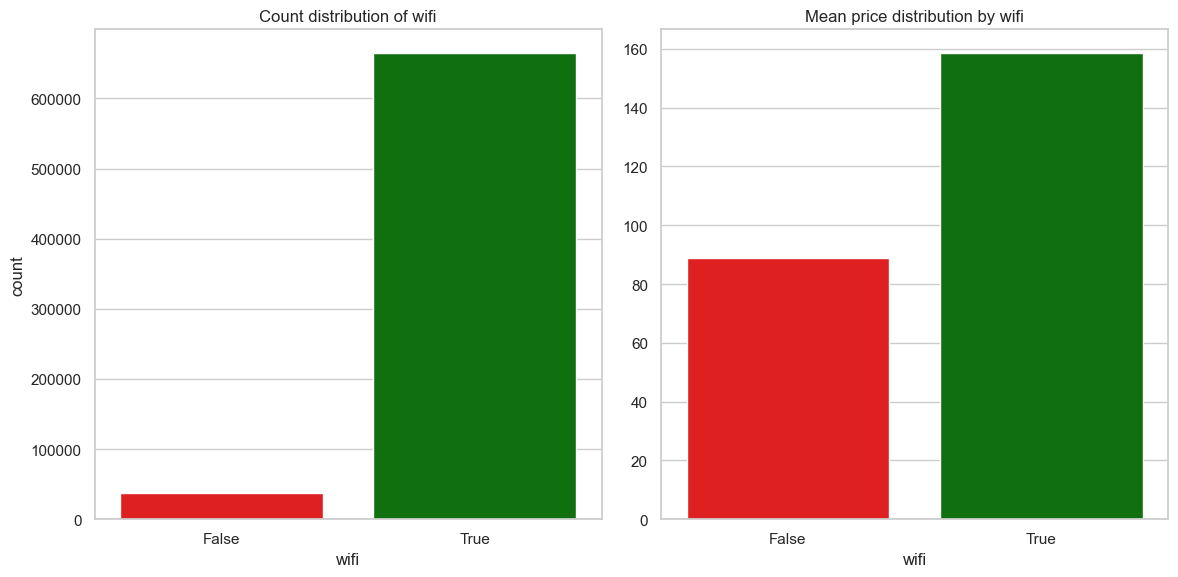

% Wise Split of wifi:
wifi
True     94.585383
False     5.414617
Name: proportion, dtype: float64

P-value for wifi: 0.0
wifi is statistically significant (p-value < 0.05)


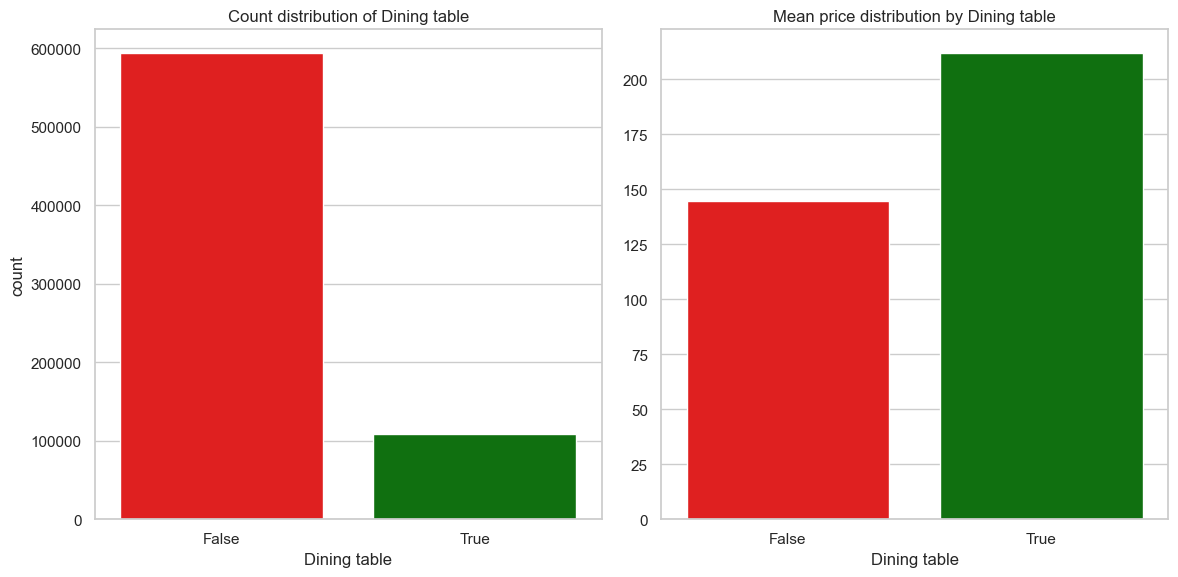

% Wise Split of Dining table:
Dining table
False    84.488591
True     15.511409
Name: proportion, dtype: float64

P-value for Dining table: 0.0
Dining table is statistically significant (p-value < 0.05)


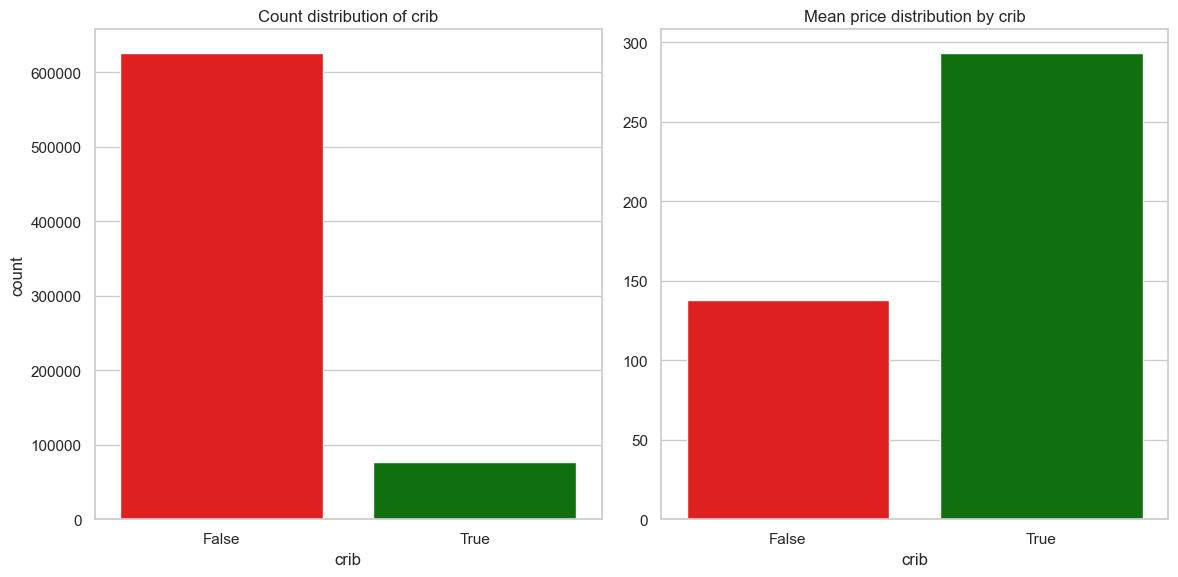

% Wise Split of crib:
crib
False    89.048478
True     10.951522
Name: proportion, dtype: float64

P-value for crib: 0.0
crib is statistically significant (p-value < 0.05)


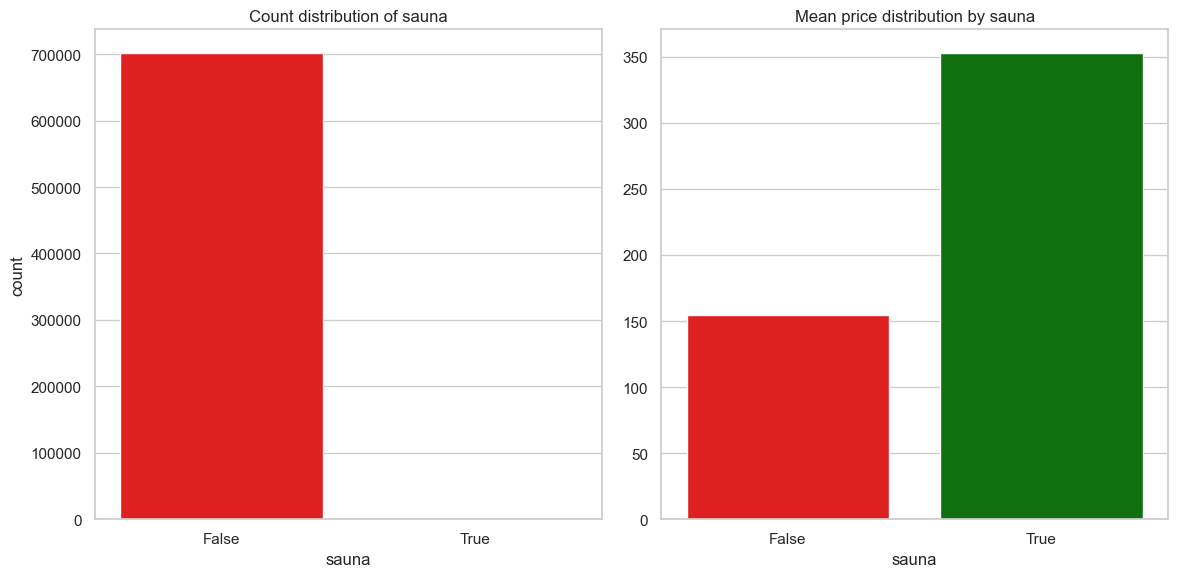

% Wise Split of sauna:
sauna
False    99.843302
True      0.156698
Name: proportion, dtype: float64

P-value for sauna: 7.054883762775543e-122
sauna is statistically significant (p-value < 0.05)


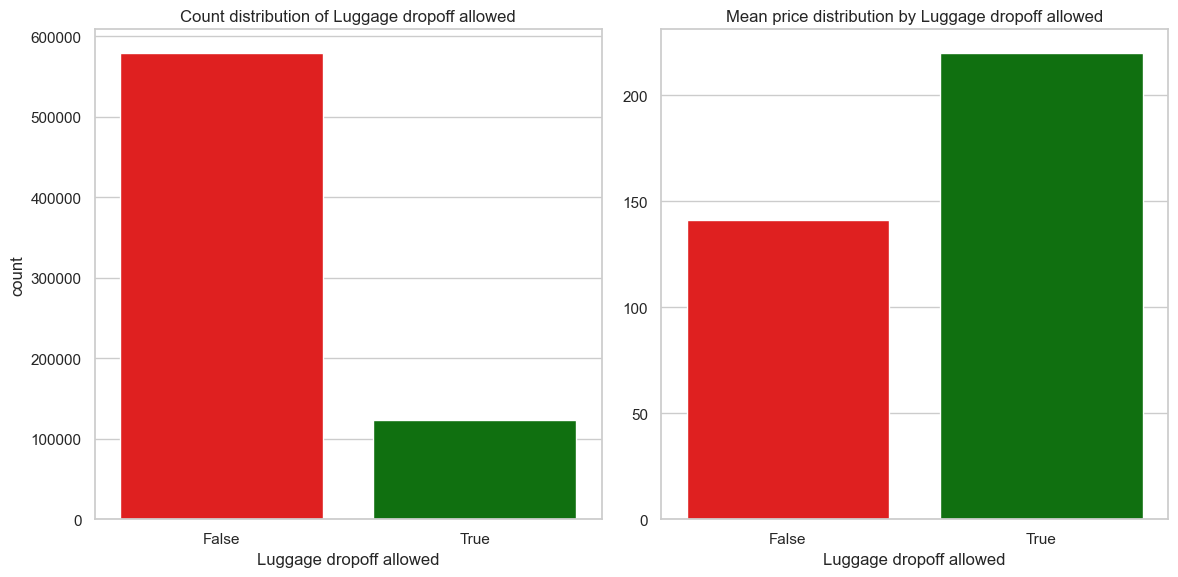

% Wise Split of Luggage dropoff allowed:
Luggage dropoff allowed
False    82.394922
True     17.605078
Name: proportion, dtype: float64

P-value for Luggage dropoff allowed: 0.0
Luggage dropoff allowed is statistically significant (p-value < 0.05)


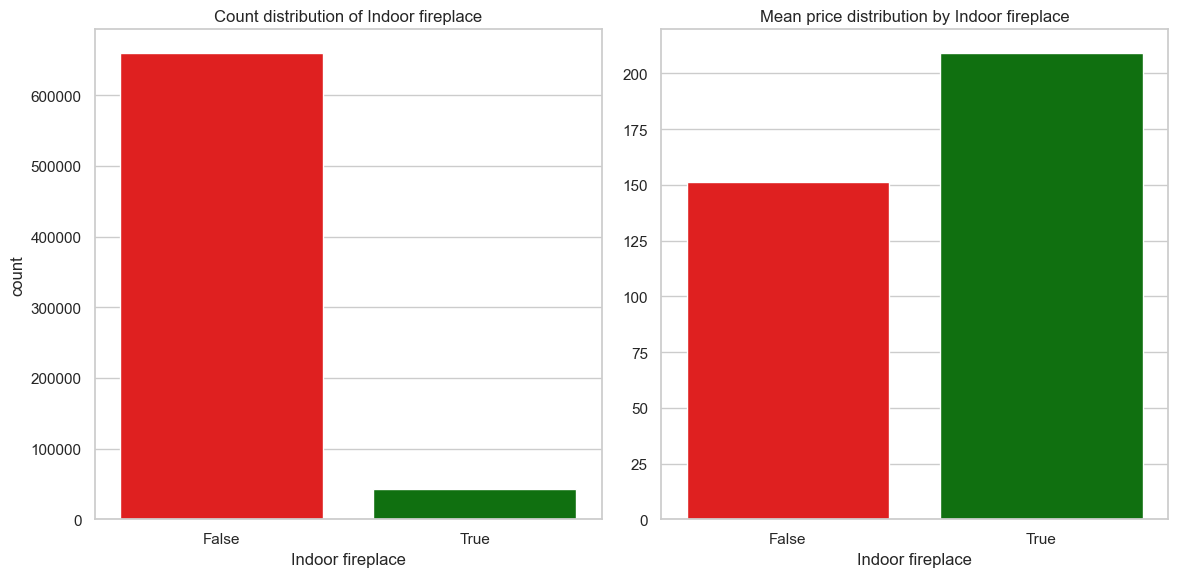

% Wise Split of Indoor fireplace:
Indoor fireplace
False    93.849954
True      6.150046
Name: proportion, dtype: float64

P-value for Indoor fireplace: 0.0
Indoor fireplace is statistically significant (p-value < 0.05)


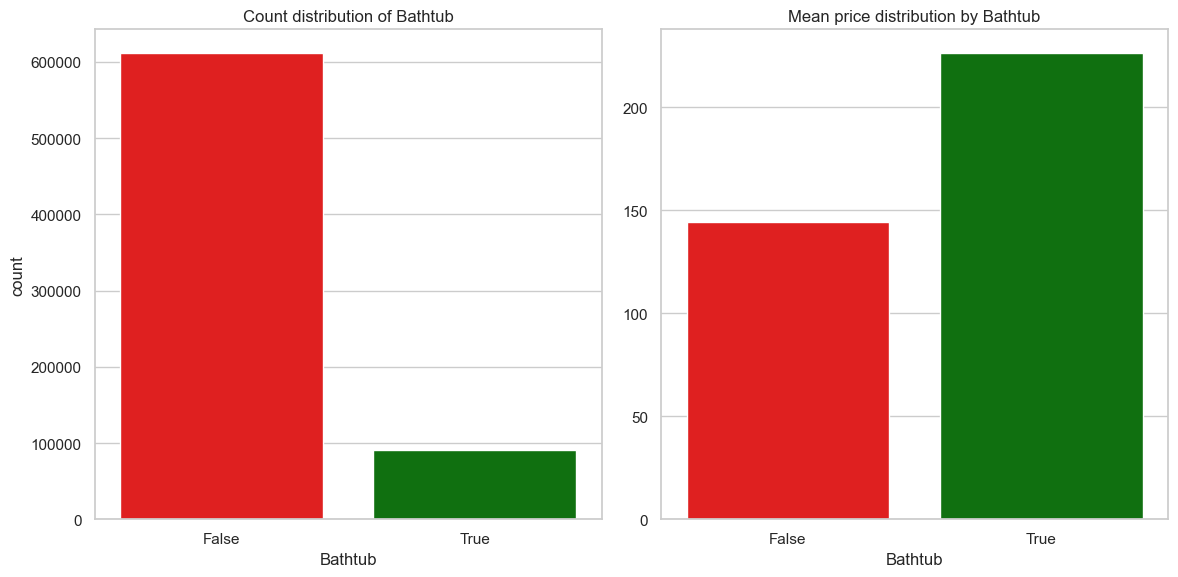

% Wise Split of Bathtub:
Bathtub
False    87.029888
True     12.970112
Name: proportion, dtype: float64

P-value for Bathtub: 0.0
Bathtub is statistically significant (p-value < 0.05)


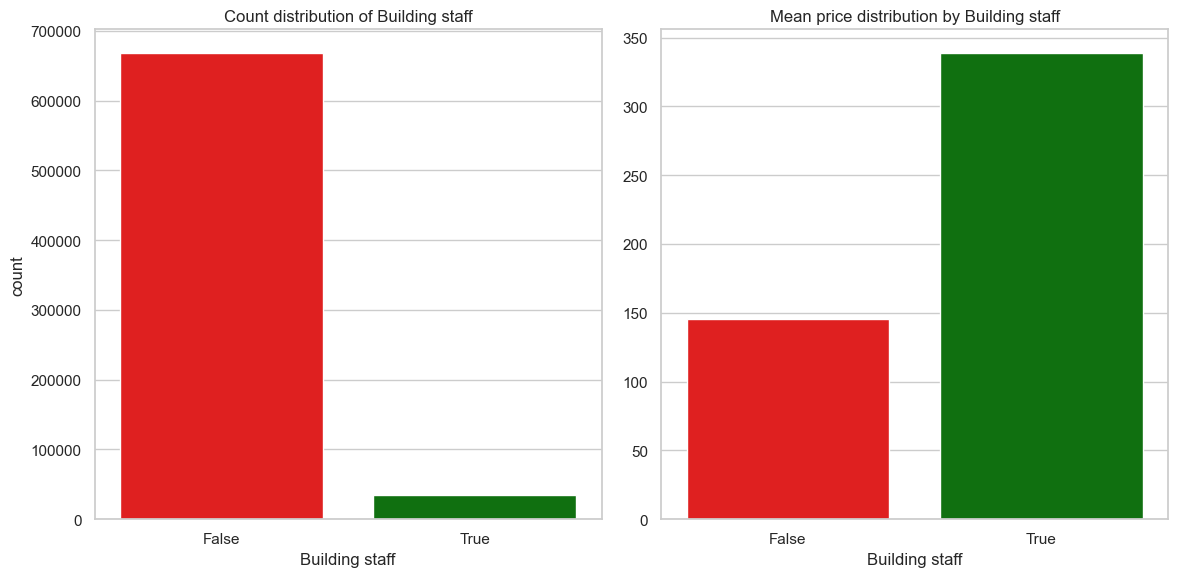

% Wise Split of Building staff:
Building staff
False    95.09586
True      4.90414
Name: proportion, dtype: float64

P-value for Building staff: 0.0
Building staff is statistically significant (p-value < 0.05)


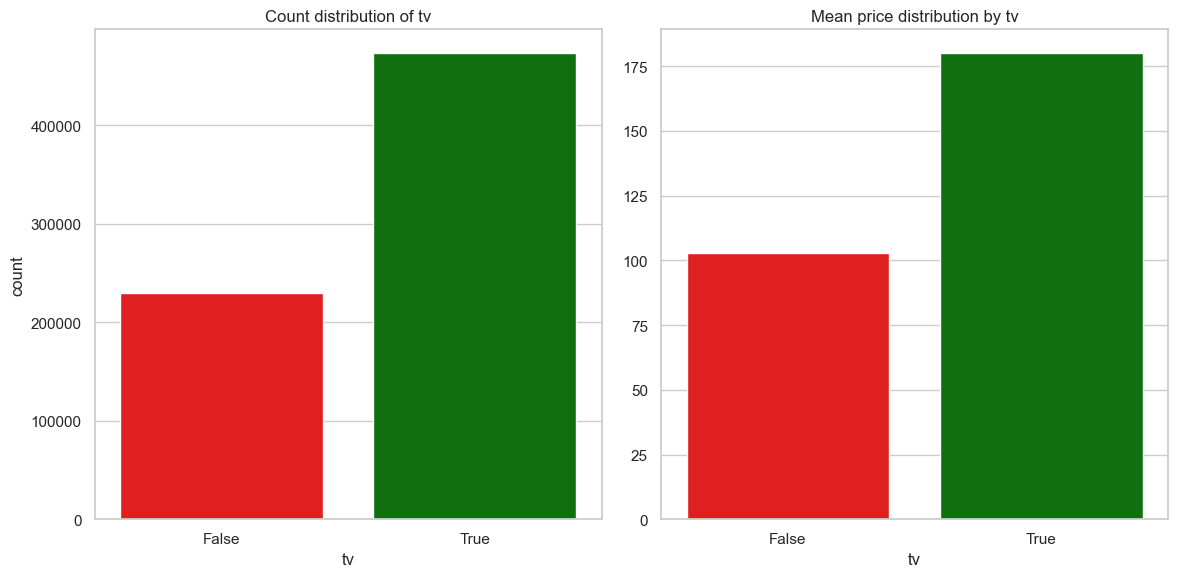

% Wise Split of tv:
tv
True     67.335264
False    32.664736
Name: proportion, dtype: float64

P-value for tv: 0.0
tv is statistically significant (p-value < 0.05)


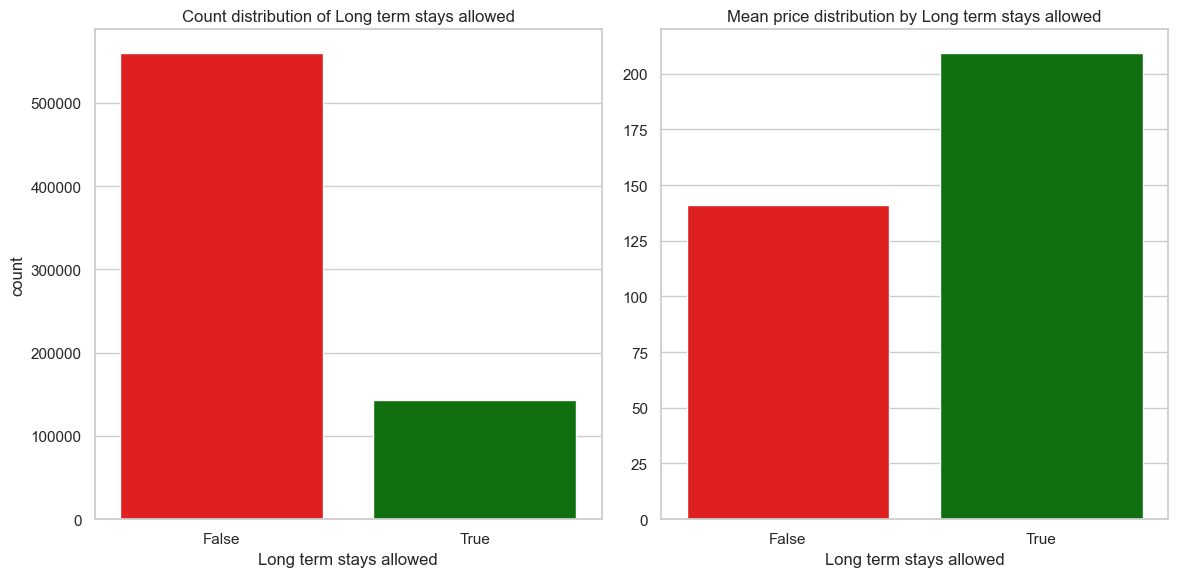

% Wise Split of Long term stays allowed:
Long term stays allowed
False    79.661378
True     20.338622
Name: proportion, dtype: float64

P-value for Long term stays allowed: 0.0
Long term stays allowed is statistically significant (p-value < 0.05)


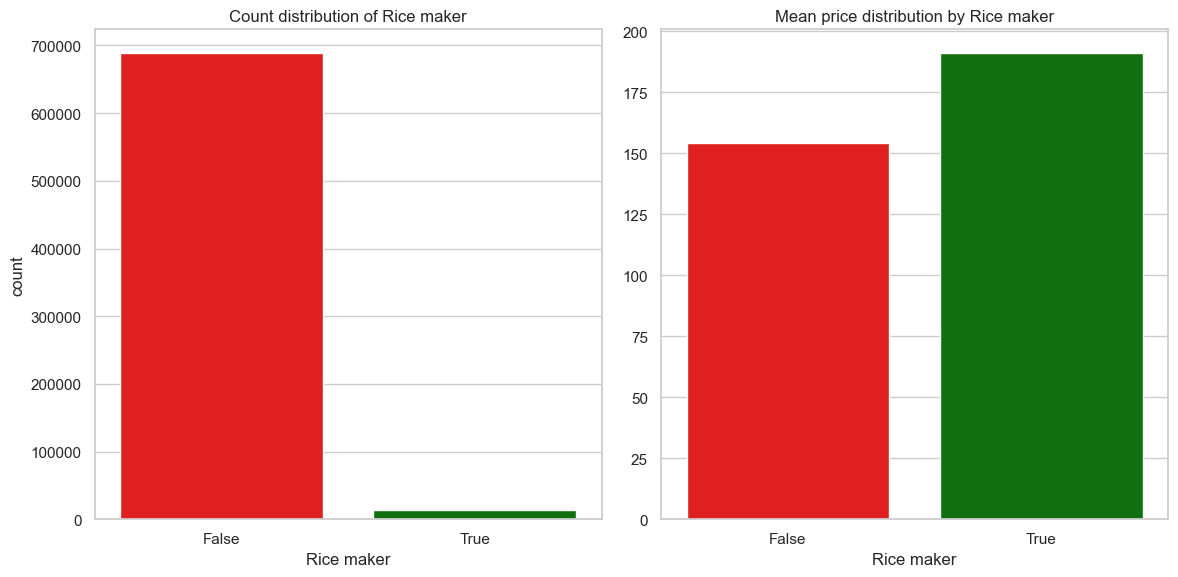

% Wise Split of Rice maker:
Rice maker
False    98.008711
True      1.991289
Name: proportion, dtype: float64

P-value for Rice maker: 2.538247971587481e-147
Rice maker is statistically significant (p-value < 0.05)


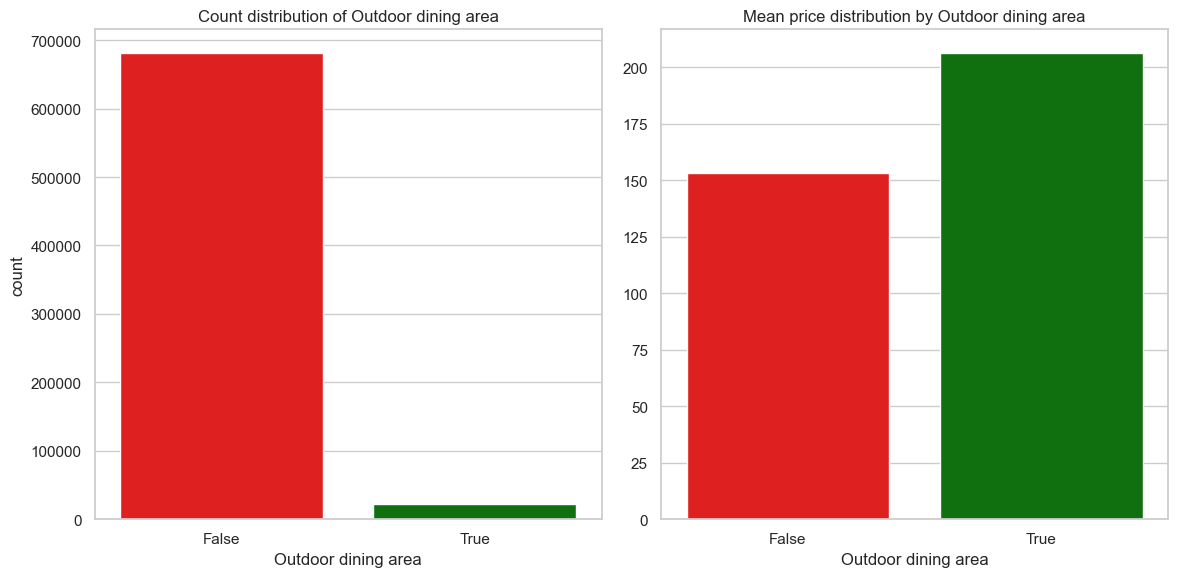

% Wise Split of Outdoor dining area:
Outdoor dining area
False    96.933722
True      3.066278
Name: proportion, dtype: float64

P-value for Outdoor dining area: 0.0
Outdoor dining area is statistically significant (p-value < 0.05)


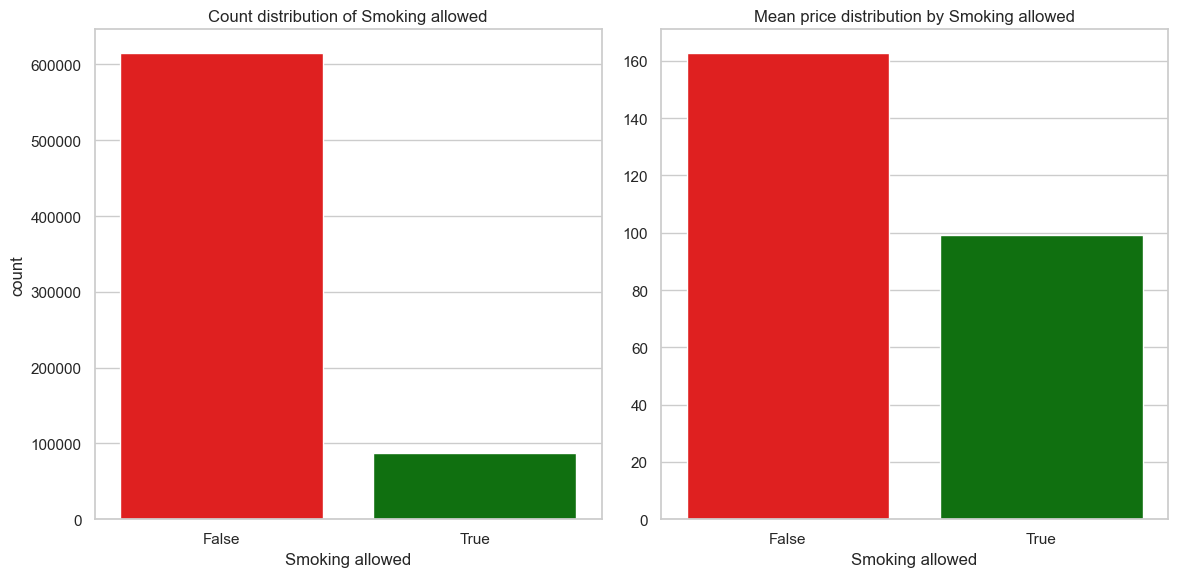

% Wise Split of Smoking allowed:
Smoking allowed
False    87.509651
True     12.490349
Name: proportion, dtype: float64

P-value for Smoking allowed: 0.0
Smoking allowed is statistically significant (p-value < 0.05)


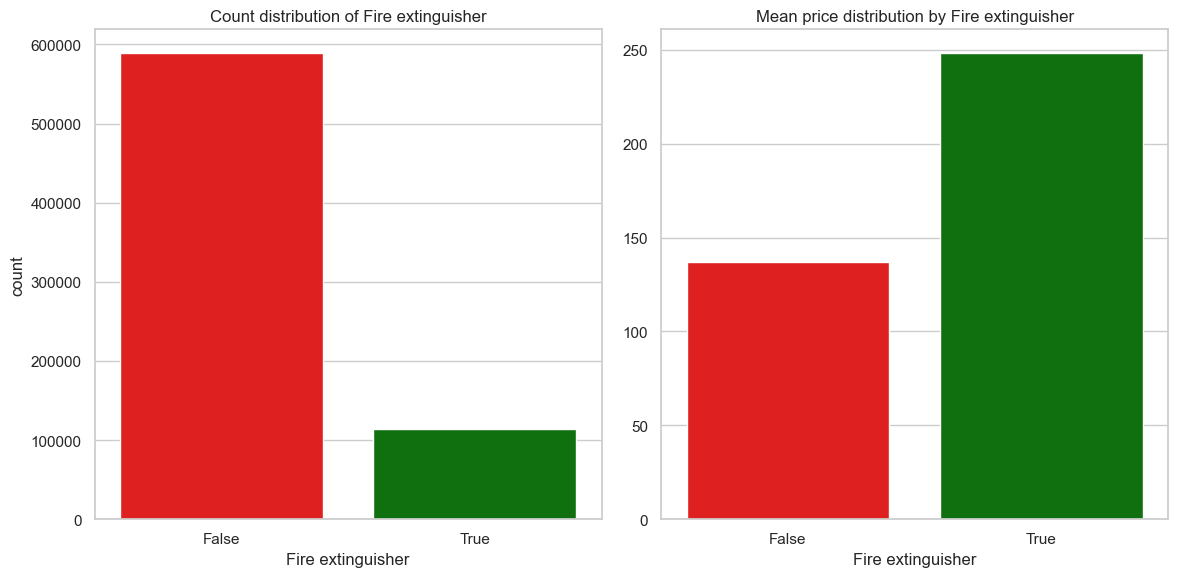

% Wise Split of Fire extinguisher:
Fire extinguisher
False    83.829663
True     16.170337
Name: proportion, dtype: float64

P-value for Fire extinguisher: 0.0
Fire extinguisher is statistically significant (p-value < 0.05)


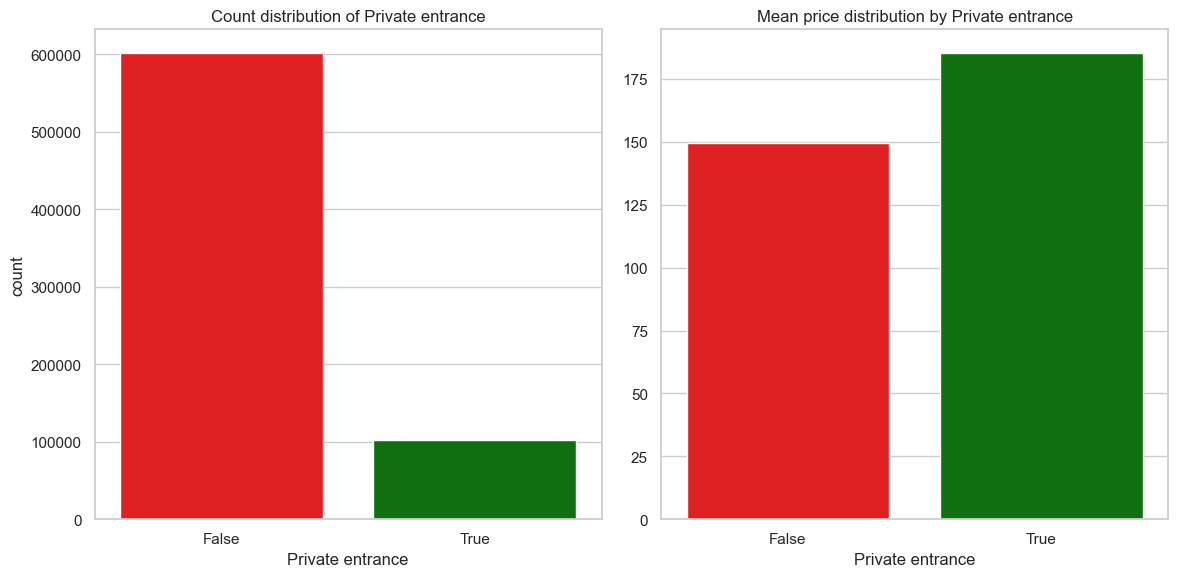

% Wise Split of Private entrance:
Private entrance
False    85.555048
True     14.444952
Name: proportion, dtype: float64

P-value for Private entrance: 0.0
Private entrance is statistically significant (p-value < 0.05)


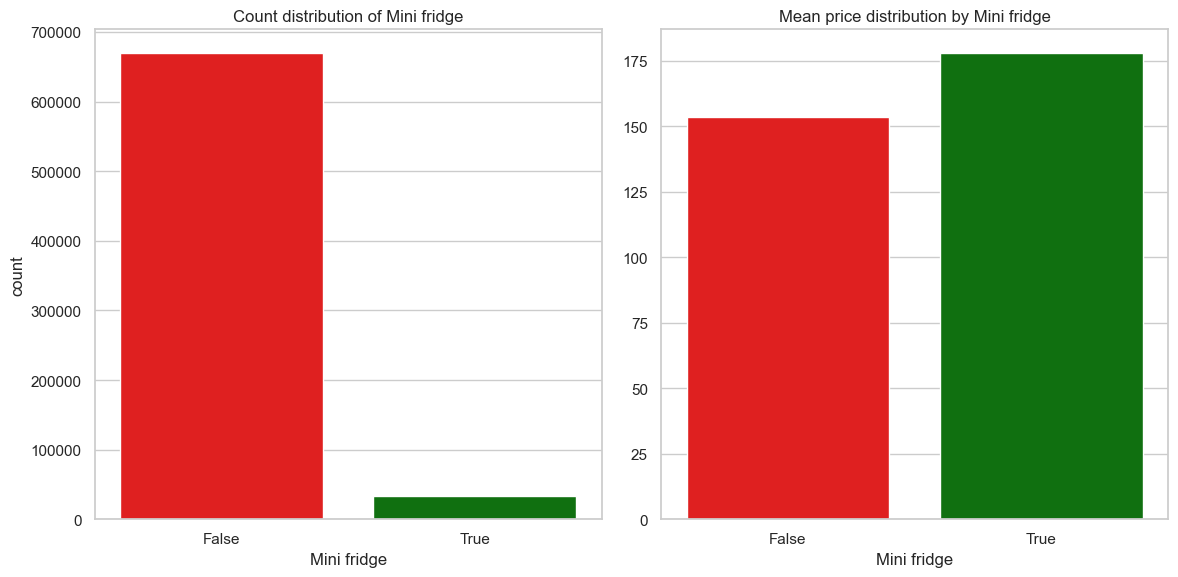

% Wise Split of Mini fridge:
Mini fridge
False    95.28441
True      4.71559
Name: proportion, dtype: float64

P-value for Mini fridge: 3.8190343074299756e-149
Mini fridge is statistically significant (p-value < 0.05)


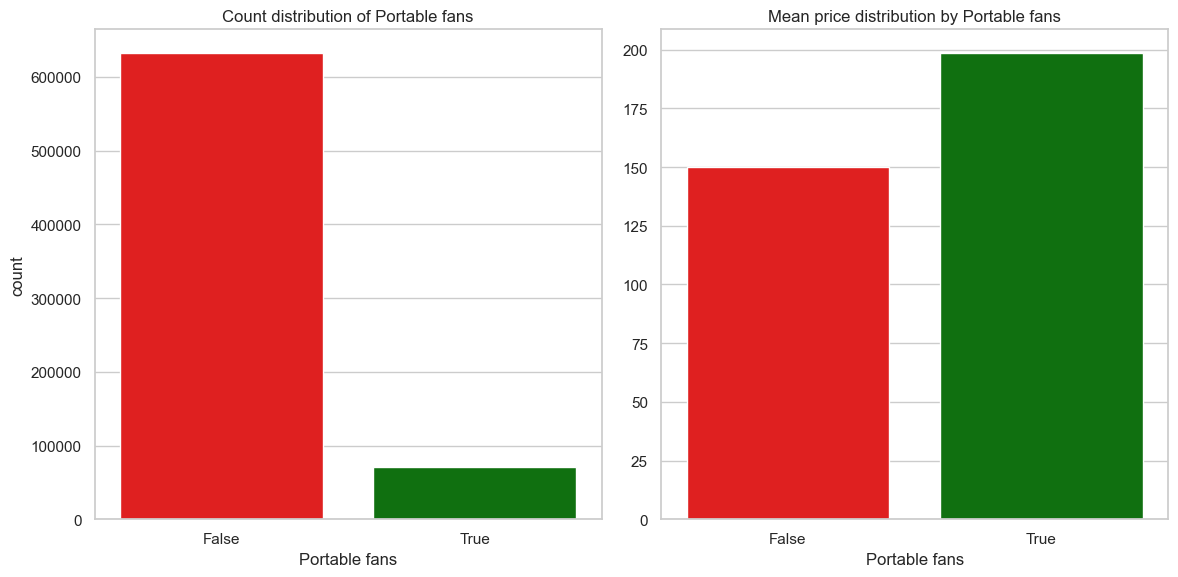

% Wise Split of Portable fans:
Portable fans
False    89.971462
True     10.028538
Name: proportion, dtype: float64

P-value for Portable fans: 0.0
Portable fans is statistically significant (p-value < 0.05)


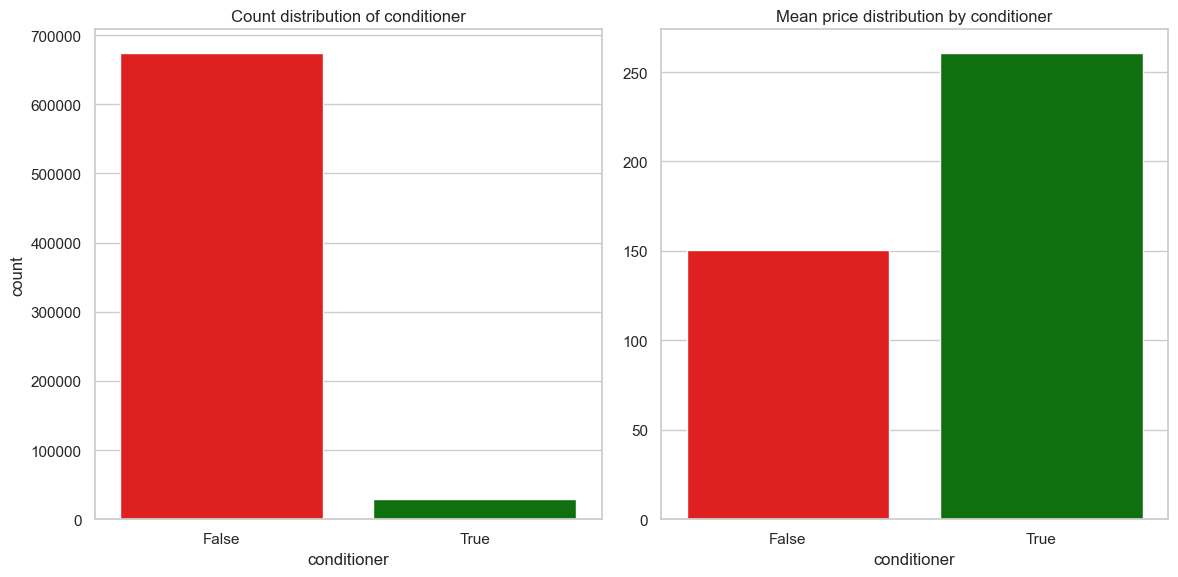

% Wise Split of conditioner:
conditioner
False    95.913762
True      4.086238
Name: proportion, dtype: float64

P-value for conditioner: 0.0
conditioner is statistically significant (p-value < 0.05)


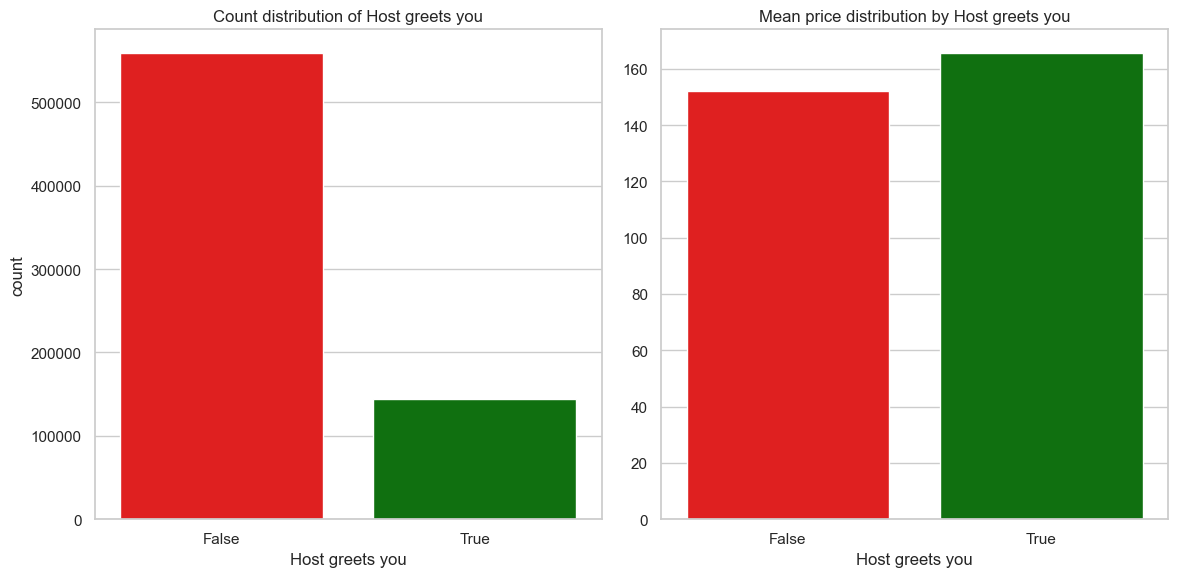

% Wise Split of Host greets you:
Host greets you
False    79.546201
True     20.453799
Name: proportion, dtype: float64

P-value for Host greets you: 2.770673838885872e-175
Host greets you is statistically significant (p-value < 0.05)


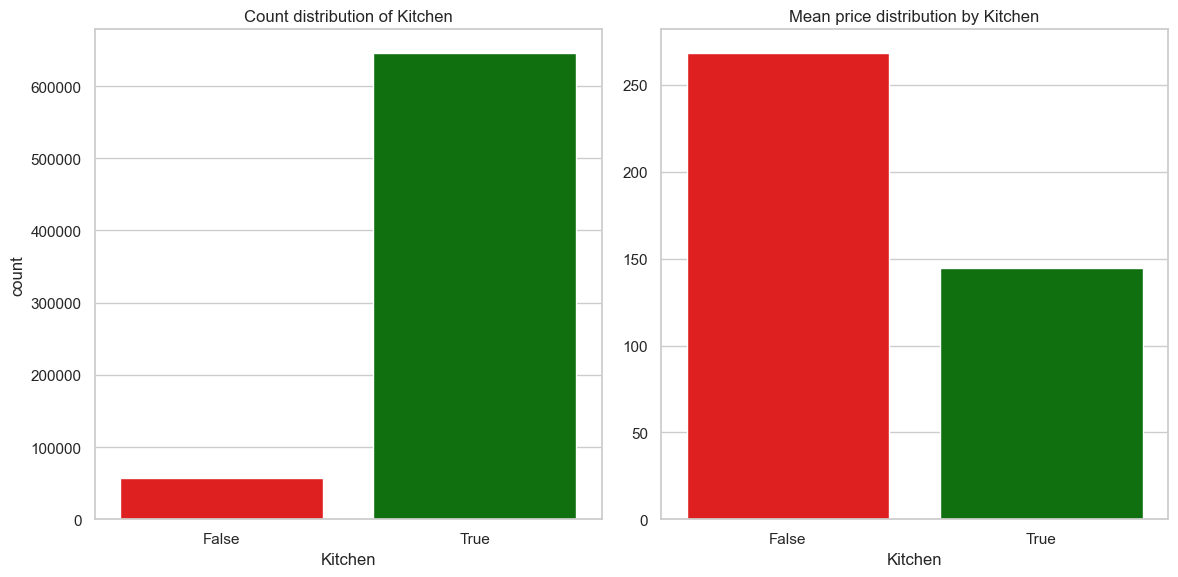

% Wise Split of Kitchen:
Kitchen
True     91.893218
False     8.106782
Name: proportion, dtype: float64

P-value for Kitchen: 0.0
Kitchen is statistically significant (p-value < 0.05)


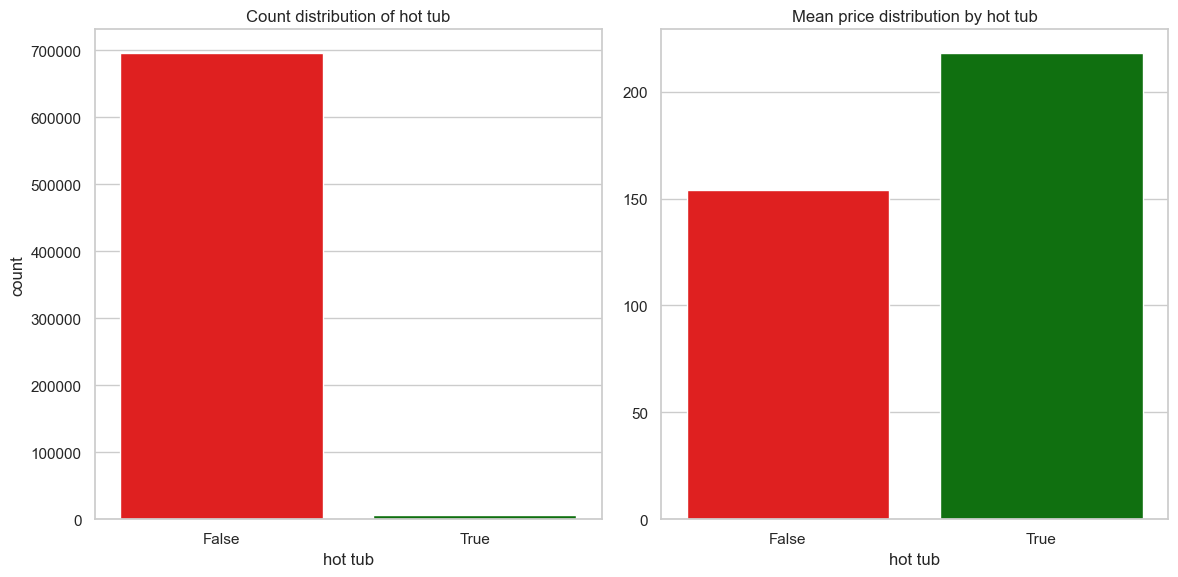

% Wise Split of hot tub:
hot tub
False    99.021703
True      0.978297
Name: proportion, dtype: float64

P-value for hot tub: 4.509309543894984e-133
hot tub is statistically significant (p-value < 0.05)


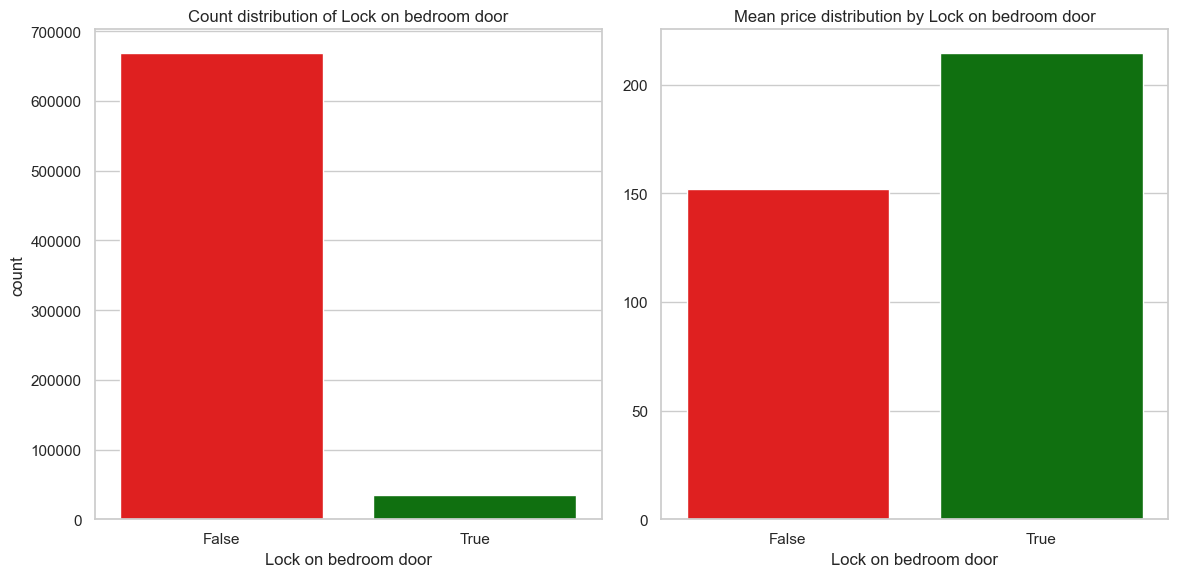

% Wise Split of Lock on bedroom door:
Lock on bedroom door
False    95.12757
True      4.87243
Name: proportion, dtype: float64

P-value for Lock on bedroom door: 0.0
Lock on bedroom door is statistically significant (p-value < 0.05)


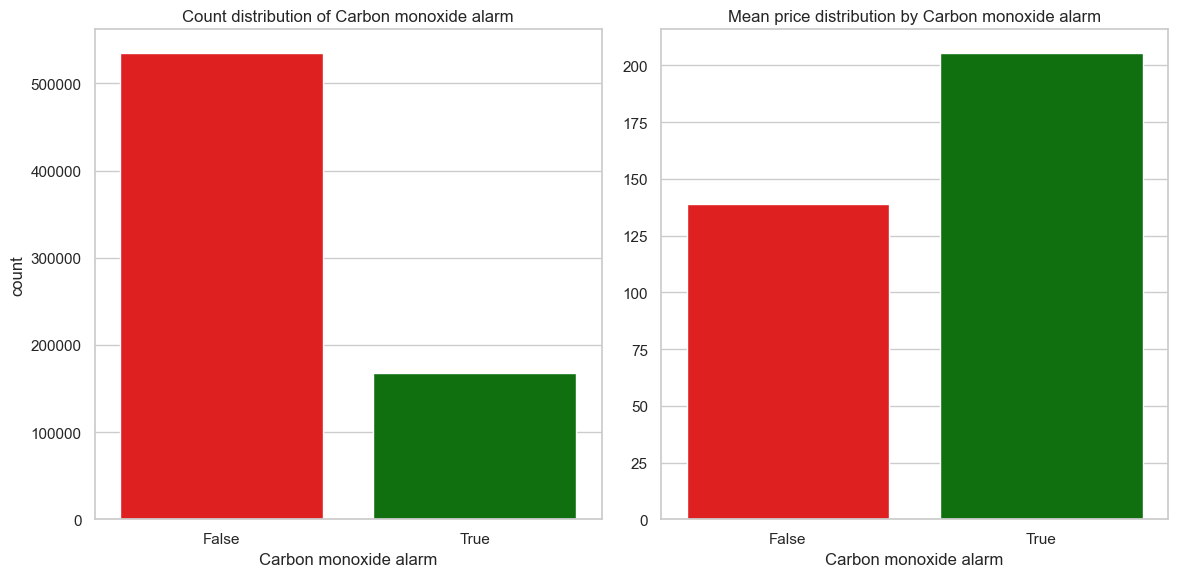

% Wise Split of Carbon monoxide alarm:
Carbon monoxide alarm
False    76.104245
True     23.895755
Name: proportion, dtype: float64

P-value for Carbon monoxide alarm: 0.0
Carbon monoxide alarm is statistically significant (p-value < 0.05)


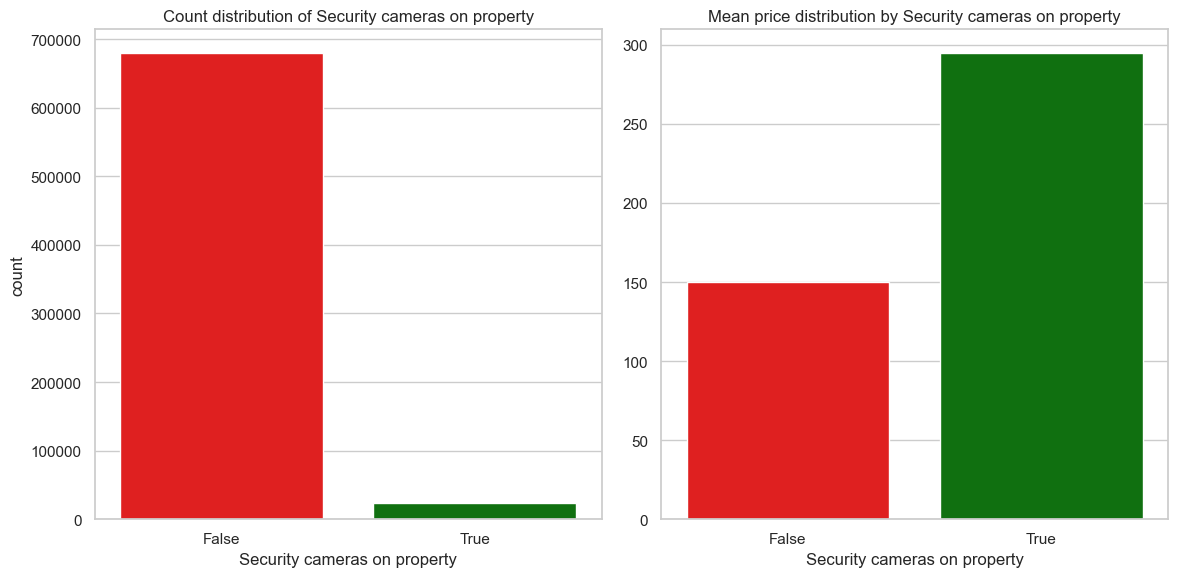

% Wise Split of Security cameras on property:
Security cameras on property
False    96.743466
True      3.256534
Name: proportion, dtype: float64

P-value for Security cameras on property: 0.0
Security cameras on property is statistically significant (p-value < 0.05)


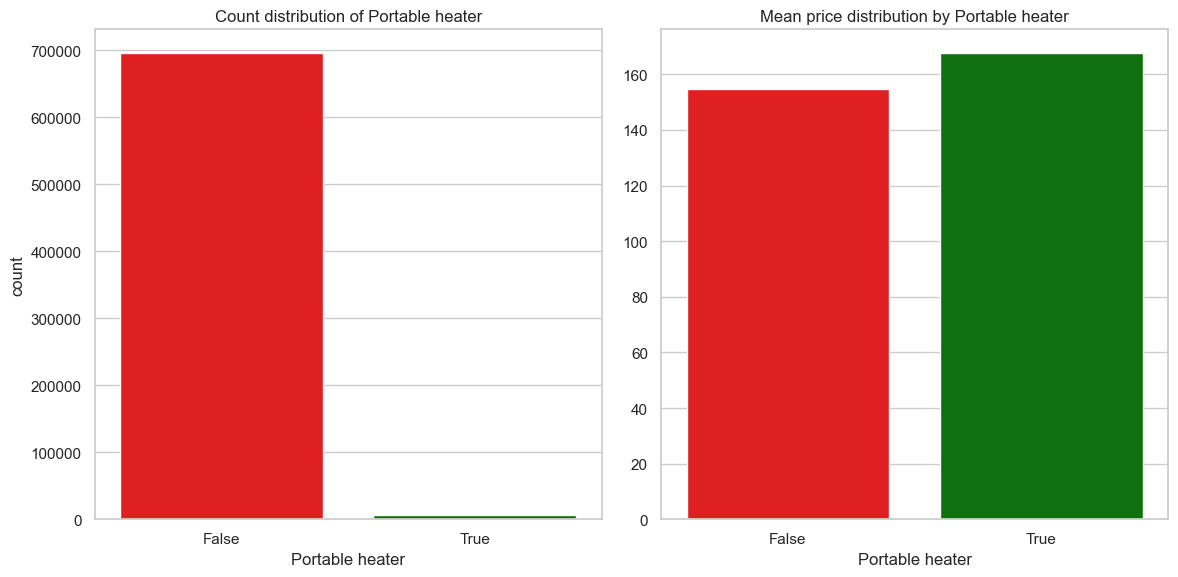

% Wise Split of Portable heater:
Portable heater
False    98.993549
True      1.006451
Name: proportion, dtype: float64

P-value for Portable heater: 5.408909078099003e-13
Portable heater is statistically significant (p-value < 0.05)


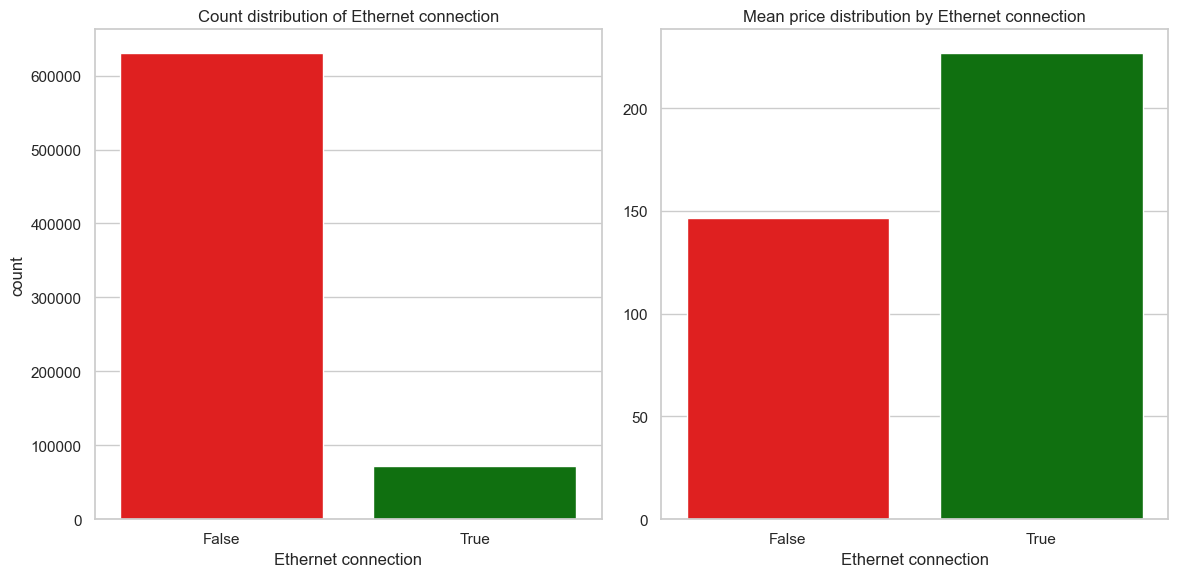

% Wise Split of Ethernet connection:
Ethernet connection
False    89.716365
True     10.283635
Name: proportion, dtype: float64

P-value for Ethernet connection: 0.0
Ethernet connection is statistically significant (p-value < 0.05)


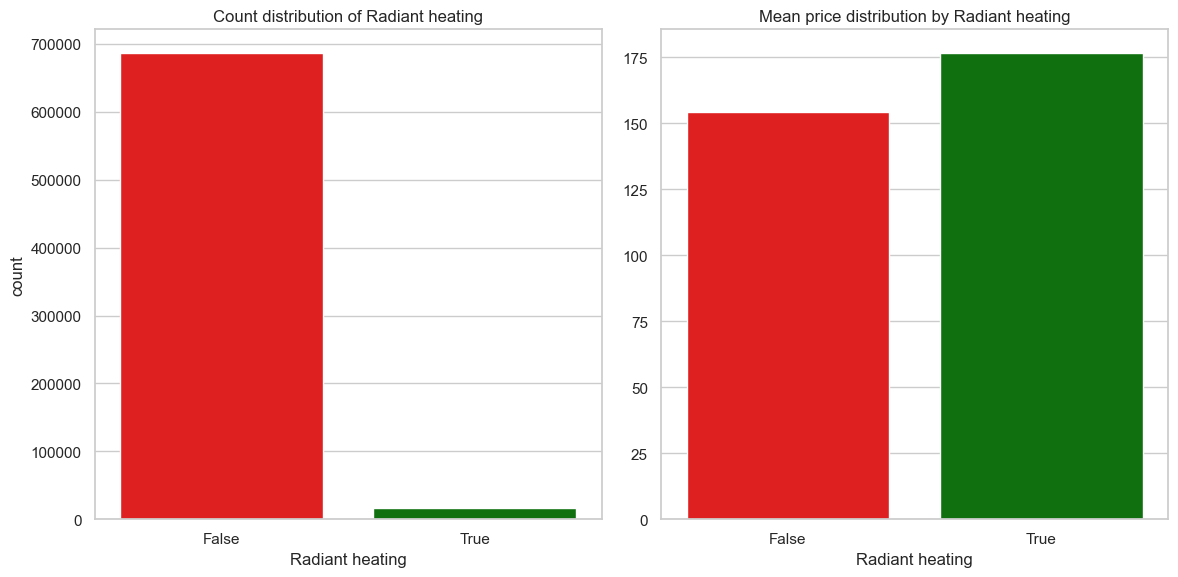

% Wise Split of Radiant heating:
Radiant heating
False    97.704699
True      2.295301
Name: proportion, dtype: float64

P-value for Radiant heating: 3.938708241574965e-73
Radiant heating is statistically significant (p-value < 0.05)


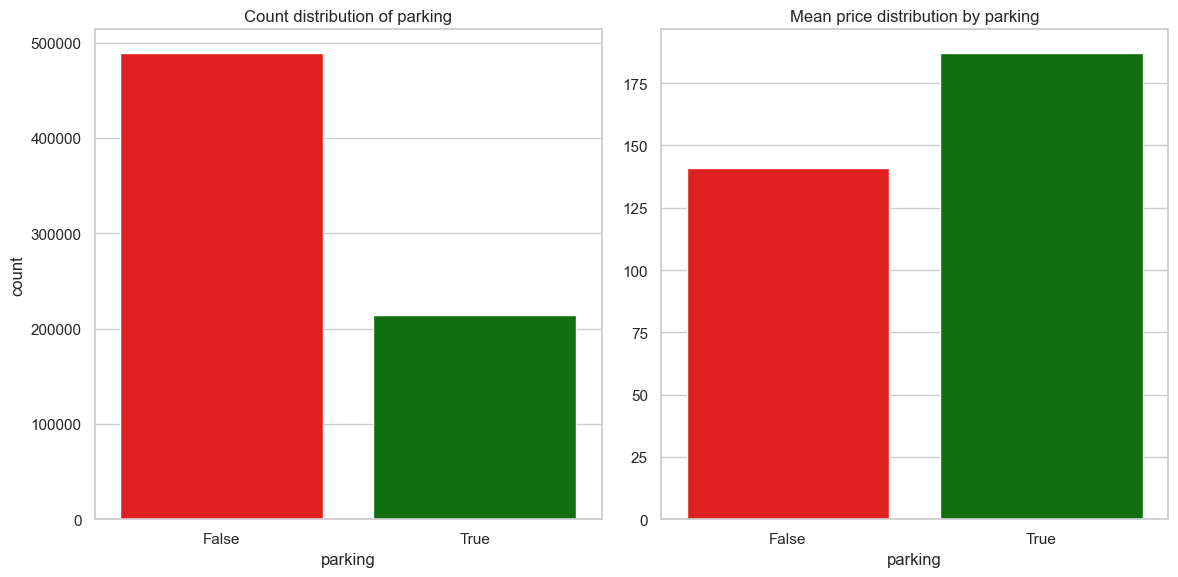

% Wise Split of parking:
parking
False    69.58876
True     30.41124
Name: proportion, dtype: float64

P-value for parking: 0.0
parking is statistically significant (p-value < 0.05)


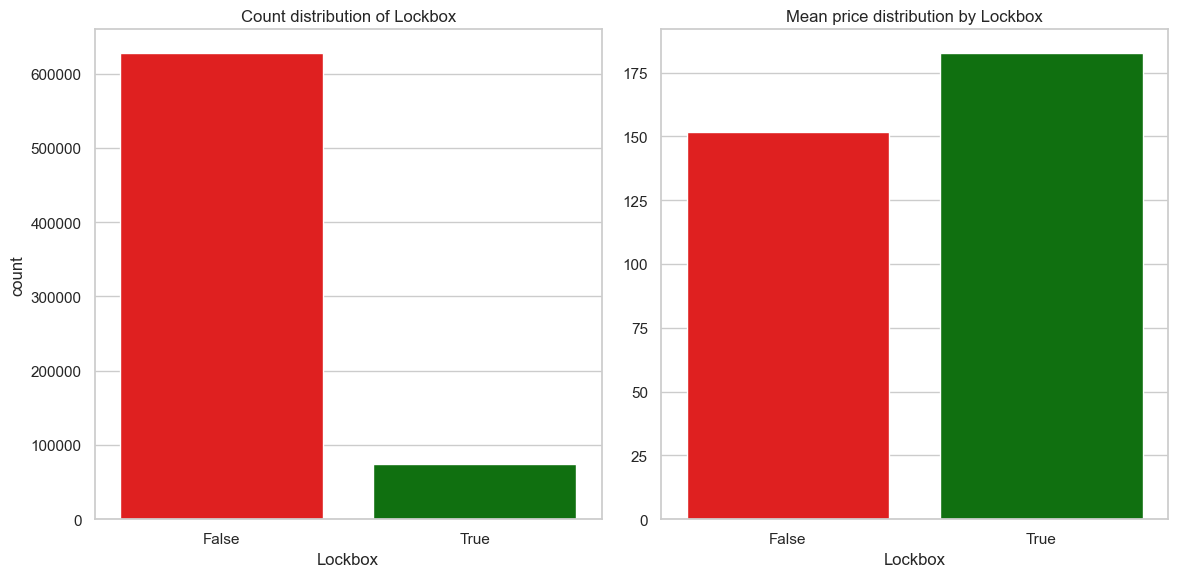

% Wise Split of Lockbox:
Lockbox
False    89.333436
True     10.666564
Name: proportion, dtype: float64

P-value for Lockbox: 0.0
Lockbox is statistically significant (p-value < 0.05)


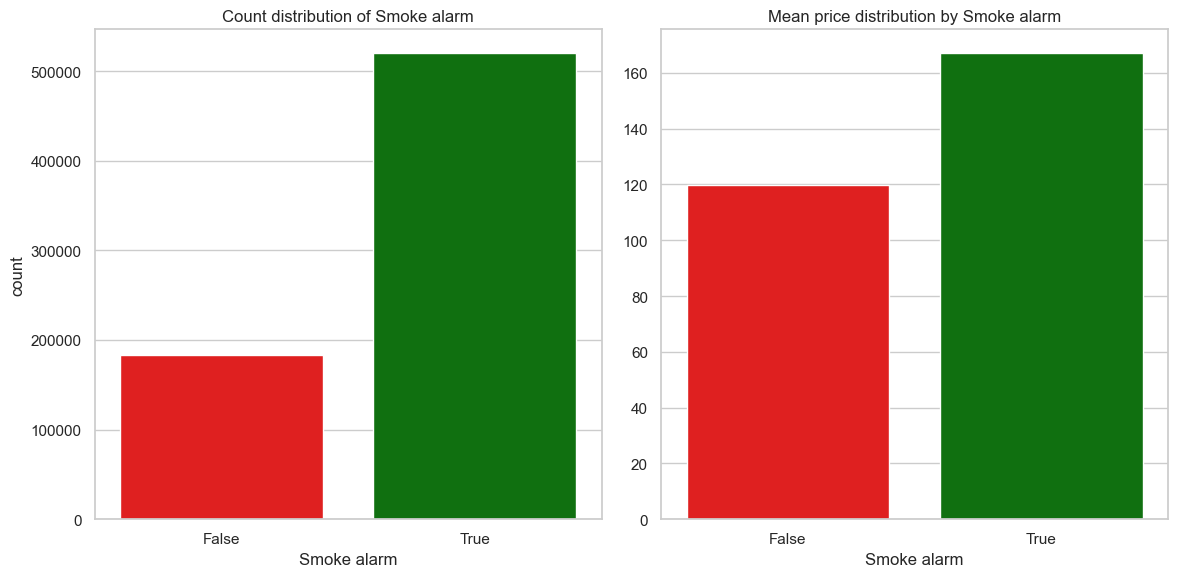

% Wise Split of Smoke alarm:
Smoke alarm
True     74.010008
False    25.989992
Name: proportion, dtype: float64

P-value for Smoke alarm: 0.0
Smoke alarm is statistically significant (p-value < 0.05)


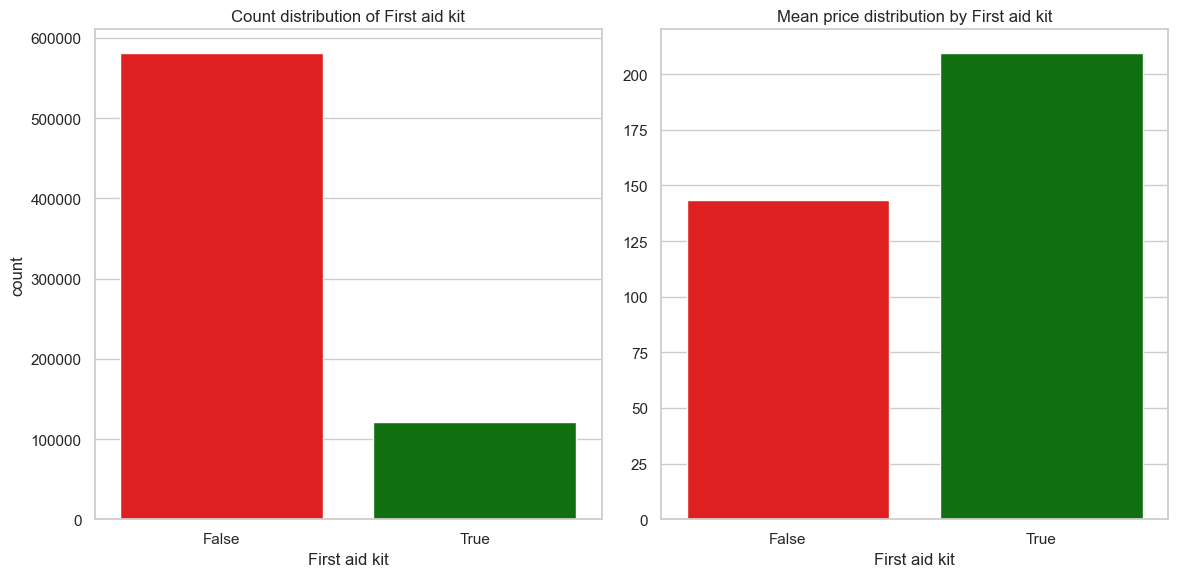

% Wise Split of First aid kit:
First aid kit
False    82.685567
True     17.314433
Name: proportion, dtype: float64

P-value for First aid kit: 0.0
First aid kit is statistically significant (p-value < 0.05)


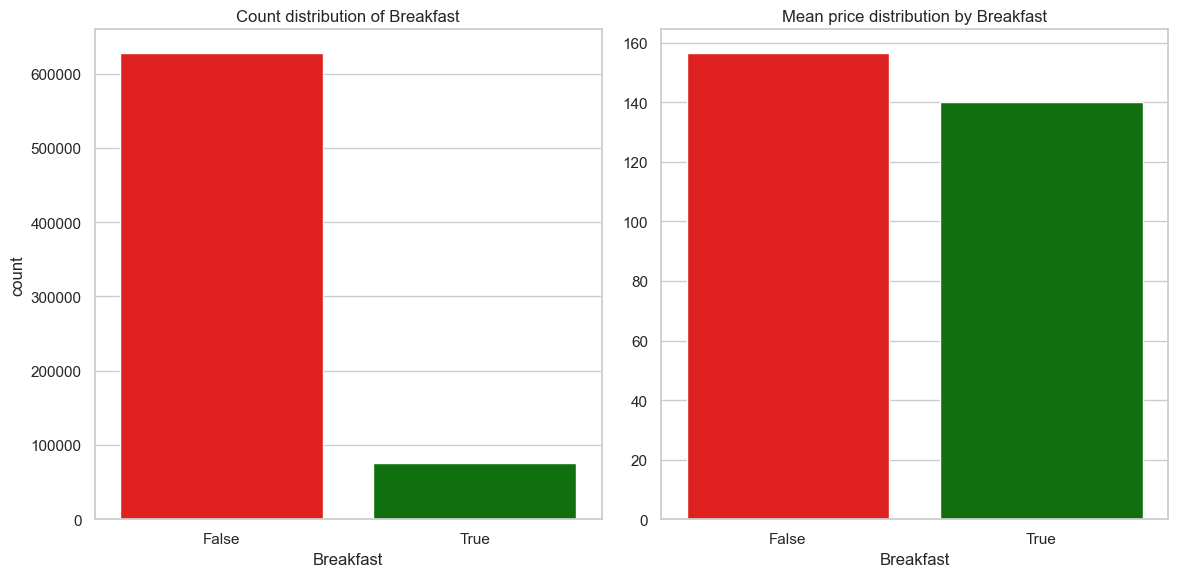

% Wise Split of Breakfast:
Breakfast
False    89.316657
True     10.683343
Name: proportion, dtype: float64

P-value for Breakfast: 1.539400417439849e-165
Breakfast is statistically significant (p-value < 0.05)


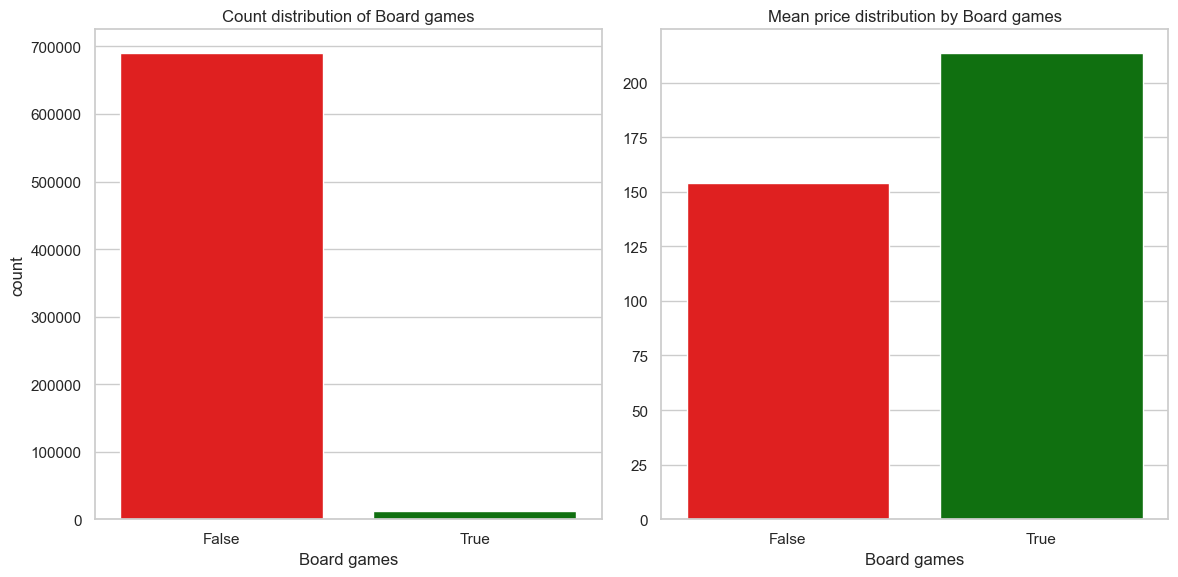

% Wise Split of Board games:
Board games
False    98.206219
True      1.793781
Name: proportion, dtype: float64

P-value for Board games: 3.0770655739385927e-304
Board games is statistically significant (p-value < 0.05)


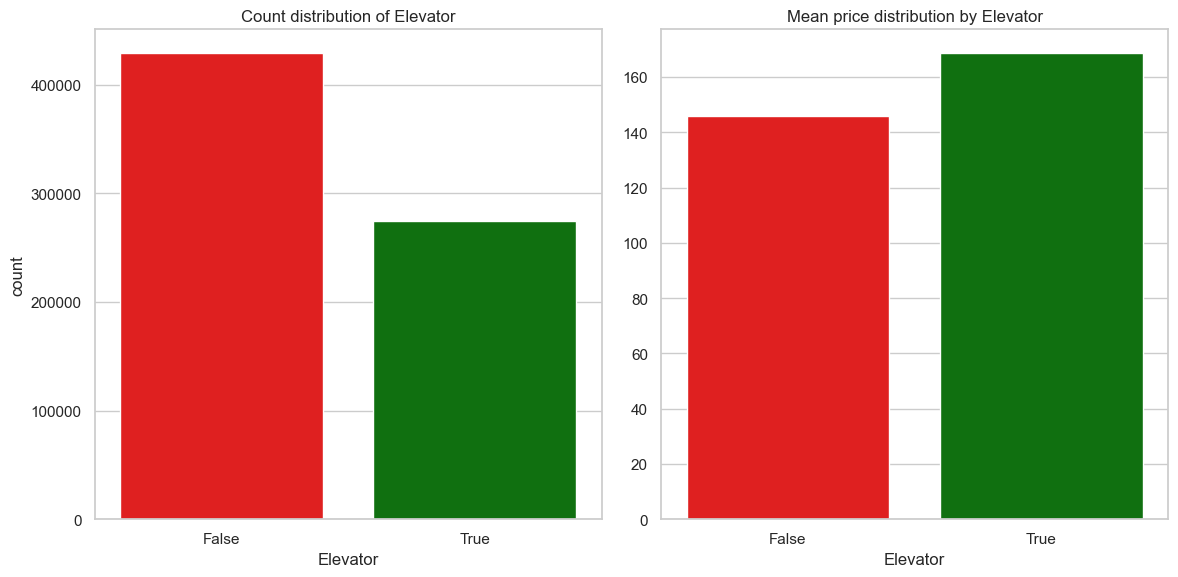

% Wise Split of Elevator:
Elevator
False    61.040038
True     38.959962
Name: proportion, dtype: float64

P-value for Elevator: 0.0
Elevator is statistically significant (p-value < 0.05)


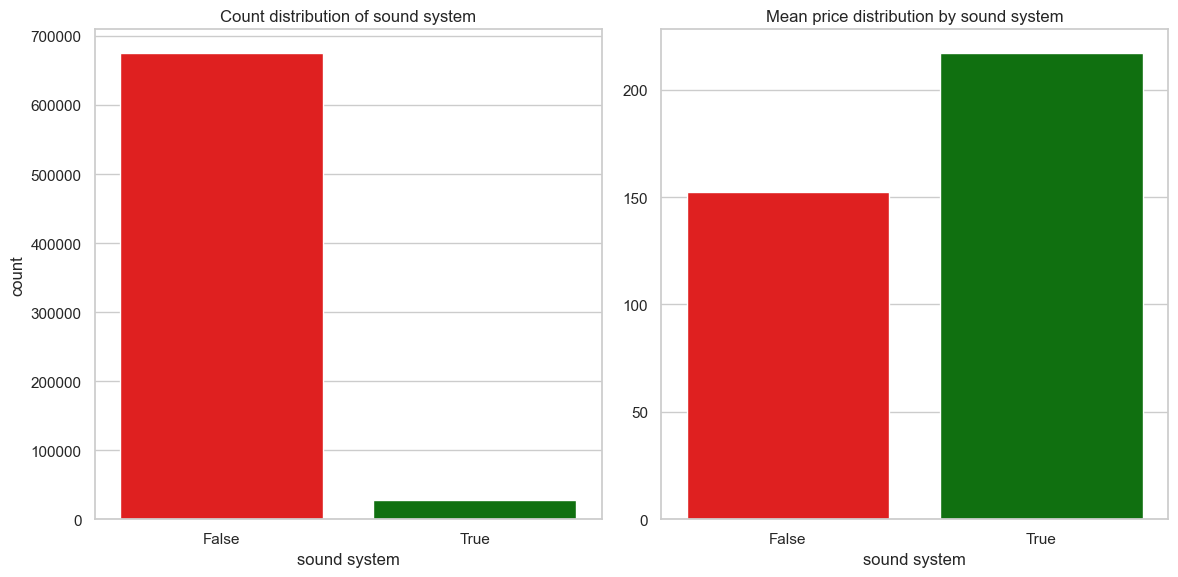

% Wise Split of sound system:
sound system
False    96.081978
True      3.918022
Name: proportion, dtype: float64

P-value for sound system: 0.0
sound system is statistically significant (p-value < 0.05)


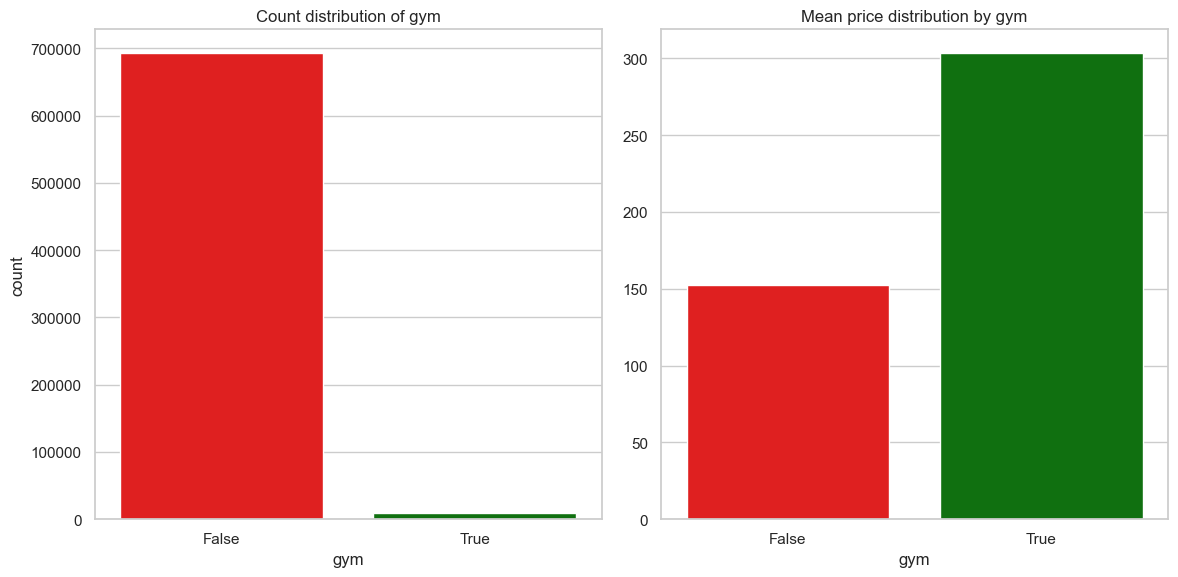

% Wise Split of gym:
gym
False    98.58801
True      1.41199
Name: proportion, dtype: float64

P-value for gym: 0.0
gym is statistically significant (p-value < 0.05)


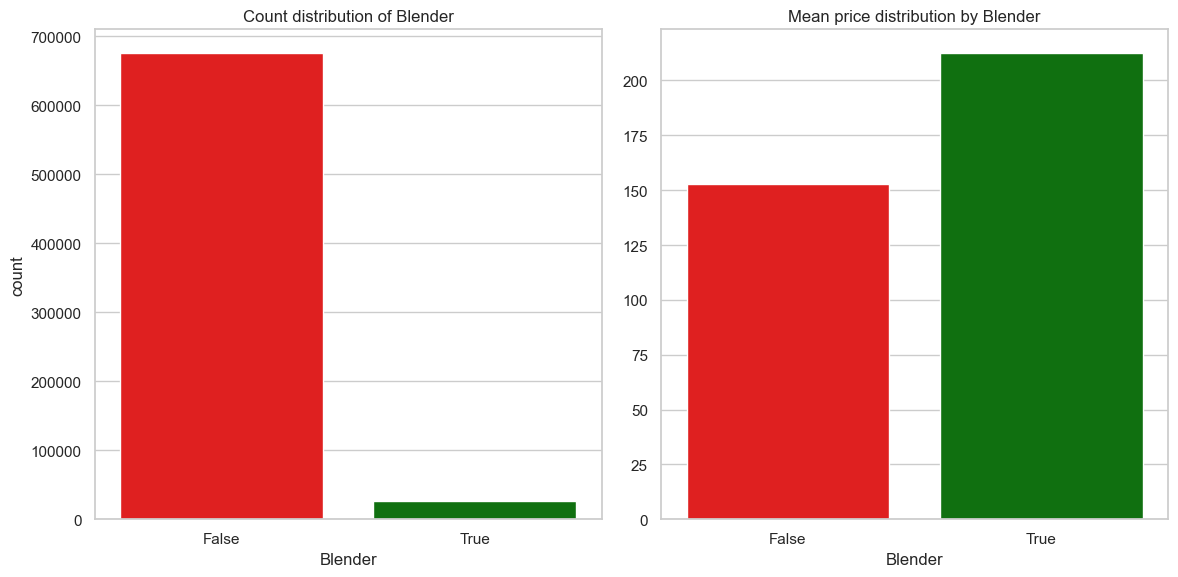

% Wise Split of Blender:
Blender
False    96.181656
True      3.818344
Name: proportion, dtype: float64

P-value for Blender: 0.0
Blender is statistically significant (p-value < 0.05)


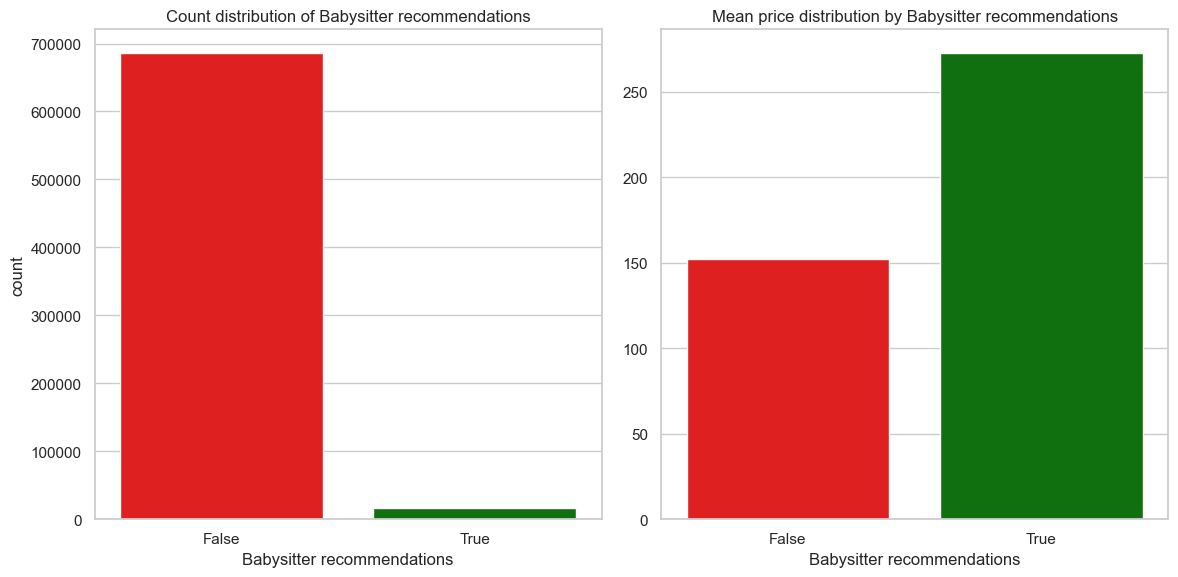

% Wise Split of Babysitter recommendations:
Babysitter recommendations
False    97.606443
True      2.393557
Name: proportion, dtype: float64

P-value for Babysitter recommendations: 0.0
Babysitter recommendations is statistically significant (p-value < 0.05)


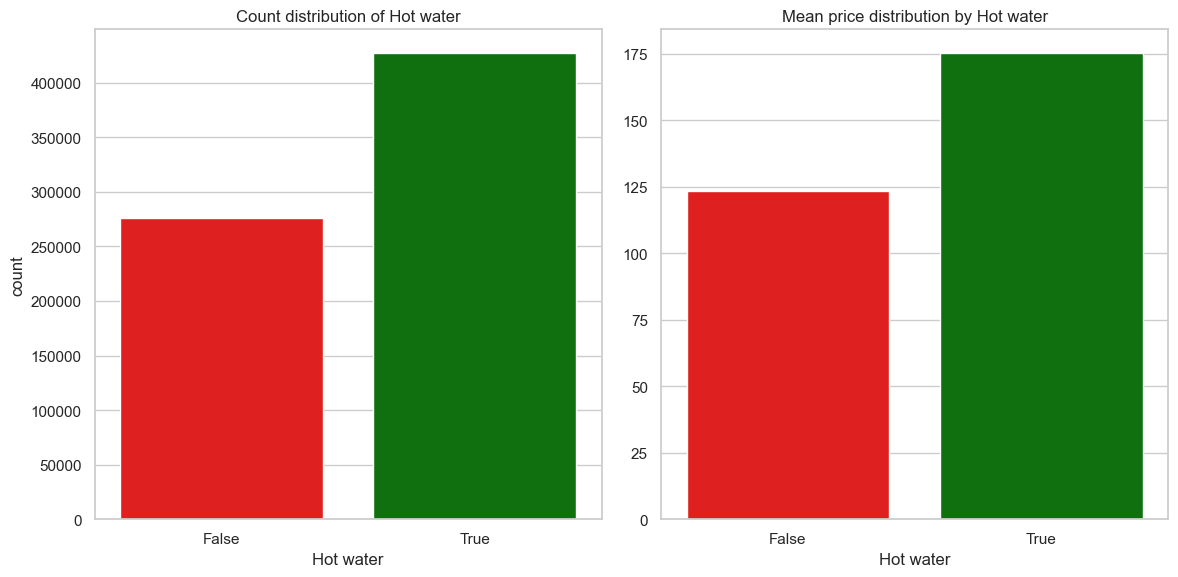

% Wise Split of Hot water:
Hot water
True     60.77968
False    39.22032
Name: proportion, dtype: float64

P-value for Hot water: 0.0
Hot water is statistically significant (p-value < 0.05)


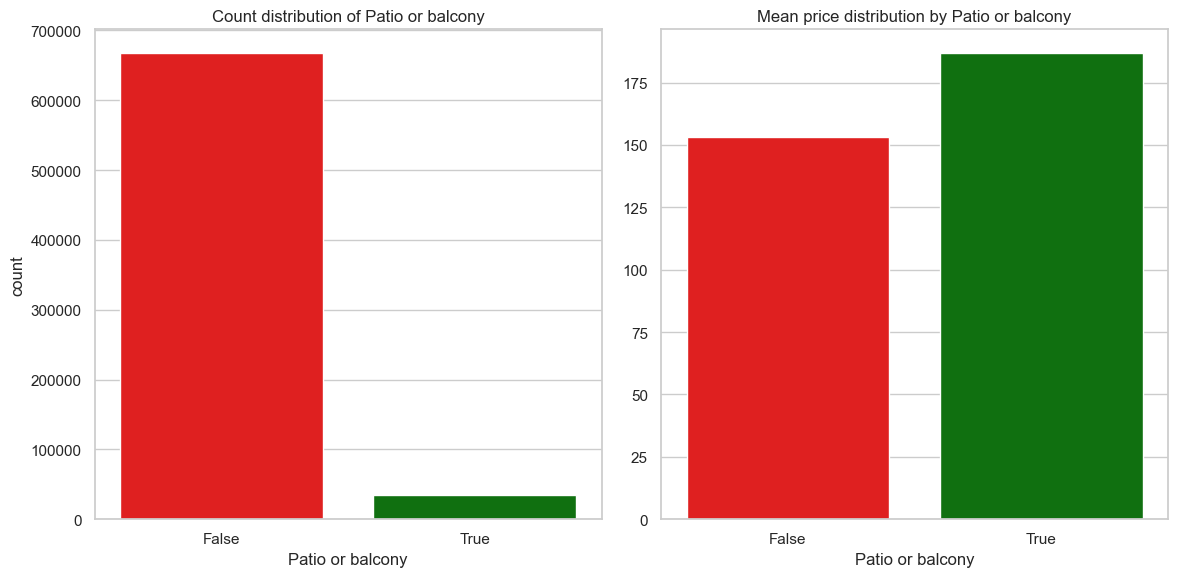

% Wise Split of Patio or balcony:
Patio or balcony
False    95.003292
True      4.996708
Name: proportion, dtype: float64

P-value for Patio or balcony: 1.52061867876141e-206
Patio or balcony is statistically significant (p-value < 0.05)


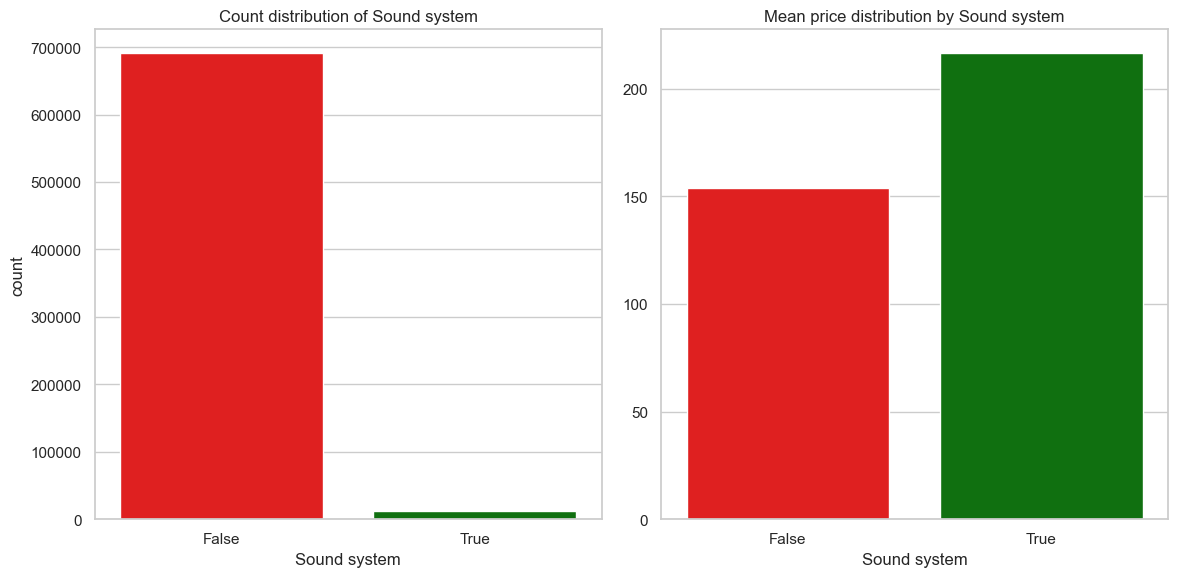

% Wise Split of Sound system:
Sound system
False    98.341872
True      1.658128
Name: proportion, dtype: float64

P-value for Sound system: 1.7395469408228055e-271
Sound system is statistically significant (p-value < 0.05)


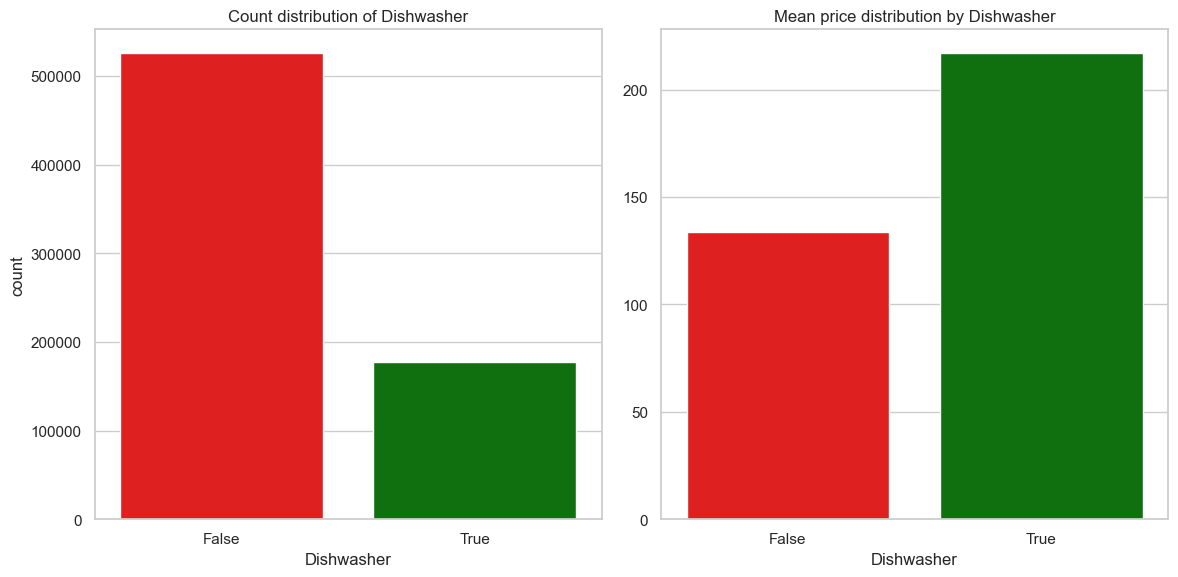

% Wise Split of Dishwasher:
Dishwasher
False    74.800466
True     25.199534
Name: proportion, dtype: float64

P-value for Dishwasher: 0.0
Dishwasher is statistically significant (p-value < 0.05)


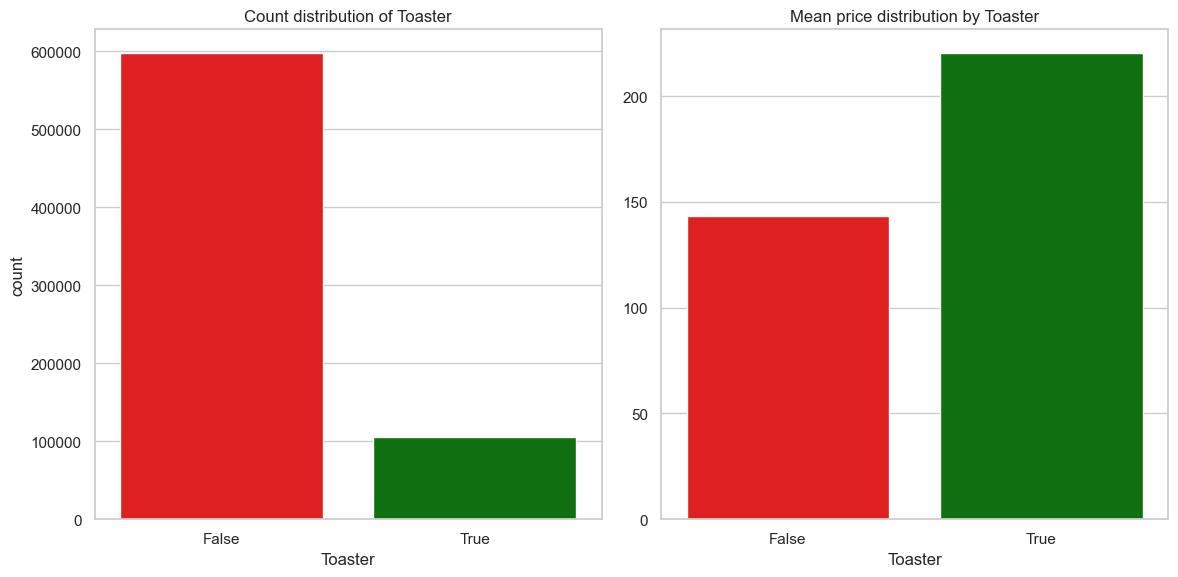

% Wise Split of Toaster:
Toaster
False    85.040874
True     14.959126
Name: proportion, dtype: float64

P-value for Toaster: 0.0
Toaster is statistically significant (p-value < 0.05)


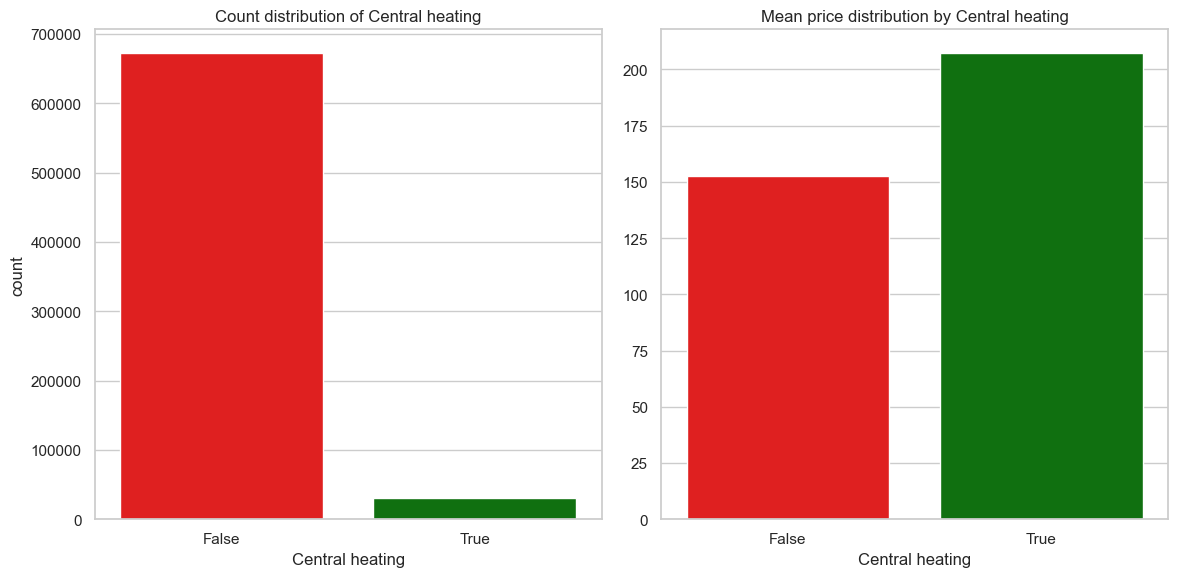

% Wise Split of Central heating:
Central heating
False    95.666486
True      4.333514
Name: proportion, dtype: float64

P-value for Central heating: 0.0
Central heating is statistically significant (p-value < 0.05)


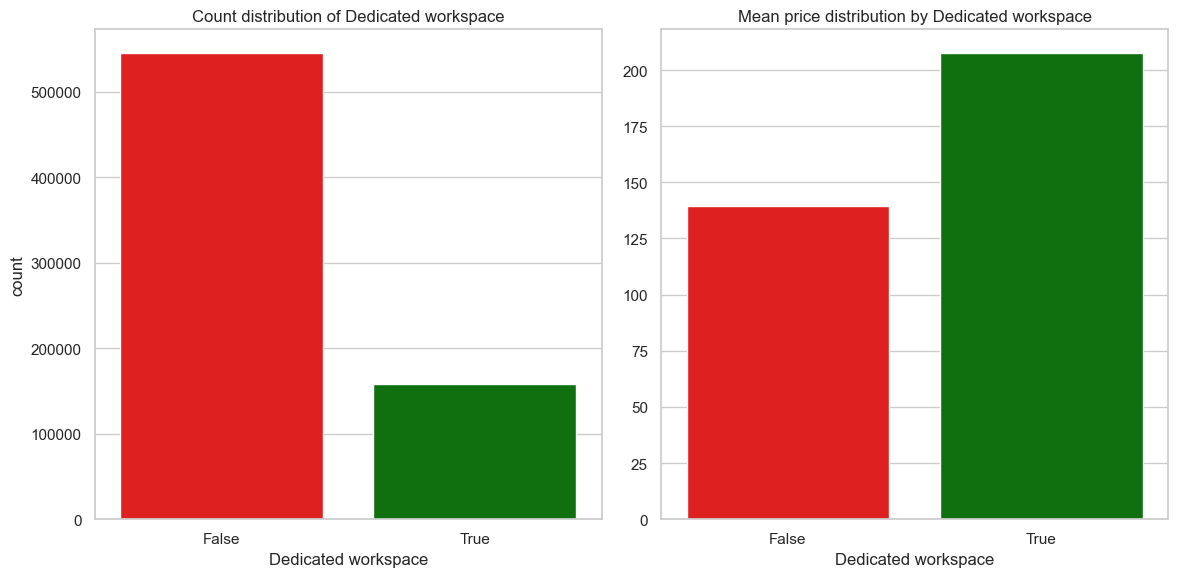

% Wise Split of Dedicated workspace:
Dedicated workspace
False    77.59046
True     22.40954
Name: proportion, dtype: float64

P-value for Dedicated workspace: 0.0
Dedicated workspace is statistically significant (p-value < 0.05)


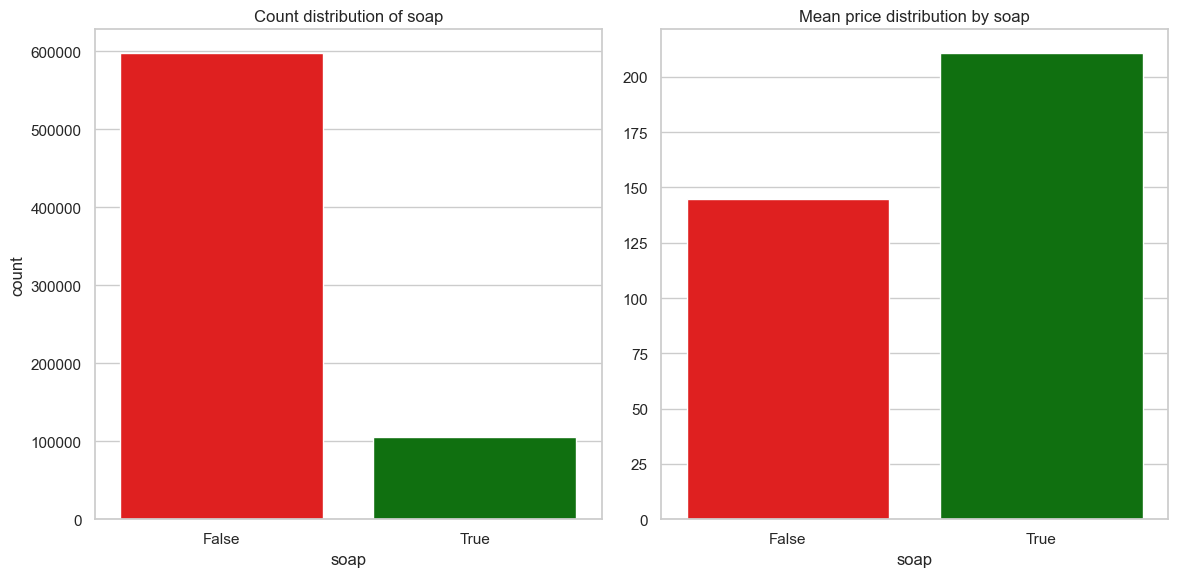

% Wise Split of soap:
soap
False    85.009875
True     14.990125
Name: proportion, dtype: float64

P-value for soap: 0.0
soap is statistically significant (p-value < 0.05)


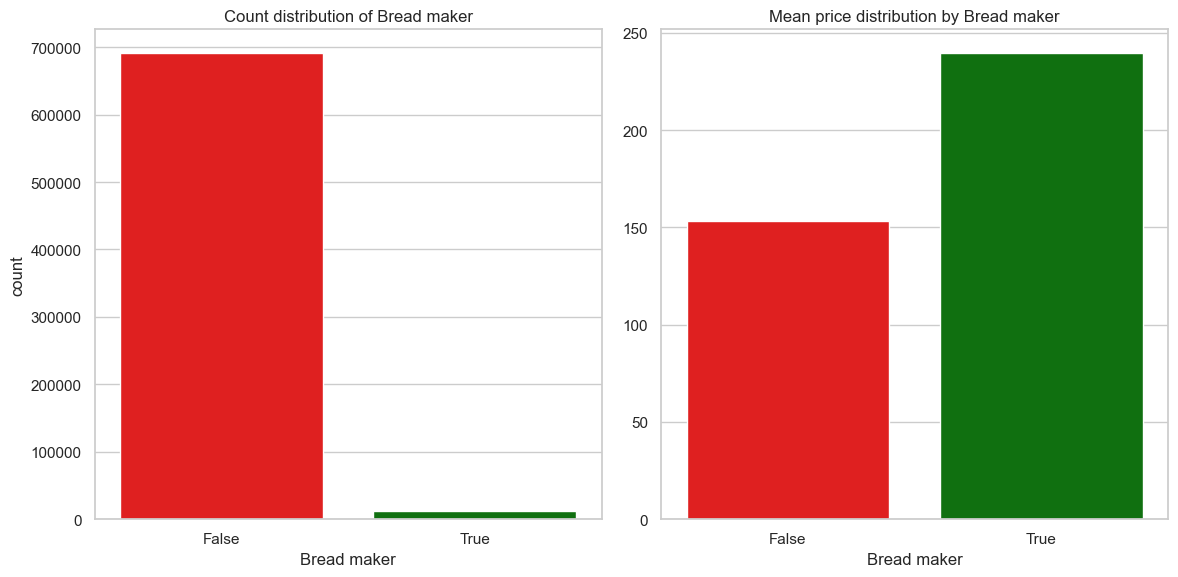

% Wise Split of Bread maker:
Bread maker
False    98.347844
True      1.652156
Name: proportion, dtype: float64

P-value for Bread maker: 0.0
Bread maker is statistically significant (p-value < 0.05)


In [33]:
#doing the analysis for all the different amenities
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 20, 20
column_indices = list(range(25, 119))
result = [binary_count_and_price_plot(col) for col in dataframe1.iloc[:,column_indices].columns]

In [ ]:
#now we are making a comparison against the rating and seeing if having the amenity might impact the rating

def binary_count_and_rating_plot(column_name,alpha=0.05):
    # Only taking the ones with reviews into consideration
    data = dataframe1[[column_name, 'review_scores_rating']].dropna()

    # Plot count distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=column_name, data=data)
    plt.title(f'Count distribution of {column_name}')

    # Plot median price distribution
    plt.subplot(1, 2, 2)
    rating_mean = data.groupby(column_name)['review_scores_rating'].mean()
    rating_mean.plot(kind='bar', color=['blue', 'orange'])
    plt.title(f'Average rating distribution by {column_name}')
    plt.tight_layout()
    plt.show()

    # Calculate t-test for median prices
    true_ratings = data[data[column_name] == True]['review_scores_rating']
    false_ratings = data[data[column_name] == False]['review_scores_rating']
    t_stat, p_value = ttest_ind(true_ratings, false_ratings)
   
    # Display additional information
    percent_split = data[column_name].value_counts(normalize=True) * 100
    print(f'% Wise Split of {column_name}:\n{percent_split}')
    t_statistic, p_value = ttest_ind(true_ratings, false_ratings, equal_var=False)  # assuming unequal variances
    print(f'\nP-value for {column_name}: {p_value}')
    
    # Check if p-value is greater than or equal to alpha
    if p_value >= alpha:
        print(f"{column_name} is not statistically significant (p-value >= {alpha})")
        return column_name
    else:
        print(f"{column_name} is statistically significant (p-value < {alpha})")
        return None  # or any other value if needed
    
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 20, 20
result = [binary_count_and_rating_plot(col) for col in dataframe1.iloc[:,51:-2].columns]

In [ ]:
from collections import OrderedDict

def collect_pvalues(columns_of_interest):
    all_pvalues = {}

    for column_name in columns_of_interest:
        # Drop rows with missing values in the specified columns
        data = dataframe1[[column_name, 'price']].dropna()

        # Calculate t-test for median prices
        true_prices = data[data[column_name] == True]['price']
        false_prices = data[data[column_name] == False]['price']
        t_statistic, p_value = ttest_ind(true_prices, false_prices, equal_var=False)  # assuming unequal variances
        all_pvalues[column_name] = {'p_value': p_value, 't_statistic': t_statistic}

    return all_pvalues

columns_of_interest = dataframe1.iloc[:, 51:-2].columns.values
result = collect_pvalues(columns_of_interest)
# Extract p-values and create a dictionary

all_pvalues = {}
for column in result:
    p_value = result[column]['p_value']
    if isinstance(p_value, np.float64):
        all_pvalues[column] = p_value
    else:
        all_pvalues[column] = [float(val) for val in p_value]

import math
#P-values of effects of each amanity on price can be visualized using the 'Manhattan-plot' approach: taking the minus log of the P-value:
# -log Pvalues and order
all_pvalues.update({k: -1*np.log(v) for k, v in all_pvalues.items()})
ordereddict = OrderedDict(sorted(all_pvalues.items(), key=lambda t: t[1]))
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = 12, 30
plt.barh(list(ordereddict.keys()), list(ordereddict.values()),color='g', height=0.6)
plt.show()

In [18]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 16, 8

print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(dataframe1.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(dataframe1.host_since).strftime('%d %B %Y')}.")


dataframe1.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
dataframe1.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='green')
plt.title('Paris hosts registration on Airbnb, numbers of first reviews per accommodation per month')
plt.legend()
plt.xlim('2008-01-01', '2019-11-30') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'host_since'

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose


def decompose_time_series(ts, title=''):
    decomposition = seasonal_decompose(ts)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='upper left')
    plt.title(f'{title} - Original')

    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.title(f'{title} - Trend')

    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.title(f'{title} - Seasonal')

    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='upper left')
    plt.title(f'{title} - Residual')

    plt.tight_layout()
    plt.show()
    
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(dataframe1.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(dataframe1.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = 50, 70
decompose_time_series(ts_host_since, title='Number of registrations on Airbnb by month')

KeyError: "None of ['host_since'] are in the columns"

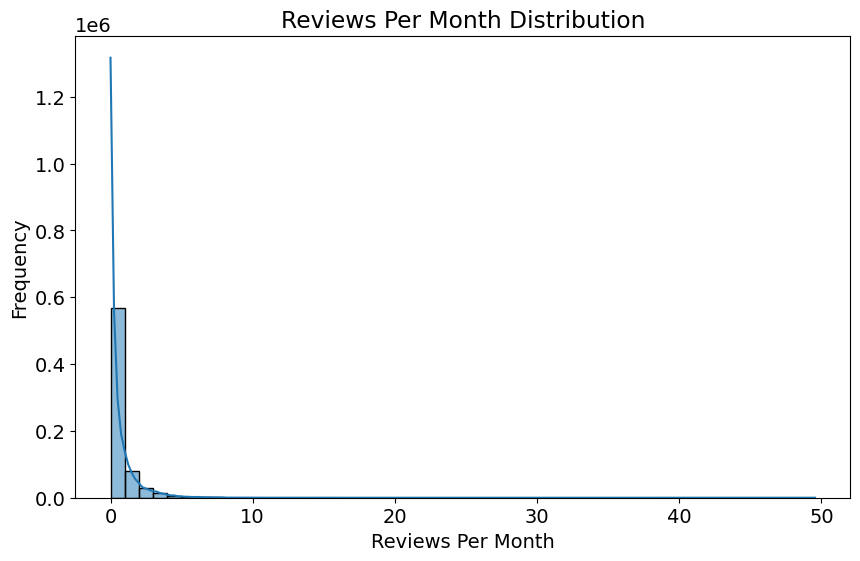

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(dataframe1['reviews_per_month'].dropna(), bins=50, kde=True)
plt.xlabel('Reviews Per Month')
plt.ylabel('Frequency')
plt.title('Reviews Per Month Distribution')
plt.show()

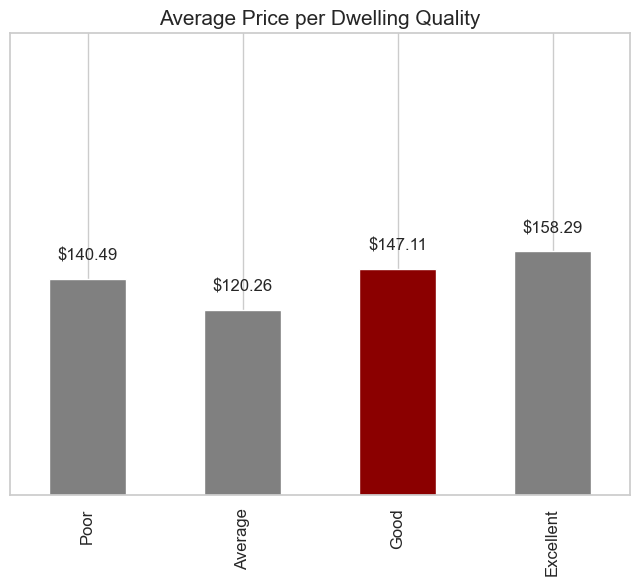

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cut the 'review_scores_value' into categories
categories = pd.cut(dataframe1['review_scores_rating'].dropna(), 4, labels=['Poor', 'Average', 'Good', 'Excellent'])
dataframe1['Lodging Quality'] = categories

# Filter out residences with no customer evaluation
no_nan = dataframe1[~dataframe1['review_scores_rating'].isnull()]

# Set seaborn style
sns.set(style='whitegrid')

# Group by 'Lodging Quality' and calculate the average price for each category
groups = no_nan.groupby('Lodging Quality')['price'].mean()

# Set the figure size
plt.figure(figsize=(8, 6))

# Plot the bar chart with adjusted ylim
chart = groups.plot(kind='bar', ylim=(0, 300), xlabel='', yticks=[], fontsize=12, color=['grey', 'grey', 'darkred', 'grey'])

# Display average prices on top of the bars
for i, price in enumerate(groups):
    plt.text(i, price + 10, f'${price:.2f}', ha='center', va='bottom', fontdict={'size': 12})

# Set the graph title
plt.title('Average Price per Dwelling Quality', fontdict={'size': 15})

# Show the plot
plt.show()

In [22]:
#showing the distribution between price and amount of bedrooms
figsize = (10, 5)
x = 'bedrooms'

# Create a grid with 2 rows and 1 column
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 1)

# Bar plot for price distribution
ax1 = plt.subplot(gs[0])
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)
ax1.set_title(f'Distribution of Price based on {x}')

# Calculate the percentage of each bedroom count relative to all listings
bedroom_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for bedrooms, percentage in bedroom_percentage.items():
    print(f'The percentage of listings with {bedrooms} bedroom(s) is: {percentage:.2f}%')


plt.tight_layout()
plt.show()

NameError: name 'gridspec' is not defined

<Figure size 1000x500 with 0 Axes>

The percentage of listings with 1.0 room type(s) is: 57.21%
The percentage of listings with 2.0 room type(s) is: 29.58%
The percentage of listings with 3.0 room type(s) is: 9.08%
The percentage of listings with 4.0 room type(s) is: 3.26%
The percentage of listings with 5.0 room type(s) is: 0.88%


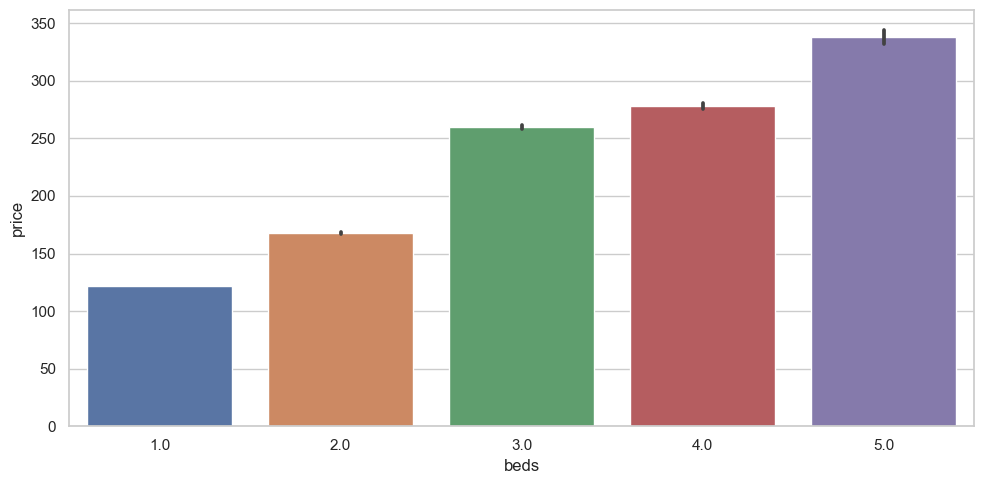

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
x = 'beds'

# Create a grid with 2 rows and 1 column
figsize = (10, 5)
fig, ax1 = plt.subplots(figsize=figsize)

# Bar plot for price distribution
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)

# Calculate the percentage of each bedroom count relative to all listings
room_type_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for room_type, percentage in room_type_percentage.items():
    print(f'The percentage of listings with {room_type} room type(s) is: {percentage:.2f}%')

plt.tight_layout()
plt.show()

In [ ]:
#showing the distribution between price and amount of bathrooms
figsize = (10, 5)
x = 'bathrooms'

# Create a grid with 2 rows and 1 column
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 1)

# Bar plot for price distribution
ax1 = plt.subplot(gs[0])
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)
ax1.set_title(f'Distribution of Price based on {x}')

# Calculate the percentage of each bedroom count relative to all listings
bathroom_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for bathrooms, percentage in bathroom_percentage.items():
    print(f'The percentage of listings with {bathrooms} bathroom(s) is: {percentage:.2f}%')


plt.tight_layout()
plt.show()

The percentage of listings with Entire home/apt room type(s) is: 83.44%
The percentage of listings with Private room room type(s) is: 14.00%
The percentage of listings with Hotel room room type(s) is: 2.01%
The percentage of listings with Shared room room type(s) is: 0.55%


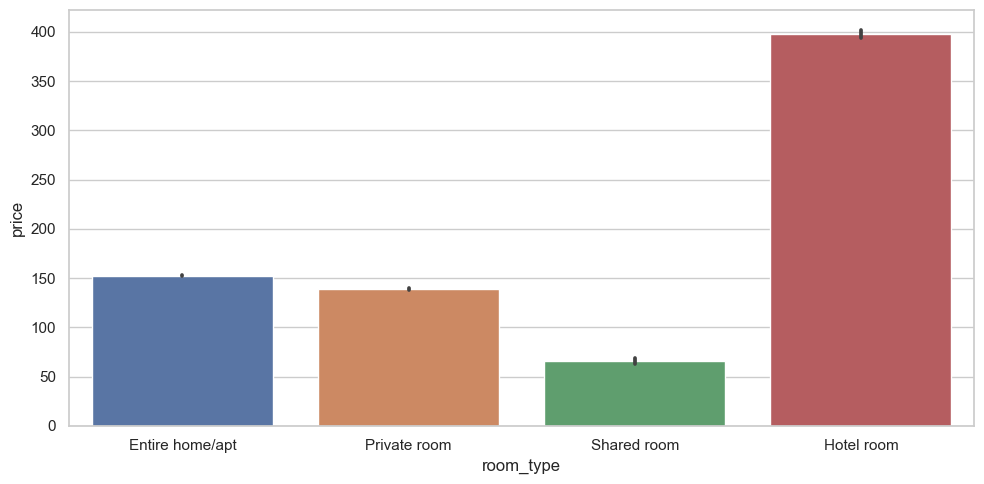

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming dataframe1 is your DataFrame containing the boolean columns

# Create a new column 'room_type' with the category names
dataframe1['room_type'] = dataframe1[['room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']].idxmax(axis=1)

# Replace column names with category names
dataframe1['room_type'] = dataframe1['room_type'].apply(lambda x: x.split('_')[-1])

x = 'room_type'

# Create a grid with 2 rows and 1 column
figsize = (10, 5)
fig, ax1 = plt.subplots(figsize=figsize)

# Bar plot for price distribution
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)

# Calculate the percentage of each bedroom count relative to all listings
room_type_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for room_type, percentage in room_type_percentage.items():
    print(f'The percentage of listings with {room_type} room type(s) is: {percentage:.2f}%')

plt.tight_layout()
plt.show()

In [ ]:
#showing the distribution between price and amount of bathrooms
figsize = (10, 5)
x = 'accommodates'

# Create a grid with 2 rows and 1 column
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 1)

# Bar plot for price distribution
ax1 = plt.subplot(gs[0])
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)
ax1.set_title(f'Distribution of Price based on {x}')

# Calculate the percentage of each bedroom count relative to all listings
accommodates_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for accommodates, percentage in accommodates_percentage.items():
    print(f'The percentage of listings with {accommodates} accommodates is: {percentage:.2f}%')


plt.tight_layout()
plt.show()

In [ ]:
# Calculate the total number of amenities for each listing
dataframe1['total_amenities'] = dataframe1.iloc[:, 51:-1].sum(axis=1)

#showing the distribution between price and amount of bathrooms
figsize = (10, 5)
x = 'total_amenities'

# Create a grid with 2 rows and 1 column
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 1)

# Bar plot for price distribution
ax1 = plt.subplot(gs[0])
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)
ax1.set_title(f'Distribution of Price based on {x}')

# Calculate the percentage of each bedroom count relative to all listings
total_amenities_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for total_amenities, percentage in total_amenities_percentage.items():
    print(f'The percentage of listings with {total_amenities} total_amenities is: {percentage:.2f}%')

plt.tight_layout()
plt.show()

In [ ]:
import folium
from folium.plugins import FloatImage
import pandas as pd
from branca.colormap import LinearColormap

# Assuming dataframe1 is loaded with appropriate 'longitude' and 'latitude' columns and 'price' column
sub_6 = dataframe1[dataframe1.price < 600]

# Create a map centered around an average location
paris_map = folium.Map(location=[sub_6['latitude'].mean(), sub_6['longitude'].mean()], zoom_start=13)

# Define color scale
color_scale = LinearColormap(['green', 'yellow', 'orange', 'pink', 'purple', 'brown', 'red', 'blue'],
                             vmin=sub_6['price'].min(), vmax=sub_6['price'].max(),
                             caption='Price Scale')  # This caption will be displayed on the legend

# Add points to the map
for idx, row in sub_6.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=color_scale(row['price']),
        fill=True,
        fill_color=color_scale(row['price']),
        fill_opacity=0.7
    ).add_to(paris_map)

# Add the color scale to the map
paris_map.add_child(color_scale)

# Save or display the map
#paris_map.save('paris_price_map.html')

# If you want to display the image in a Jupyter notebook:
paris_map

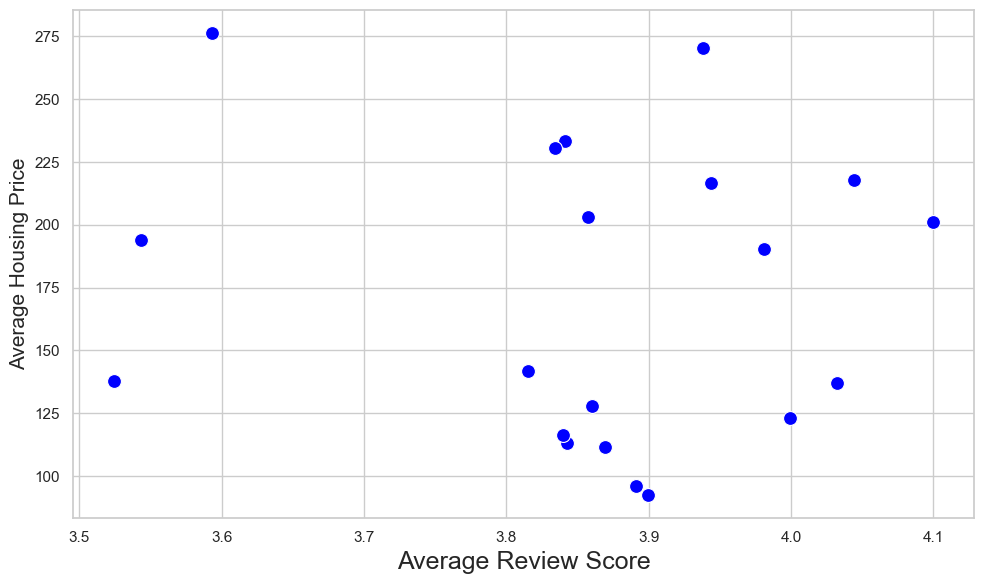

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'dataframe1' contains 'price', 'review_scores_rating', and 'neighbourhood'
dataframe1['review_scores_rating'] = pd.to_numeric(dataframe1['review_scores_rating'], errors='coerce')  # Convert to numeric if not already

# Group by 'neighbourhood' and calculate the mean price and mean review score
neighbourhood_stats = dataframe1.groupby('neighbourhood').agg({
    'price': 'mean',
    'review_scores_rating': 'mean'
}).reset_index()

# Drop any rows with NaN values that may interfere with visualization
neighbourhood_stats.dropna(inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_scores_rating', y='price', data=neighbourhood_stats, color='blue', s=100)

# Adjust the size of the title and labels
plt.xlabel('Average Review Score', fontsize=18)
plt.ylabel('Average Housing Price', fontsize=15)
plt.grid(True)

plt.tight_layout()
plt.show()

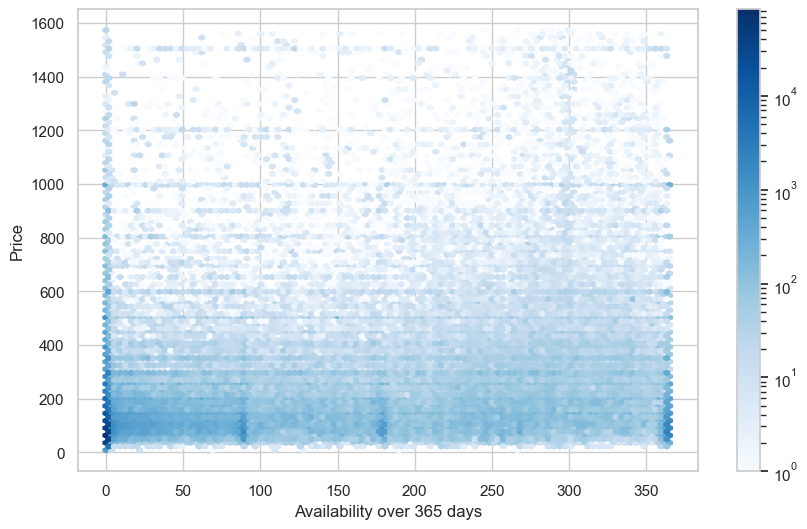

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of availability_365 vs price without neighborhood distinction
#plt.figure(figsize=(10, 6))

# Using a single color for all points
#plt.scatter(dataframe1['availability_365'], dataframe1['price'], alpha=0.5)

#plt.xlabel('Availability over 365 days')
#plt.ylabel('Price')
#plt.title('Availability vs Price')
#plt.show()

plt.figure(figsize=(10, 6))

# Using a higher gridsize for more detail
# Applying a logarithmic scale with 'norm' and setting a minimum count threshold for display with 'mincnt'
plt.hexbin(dataframe1['availability_365'], dataframe1['price'], gridsize=100, cmap='Blues', bins='log', mincnt=1)
plt.colorbar()

plt.xlabel('Availability over 365 days')
plt.ylabel('Price')
plt.show()